## Imports

In [39]:
import operator
import numpy as np
import pickle as pkl
import random
from numpy import linalg as LA
from matplotlib import pyplot as plt
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from time import time
from multiprocessing import Pool
from scipy.stats import binned_statistic

import sys
import copy
import numpy as np
import pandas as pd
import os
import xarray as xr
from operator import itemgetter

from matplotlib import pyplot as plt
import matplotlib as mpl

## Define helper methods

In [144]:
# centralize buckets around test point to avoid bad results caused by test point near bucket edges
def centralize_buckets_around_test_point(bucket_size, base_bucket_edges, verbose, test_point_label):
    bucket_of_sample = np.digitize(test_point_label, base_bucket_edges).item()

    left_edge, right_edge = base_bucket_edges[bucket_of_sample-1], base_bucket_edges[bucket_of_sample]
    
    distance_left_edge, distance_right_edge = np.abs(left_edge - test_point_label), np.abs(right_edge - test_point_label)

    if distance_left_edge == distance_right_edge:
        return base_bucket_edges
    elif distance_left_edge > distance_right_edge:
        # point is closer on right side, shift bucked edges shift right
        distance_to_shift = bucket_size/2 - distance_right_edge
        bucket_edges_shifted = base_bucket_edges + distance_to_shift
    else:
        # point is closer on left side, shift bucked edges shift left
        distance_to_shift = bucket_size/2 - distance_left_edge
        bucket_edges_shifted = base_bucket_edges - distance_to_shift
        
    left_edge_shifted, right_edge_shifted = bucket_edges_shifted[bucket_of_sample-1], bucket_edges_shifted[bucket_of_sample]
    
    distance_left_edge_shifted, distance_right_edge_shifted = left_edge_shifted - test_point_label, right_edge_shifted - test_point_label
    
    difference_between_left_right_shifted_distance = np.round(np.float(np.abs(distance_left_edge_shifted) - np.abs(distance_right_edge_shifted)), 3)
    if difference_between_left_right_shifted_distance != 0:
        raise Exception('Distance was not equal after shift! [%s]' % difference_between_left_right_shifted_distance)

    if verbose:
        print("Bucket of samples:", bucket_of_sample)
        print("Label:", test_point_label)
        print("Edges:", left_edge, right_edge)
        print("Distance edges:", distance_left_edge, distance_right_edge)
        print("Distance to shift", distance_to_shift)
        print("Shifted edges:", left_edge_shifted, right_edge_shifted)
        print("Distance to shifted edges:", distance_left_edge_shifted, distance_right_edge_shifted)
        print("Difference between left & right side: %.3f" % difference_between_left_right_shifted_distance)
        print()
        
    return bucket_edges_shifted
        
month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx

height_diff_min = -520.1044921875
height_diff_max = 382.5205078125
def inverseHeightDiffNormalization(x):
    x=np.array(x)
    x = x*(height_diff_max-height_diff_min)
    return x
    
def plotBestWorstShapleyResultsAllData(k_largest, influences):

    
    # define number of influences to be plotted
    k_largest_influences = k_largest
    k_smallest_influences = k_largest

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get array of ('Station','Init') ordered by training sample indices
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    
    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, inverseHeightDiffNormalization(station_hh_diff))]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    largest_influence_data = np.array(list(zip(*station_init_by_largest_influence)), dtype='float64')

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, inverseHeightDiffNormalization(station_hh_diff))]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    smallest_influence_data = np.array(list(zip(*station_init_by_smallest_influence)), dtype='float64')
    
    # plot influence against height difference
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,9))
    
    # aggregate influence of most influential points per height difference
    largest_influences_per_height_difference = np.bincount(largest_influence_data[6].astype(int), largest_influence_data[2])
    smallest_influences_per_height_difference = np.bincount(smallest_influence_data[6].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_height_difference)),
                                        np.max(np.absolute(smallest_influences_per_height_difference)))
    
    # plot stations with largest effect
    axes[0].bar(range(len(largest_influences_per_height_difference)), largest_influences_per_height_difference, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(range(len(smallest_influences_per_height_difference)), smallest_influences_per_height_difference, color='red')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    x_ticks_height_difference = np.linspace(0, height_diff_max + np.absolute(height_diff_min),15)
    x_ticklabels_height_difference = np.linspace(height_diff_min, height_diff_max,15)
    plt.setp(axes, xticks=x_ticks_height_difference, xticklabels=["%im" % hh for hh in x_ticklabels_height_difference])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle('Shapley Values per Height Difference', fontsize=18)
    plt.show()
    plt.close()
    
    # plot influence by hour
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,9))
    
    # aggregate influence of most influential points per hour
    largest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 24)
    smallest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 24)
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_hour)),
                                        np.max(np.absolute(smallest_influences_per_hour)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(0,24), largest_influences_per_hour, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].bar(np.arange(0,24), smallest_influences_per_hour, color='red')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Shapley Values per Hour', fontsize=18)
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

    # plot influence by month
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(14,9))
    
    # aggregate influence of most influential points per month
    print(set([int(str(m)[2:4]) for m in largest_influence_data[1]]))
    largest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 13)[1:]
    smallest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 13)[1:]
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_month)),
                                        np.max(np.absolute(smallest_influences_per_month)))
    print(largest_influences_per_month) 
    # plot stations with largest effect
    axes[0].bar(np.arange(0,12), largest_influences_per_month, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(0,12), smallest_influences_per_month, color='red')
    axes[1].set_xlim(-1,12,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences, fontsize=18)
    plt.suptitle('Shapley Values per Month')
    plt.setp(axes[1], xticks=np.arange(0,12), xticklabels=[month_dict[m] for m in range(12)])
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

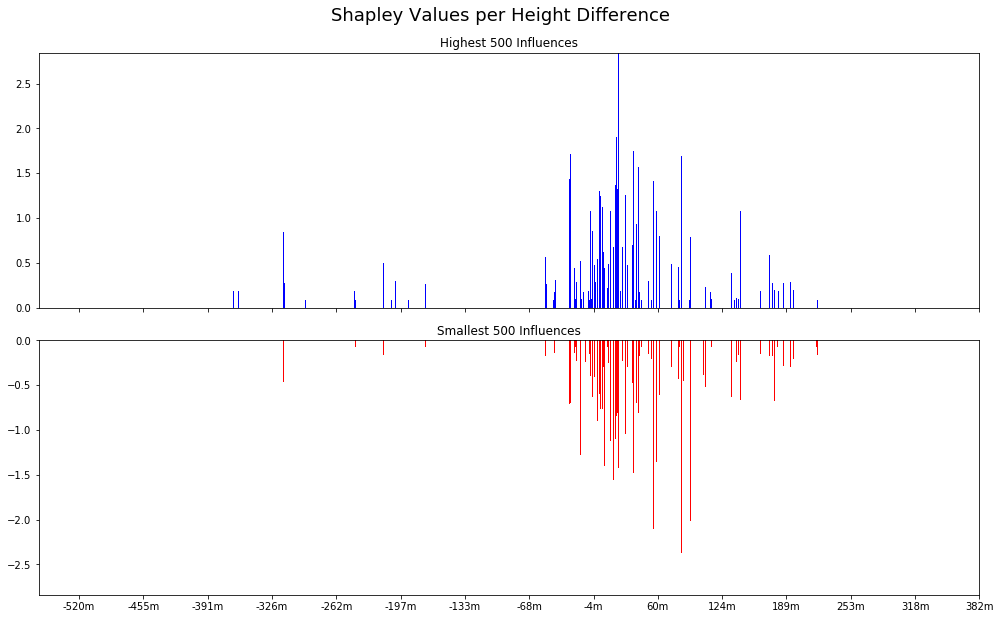

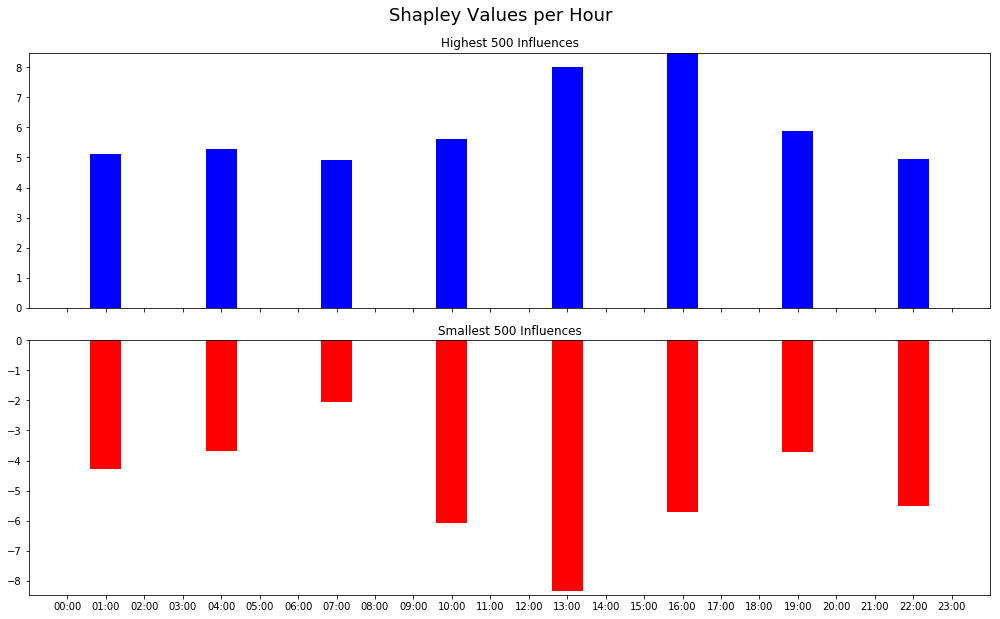

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
[ 0.09430987  0.09150622  1.06709905  2.19325253  8.40810051 15.01947042
  7.38703503  8.54093089  3.85655067  1.23600374  0.36673648  0.        ]


In [145]:
plotBestWorstShapleyResultsAllData(500, complete_shapley_sum)

In [ ]:
# centralize buckets around test point to avoid bad results caused by test point near bucket edges
def centralize_buckets_around_test_point(bucket_size, base_bucket_edges, verbose, test_point_label):
    bucket_of_sample = np.digitize(test_point_label, base_bucket_edges).item()

    left_edge, right_edge = base_bucket_edges[bucket_of_sample-1], base_bucket_edges[bucket_of_sample]
    
    distance_left_edge, distance_right_edge = np.abs(left_edge - test_point_label), np.abs(right_edge - test_point_label)

    if distance_left_edge == distance_right_edge:
        return base_bucket_edges
    elif distance_left_edge > distance_right_edge:
        # point is closer on right side, shift bucked edges shift right
        distance_to_shift = bucket_size/2 - distance_right_edge
        bucket_edges_shifted = base_bucket_edges + distance_to_shift
    else:
        # point is closer on left side, shift bucked edges shift left
        distance_to_shift = bucket_size/2 - distance_left_edge
        bucket_edges_shifted = base_bucket_edges - distance_to_shift
        
    left_edge_shifted, right_edge_shifted = bucket_edges_shifted[bucket_of_sample-1], bucket_edges_shifted[bucket_of_sample]
    
    distance_left_edge_shifted, distance_right_edge_shifted = left_edge_shifted - test_point_label, right_edge_shifted - test_point_label
    
    difference_between_left_right_shifted_distance = np.round(np.float(np.abs(distance_left_edge_shifted) - np.abs(distance_right_edge_shifted)), 3)
    if difference_between_left_right_shifted_distance != 0:
        raise Exception('Distance was not equal after shift! [%s]' % difference_between_left_right_shifted_distance)

    if verbose:
        print("Bucket of samples:", bucket_of_sample)
        print("Label:", test_point_label)
        print("Edges:", left_edge, right_edge)
        print("Distance edges:", distance_left_edge, distance_right_edge)
        print("Distance to shift", distance_to_shift)
        print("Shifted edges:", left_edge_shifted, right_edge_shifted)
        print("Distance to shifted edges:", distance_left_edge_shifted, distance_right_edge_shifted)
        print("Difference between left & right side: %.3f" % difference_between_left_right_shifted_distance)
        print()
        
    return bucket_edges_shifted
        
month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx
    
def plotBestWorstShapleyResultsAllData(k_largest, influences, ):
    
    # define number of influences to be plotted
    k_largest_influences = k_largest
    k_smallest_influences = k_largest

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get array of ('Station','Init') ordered by training sample indices
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    
    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    largest_influence_data = np.array(list(zip(*station_init_by_largest_influence)), dtype='float64')

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    smallest_influence_data = np.array(list(zip(*station_init_by_smallest_influence)), dtype='float64')
    
    # plot influence against height difference
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # aggregate influence of most influential points per height difference
    largest_influences_per_height_difference = np.bincount(largest_influence_data[6].astype(int), largest_influence_data[2])
    smallest_influences_per_height_difference = np.bincount(smallest_influence_data[6].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_height_difference)),
                                        np.max(np.absolute(smallest_influences_per_height_difference)))
    
    # plot stations with largest effect
    axes[0].bar(range(len(largest_influences_per_height_difference)), largest_influences_per_height_difference, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(range(len(smallest_influences_per_height_difference)), smallest_influences_per_height_difference, color='red')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Shapley Values per Height Difference')
    
    # plot influence by hour
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # aggregate influence of most influential points per hour
    largest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 24)
    smallest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 24)
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_hour)),
                                        np.max(np.absolute(smallest_influences_per_hour)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(0,24), largest_influences_per_hour, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].bar(np.arange(0,24), smallest_influences_per_hour, color='red')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Shapley Values per Hour')
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    plt.show()
    plt.close()

    # plot influence by month
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # aggregate influence of most influential points per month
    largest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 13)[1:]
    smallest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 13)[1:]
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_month)),
                                        np.max(np.absolute(smallest_influences_per_month)))
        
    # plot stations with largest effect
    axes[0].bar(np.arange(1,13), largest_influences_per_month, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(1,13), smallest_influences_per_month, color='red')
    axes[1].set_xlim(0,13,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Shapley Values per Month')
    plt.setp(axes[1], xticks=np.arange(1,13), xticklabels=[month_dict[m] for m in range(12)])
    plt.show()
    plt.close()
    
    
    # plot influence by year
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # aggregate influence of most influential points per year
    largest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 19), (15,16,17,18))
    smallest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 19), (15,16,17,18))
    
    max_absolute_influence = np.maximum(np.max(np.absolute(largest_influences_per_year)),
                                        np.max(np.absolute(smallest_influences_per_year)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(15,19), largest_influences_per_year, color='blue')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(15,19), smallest_influences_per_year, color='red')
    axes[1].set_xlim(14,19,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Shapley Values per Year')
    plt.setp(axes[1], xticks=np.arange(15,19), xticklabels=['2015', '2016', '2017', '2018'])
    plt.show()
    plt.close()

## Load data

In [4]:
with open('/home/ninow/master_thesis/code/project/results/data_valuation/neural_embeddings.pkl','rb') as handle:
    neural_embeddings = pkl.load(handle)
with open('/home/ninow/master_thesis/code/project/results/data_valuation/neural_embeddings_error_prediction.pkl','rb') as handle:
    neural_embeddings_error_prediction = pkl.load(handle)

In [5]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name
# load time invariant grid topo feature data
topo = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_heigh_diff = topo.grid_data.sel(feature='HH_DIFF').squeeze()
stations_lat_idx = station_data.closest_grid_point.sel(direction = 'lat_2d_global')
stations_lat_idx = stations_lat_idx - np.min(stations_lat_idx)
stations_lon_idx = station_data.closest_grid_point.sel(direction = 'lon_2d_global')
stations_lon_idx = stations_lon_idx - np.min(stations_lon_idx)

In [78]:
# load prediction error from prediction run
prediction_error = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/model_predictions/knn_1/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_24/model_run_error.pkl', 'rb')).run_0

In [80]:
# load data statistic for highest and lowest height difference
data_statistic = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/feature_summary_grid_1.pkl', 'rb'))

<xarray.DataArray (feature: 14, characteristic: 4)>
array([[ 6.562908e+04,  1.023940e+05,  8.981260e+04,  5.546233e+07],
       [-2.126105e+01,  3.138480e+01,  3.903601e-01,  5.459841e+00],
       [-2.618205e+01,  3.005240e+01,  8.864460e-02,  5.904356e+00],
       [ 1.160997e-02,  7.438608e+01,  4.586049e+00,  1.489732e+01],
       [ 2.413623e+02,  3.121619e+02,  2.793485e+02,  7.530203e+01],
       [ 2.099164e+02,  2.978087e+02,  2.750036e+02,  6.464669e+01],
       [-9.999999e-05,  9.999990e+01,  3.375783e+01,  1.808034e+03],
       [-9.999999e-05,  9.999990e+01,  5.117892e+01,  2.140399e+03],
       [-9.999999e-05,  9.999990e+01,  3.973362e+01,  1.986587e+03],
       [ 0.000000e+00,  2.653203e+02,  3.801991e-04,  8.393450e-06],
       [ 7.000000e+00,  7.000000e+01,  2.309183e+01,  3.576509e+02],
       [ 0.000000e+00,  8.888615e+02,  9.976943e+01,  3.051206e+04],
       [-2.116079e+02,  3.445615e+01, -5.488539e+01,  1.485097e+03],
       [ 9.197754e+00,  6.109155e+03,  3.827927e+02

## Prepare Data

In [8]:
# split data set into train and test
train_data_set = neural_embeddings['train_embeddings']
train_label_set = neural_embeddings['train_labels']
test_data_set = neural_embeddings['test_embeddings']
test_label_set = neural_embeddings['test_labels']

# get numpy representation of neural embeddings
X_train = train_data_set.as_matrix()[:,2:]
Y_train_temp = train_label_set.as_matrix()[:]
X_test = test_data_set.as_matrix()[:,2:]
Y_test_temp = test_label_set.as_matrix()[:]

# calculate number of training examples
num_train_examples = X_train.shape[0]
num_test_examples = X_test.shape[0]
num_features = X_train.shape[1]

In [9]:
num_test_examples

103210

In [11]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.5))

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

In [13]:
n_classes, size_of_bucket

(131, 0.49770990036826096)

## Calculate Shapley Values with KNN-Regression

In [121]:
def get_distance(features, vector):
    norms = features.shape[0] * [0]
    for i in range(0, features.shape[0]):
        n = LA.norm(features[i] - vector)
        assert(n is not None)
        norms[i] = n
    return norms

def get_values(distances, test_idx, Y_train_shifted, Y_test_shifted):
    values = np.zeros(num_train_examples)
    i = len(distances)
    lastvalue = 0
    lastkey = -1
    K = 50
    for key in np.argsort(distances)[::-1]:
        if i == len(distances):
            lastvalue = 0
        else:
            # print(Y_train[key] == Y_test[test_idx], Y_train[lastkey] == Y_test[test_idx], Y_train[key], Y_test[test_idx], Y_train[lastkey], Y_test[test_idx])
            value = 1.0 * (1.0 * (Y_train_shifted[key] == Y_test_shifted[test_idx]) - 1.0 * (Y_train_shifted[lastkey] == Y_test_shifted[test_idx])) \
                                            / K * (min(K-1, i-1) + 1) / i
            lastvalue = lastvalue + value
        lastkey = key
        i = i - 1

        values[key] = lastvalue
    return values

def run_knn(test_indices, Y_train, Y_test, cetralize_function):
    n_test_samples = len(test_indices)
    for idx, i in enumerate(test_indices):
        start = time()
        
        # adapt the bins to be centralized around thest point
        bucket_edges_shifted = cetralize_function(Y_test[i])
    
        # get index of bucket for each training data
        Y_train_shifted = np.digitize(Y_train, bucket_edges_shifted) - 1
        Y_test_shifted = np.digitize(Y_test, bucket_edges_shifted) - 1
        
        distances = get_distance(X_train, X_test[i]) # get distance to test image
        knn_value = get_values(distances, i, Y_train_shifted, Y_test_shifted)
        
        try:
            knn_values += knn_value
        except:
            knn_values = knn_value
        
        if (i+1) % 50 == 0:
            print('Calculation of knn values for test idx=%s took %s [%.2f%%]' % (i, time() - start, (idx/len(test_indices))*100))
    return knn_values

def get_knn_shapley_values(Y_train, Y_test, test_indices, bucket_size):
# adapt the labels to classes
    min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
    n_classes = int(np.ceil((max_label - min_label)/bucket_size))

    # the size of each bucket
    size_of_bucket = (max_label - min_label)/n_classes

    # we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
    bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

    cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

    return (test_indices, run_knn(test_indices, Y_train, Y_test, cetralize_function))

## Calculate Shapley Values with KNN with Temp. prediction data

### Select randomly 20% of test data

In [32]:
n_selected_test_points = int(X_test.shape[0]*0.2)
test_point_selection = np.sort(random.sample(list(np.arange(X_test.shape[0])), n_selected_test_points))
print("Selected 20% of test points, resulting in n_test=", n_selected_test_points)

20642.0

In [73]:
parallel_chunks = np.array_split(test_point_selection,16)

### Calculate shapley values in parallel using KNN approach

In [108]:
shapley_results = []
with Pool(processes=16) as pool:
    process_results = []
    for chunk_idx, chunk in enumerate(parallel_chunks):
        process_results.append(pool.apply_async(get_knn_shapley_values, (Y_train_temp, Y_test_temp, list(chunk), 2)))
        
            # aggregate results from all processes
    for ps_idx, ps_result in enumerate(process_results):
        # sync processes
        x = ps_result.get()
        shapley_results += [x]
        print('[Process %s] Synchronized after calculating shapley values.' % ps_idx)

Calculation of knn values for test idx=44393 took 38.57254695892334 [0.00%]
Calculation of knn values for test idx=89993 took 39.10536575317383 [0.00%]
Calculation of knn values for test idx=19124 took 39.317033767700195 [0.00%]
Calculation of knn values for test idx=6455 took 40.36512589454651 [0.00%]
Calculation of knn values for test idx=35 took 38.68841576576233 [0.08%]
Calculation of knn values for test idx=50882 took 39.6117582321167 [0.08%]
Calculation of knn values for test idx=89996 took 39.22530555725098 [0.08%]
Calculation of knn values for test idx=19130 took 39.80172944068909 [0.08%]
Calculation of knn values for test idx=96674 took 38.3315372467041 [0.08%]
Calculation of knn values for test idx=50885 took 38.488210678100586 [0.16%]
Calculation of knn values for test idx=83642 took 38.89553999900818 [0.16%]
Calculation of knn values for test idx=6461 took 38.4900803565979 [0.15%]
Calculation of knn values for test idx=25379 took 38.479538917541504 [0.23%]
Calculation of kn

Calculation of knn values for test idx=83729 took 37.31914019584656 [1.47%]
Calculation of knn values for test idx=38102 took 38.18399477005005 [1.47%]
Calculation of knn values for test idx=50951 took 38.226736068725586 [1.47%]
Calculation of knn values for test idx=57629 took 37.11697793006897 [1.55%]
Calculation of knn values for test idx=19250 took 35.86648392677307 [1.55%]
Calculation of knn values for test idx=6539 took 37.06966686248779 [1.55%]
Calculation of knn values for test idx=44480 took 38.21365785598755 [1.55%]
Calculation of knn values for test idx=70754 took 37.910524129867554 [1.55%]
Calculation of knn values for test idx=31739 took 36.20078372955322 [1.55%]
Calculation of knn values for test idx=90113 took 37.89378762245178 [1.55%]
Calculation of knn values for test idx=50960 took 38.11807298660278 [1.55%]
Calculation of knn values for test idx=83741 took 36.33638954162598 [1.63%]
Calculation of knn values for test idx=25454 took 36.45279598236084 [1.63%]
Calculation

Calculation of knn values for test idx=90194 took 36.97555470466614 [2.95%]
Calculation of knn values for test idx=44576 took 37.33790731430054 [2.95%]
Calculation of knn values for test idx=38204 took 39.723135471343994 [2.95%]
Calculation of knn values for test idx=96899 took 36.38567543029785 [2.95%]
Calculation of knn values for test idx=51050 took 36.04098725318909 [2.95%]
Calculation of knn values for test idx=90209 took 38.60129642486572 [3.02%]
Calculation of knn values for test idx=44579 took 37.26777148246765 [3.02%]
Calculation of knn values for test idx=70838 took 37.56694769859314 [3.02%]
Calculation of knn values for test idx=83810 took 37.03639316558838 [3.10%]
Calculation of knn values for test idx=6635 took 37.14871120452881 [3.10%]
Calculation of knn values for test idx=90212 took 38.602330684661865 [3.10%]
Calculation of knn values for test idx=64451 took 38.77880382537842 [3.10%]
Calculation of knn values for test idx=31850 took 37.21577048301697 [3.10%]
Calculation

Calculation of knn values for test idx=51152 took 33.80678105354309 [4.57%]
Calculation of knn values for test idx=350 took 33.81415557861328 [4.65%]
Calculation of knn values for test idx=25694 took 35.053760051727295 [4.65%]
Calculation of knn values for test idx=44675 took 33.74128293991089 [4.65%]
Calculation of knn values for test idx=13106 took 35.11364817619324 [4.65%]
Calculation of knn values for test idx=90299 took 34.2772102355957 [4.65%]
Calculation of knn values for test idx=44678 took 33.617671728134155 [4.73%]
Calculation of knn values for test idx=57845 took 32.942341804504395 [4.81%]
Calculation of knn values for test idx=38312 took 34.58010959625244 [4.73%]
Calculation of knn values for test idx=64535 took 34.60513734817505 [4.73%]
Calculation of knn values for test idx=6752 took 33.77878189086914 [4.80%]
Calculation of knn values for test idx=19478 took 36.39598870277405 [4.81%]
Calculation of knn values for test idx=77375 took 36.30846071243286 [4.81%]
Calculation o

Calculation of knn values for test idx=32048 took 35.992085218429565 [6.12%]
Calculation of knn values for test idx=97094 took 34.19359278678894 [6.12%]
Calculation of knn values for test idx=71036 took 34.271913051605225 [6.12%]
Calculation of knn values for test idx=57923 took 33.7668936252594 [6.36%]
Calculation of knn values for test idx=6851 took 35.461421489715576 [6.27%]
Calculation of knn values for test idx=25805 took 33.622868061065674 [6.28%]
Calculation of knn values for test idx=51254 took 34.48734951019287 [6.28%]
Calculation of knn values for test idx=71039 took 34.125328063964844 [6.20%]
Calculation of knn values for test idx=38402 took 35.90727210044861 [6.28%]
Calculation of knn values for test idx=44765 took 35.930113792419434 [6.36%]
Calculation of knn values for test idx=25820 took 33.609358072280884 [6.36%]
Calculation of knn values for test idx=6854 took 35.48318910598755 [6.35%]
Calculation of knn values for test idx=77492 took 33.92322659492493 [6.36%]
Calculat

Calculation of knn values for test idx=71126 took 52.7590606212616 [7.75%]
Calculation of knn values for test idx=19691 took 49.78756523132324 [7.91%]
Calculation of knn values for test idx=13358 took 46.00415587425232 [7.91%]
Calculation of knn values for test idx=32171 took 45.58355259895325 [7.83%]
Calculation of knn values for test idx=90488 took 44.593958616256714 [7.91%]
Calculation of knn values for test idx=57998 took 52.550888776779175 [8.06%]
Calculation of knn values for test idx=64748 took 45.66154170036316 [7.91%]
Calculation of knn values for test idx=77606 took 42.01304745674133 [7.98%]
Calculation of knn values for test idx=19694 took 52.75739550590515 [7.98%]
Calculation of knn values for test idx=90491 took 49.85829210281372 [7.98%]
Calculation of knn values for test idx=25931 took 44.1240918636322 [8.06%]
Calculation of knn values for test idx=44876 took 44.14924097061157 [8.06%]
Calculation of knn values for test idx=58004 took 51.30949068069458 [8.14%]
Calculation 

Calculation of knn values for test idx=97310 took 34.112847566604614 [9.46%]
Calculation of knn values for test idx=13454 took 34.63273477554321 [9.53%]
Calculation of knn values for test idx=90599 took 34.10094475746155 [9.53%]
Calculation of knn values for test idx=51431 took 33.85652828216553 [9.53%]
Calculation of knn values for test idx=19778 took 34.04830241203308 [9.61%]
Calculation of knn values for test idx=77720 took 35.11994385719299 [9.61%]
Calculation of knn values for test idx=84155 took 33.90340781211853 [9.61%]
Calculation of knn values for test idx=71228 took 34.09682869911194 [9.46%]
Calculation of knn values for test idx=7097 took 35.44252943992615 [9.60%]
Calculation of knn values for test idx=44966 took 33.57757019996643 [9.69%]
Calculation of knn values for test idx=51440 took 33.78265714645386 [9.61%]
Calculation of knn values for test idx=7100 took 35.276796102523804 [9.68%]
Calculation of knn values for test idx=44975 took 33.6000440120697 [9.77%]
Calculation o

Calculation of knn values for test idx=71327 took 52.49589705467224 [11.01%]
Calculation of knn values for test idx=45104 took 52.822537422180176 [11.24%]
Calculation of knn values for test idx=32375 took 55.644288063049316 [11.09%]
Calculation of knn values for test idx=58211 took 50.47268795967102 [11.32%]
Calculation of knn values for test idx=51572 took 52.642306327819824 [11.16%]
Calculation of knn values for test idx=13553 took 53.89572834968567 [11.16%]
Calculation of knn values for test idx=64931 took 52.12141156196594 [11.16%]
Calculation of knn values for test idx=45110 took 54.28902316093445 [11.32%]
Calculation of knn values for test idx=90671 took 53.20558190345764 [11.24%]
Calculation of knn values for test idx=26147 took 52.65428328514099 [11.32%]
Calculation of knn values for test idx=38750 took 51.25978946685791 [11.24%]
Calculation of knn values for test idx=64934 took 52.291433572769165 [11.24%]
Calculation of knn values for test idx=854 took 52.930129051208496 [11.3

Calculation of knn values for test idx=32438 took 36.47579860687256 [12.56%]
Calculation of knn values for test idx=58295 took 35.93655753135681 [12.79%]
Calculation of knn values for test idx=13631 took 37.62853646278381 [12.64%]
Calculation of knn values for test idx=51656 took 34.30589771270752 [12.64%]
Calculation of knn values for test idx=923 took 35.16844463348389 [12.70%]
Calculation of knn values for test idx=19988 took 35.82614326477051 [12.71%]
Calculation of knn values for test idx=32447 took 37.71611738204956 [12.64%]
Calculation of knn values for test idx=65033 took 41.846673011779785 [12.64%]
Calculation of knn values for test idx=58298 took 36.74184441566467 [12.87%]
Calculation of knn values for test idx=26222 took 39.40693974494934 [12.79%]
Calculation of knn values for test idx=84365 took 34.72437143325806 [12.79%]
Calculation of knn values for test idx=51662 took 35.74241328239441 [12.71%]
Calculation of knn values for test idx=19997 took 36.858604192733765 [12.79%]

Calculation of knn values for test idx=97601 took 34.09471940994263 [14.19%]
Calculation of knn values for test idx=20090 took 33.61335229873657 [14.42%]
Calculation of knn values for test idx=38951 took 34.19715356826782 [14.34%]
Calculation of knn values for test idx=58403 took 33.663262367248535 [14.57%]
Calculation of knn values for test idx=45284 took 35.53101682662964 [14.50%]
Calculation of knn values for test idx=1067 took 37.253867626190186 [14.48%]
Calculation of knn values for test idx=84473 took 36.251418352127075 [14.50%]
Calculation of knn values for test idx=58406 took 34.66439342498779 [14.65%]
Calculation of knn values for test idx=20099 took 33.703861474990845 [14.57%]
Calculation of knn values for test idx=7409 took 36.46949315071106 [14.48%]
Calculation of knn values for test idx=84488 took 35.65855002403259 [14.57%]
Calculation of knn values for test idx=65132 took 32.98419713973999 [14.50%]
Calculation of knn values for test idx=13748 took 33.66347670555115 [14.57

Calculation of knn values for test idx=71666 took 36.12572193145752 [15.74%]
Calculation of knn values for test idx=1121 took 36.671870470047 [15.88%]
Calculation of knn values for test idx=78134 took 35.955246448516846 [15.89%]
Calculation of knn values for test idx=90935 took 35.805315017700195 [15.89%]
Calculation of knn values for test idx=51866 took 34.09347319602966 [15.89%]
Calculation of knn values for test idx=20195 took 33.56496071815491 [16.05%]
Calculation of knn values for test idx=58514 took 33.79284358024597 [16.12%]
Calculation of knn values for test idx=45374 took 33.75670504570007 [16.05%]
Calculation of knn values for test idx=1124 took 36.71429252624512 [15.96%]
Calculation of knn values for test idx=39035 took 34.64800000190735 [15.97%]
Calculation of knn values for test idx=78137 took 36.09520387649536 [15.97%]
Calculation of knn values for test idx=97715 took 36.689430475234985 [15.81%]
Calculation of knn values for test idx=32657 took 33.78012466430664 [15.97%]


Calculation of knn values for test idx=58643 took 33.704254388809204 [17.75%]
Calculation of knn values for test idx=71780 took 34.085498094558716 [17.36%]
Calculation of knn values for test idx=39131 took 35.43618440628052 [17.52%]
Calculation of knn values for test idx=65336 took 37.04448914527893 [17.52%]
Calculation of knn values for test idx=78227 took 34.8164803981781 [17.52%]
Calculation of knn values for test idx=32801 took 33.513463258743286 [17.60%]
Calculation of knn values for test idx=45470 took 33.627928256988525 [17.75%]
Calculation of knn values for test idx=7568 took 36.94043159484863 [17.51%]
Calculation of knn values for test idx=1211 took 36.95386505126953 [17.51%]
Calculation of knn values for test idx=97814 took 37.04435467720032 [17.36%]
Calculation of knn values for test idx=51983 took 33.985748291015625 [17.67%]
Calculation of knn values for test idx=71792 took 34.056668281555176 [17.52%]
Calculation of knn values for test idx=78239 took 37.42597961425781 [17.6

Calculation of knn values for test idx=91163 took 34.01898264884949 [18.99%]
Calculation of knn values for test idx=52067 took 36.210187673568726 [18.99%]
Calculation of knn values for test idx=58760 took 33.80222129821777 [19.30%]
Calculation of knn values for test idx=20375 took 36.25908803939819 [19.22%]
Calculation of knn values for test idx=14042 took 33.798476219177246 [19.15%]
Calculation of knn values for test idx=84806 took 36.27197980880737 [19.07%]
Calculation of knn values for test idx=65420 took 34.15256953239441 [19.07%]
Calculation of knn values for test idx=71882 took 34.03945755958557 [18.99%]
Calculation of knn values for test idx=91169 took 34.03136372566223 [19.15%]
Calculation of knn values for test idx=52076 took 36.33838725090027 [19.15%]
Calculation of knn values for test idx=71888 took 36.98119306564331 [19.07%]
Calculation of knn values for test idx=97883 took 36.768452405929565 [18.91%]
Calculation of knn values for test idx=45563 took 34.793293476104736 [19.

Calculation of knn values for test idx=78425 took 36.392154693603516 [20.62%]
Calculation of knn values for test idx=20483 took 33.73401641845703 [20.85%]
Calculation of knn values for test idx=58853 took 36.72951579093933 [20.93%]
Calculation of knn values for test idx=65516 took 36.69708847999573 [20.62%]
Calculation of knn values for test idx=39296 took 34.01158356666565 [20.70%]
Calculation of knn values for test idx=14156 took 33.79159903526306 [20.78%]
Calculation of knn values for test idx=52172 took 36.46506476402283 [20.70%]
Calculation of knn values for test idx=78440 took 36.43838095664978 [20.70%]
Calculation of knn values for test idx=58862 took 36.6930832862854 [21.01%]
Calculation of knn values for test idx=26717 took 33.720040798187256 [21.01%]
Calculation of knn values for test idx=84884 took 33.71915006637573 [20.78%]
Calculation of knn values for test idx=39305 took 34.10314702987671 [20.78%]
Calculation of knn values for test idx=33038 took 34.15564584732056 [20.85%

Calculation of knn values for test idx=84953 took 34.82569479942322 [22.09%]
Calculation of knn values for test idx=26801 took 34.50817346572876 [22.33%]
Calculation of knn values for test idx=1517 took 33.92725586891174 [22.00%]
Calculation of knn values for test idx=20618 took 36.50397300720215 [22.33%]
Calculation of knn values for test idx=14216 took 35.04631519317627 [22.17%]
Calculation of knn values for test idx=45761 took 36.01499652862549 [22.25%]
Calculation of knn values for test idx=33134 took 33.46151351928711 [22.25%]
Calculation of knn values for test idx=65600 took 35.89888381958008 [22.09%]
Calculation of knn values for test idx=39404 took 35.982706785202026 [22.17%]
Calculation of knn values for test idx=78527 took 36.574203968048096 [22.09%]
Calculation of knn values for test idx=14222 took 35.101656675338745 [22.25%]
Calculation of knn values for test idx=7847 took 35.090466260910034 [22.08%]
Calculation of knn values for test idx=45764 took 36.05844712257385 [22.33

Calculation of knn values for test idx=85058 took 34.58429980278015 [23.72%]
Calculation of knn values for test idx=52346 took 34.687365770339966 [23.64%]
Calculation of knn values for test idx=14309 took 35.8990912437439 [23.80%]
Calculation of knn values for test idx=98204 took 33.74812936782837 [23.49%]
Calculation of knn values for test idx=39509 took 34.858762979507446 [23.72%]
Calculation of knn values for test idx=78635 took 34.967782497406006 [23.64%]
Calculation of knn values for test idx=26927 took 35.565226554870605 [24.03%]
Calculation of knn values for test idx=20738 took 34.73756551742554 [23.95%]
Calculation of knn values for test idx=52349 took 34.81367111206055 [23.72%]
Calculation of knn values for test idx=65735 took 34.31910300254822 [23.72%]
Calculation of knn values for test idx=98207 took 33.88759422302246 [23.57%]
Calculation of knn values for test idx=33260 took 34.04637575149536 [23.95%]
Calculation of knn values for test idx=39512 took 34.77134466171265 [23.8

Calculation of knn values for test idx=59156 took 33.80237674713135 [25.66%]
Calculation of knn values for test idx=91640 took 34.01541566848755 [25.43%]
Calculation of knn values for test idx=78731 took 33.80283832550049 [25.27%]
Calculation of knn values for test idx=33383 took 33.70252466201782 [25.58%]
Calculation of knn values for test idx=8042 took 33.77235651016235 [25.33%]
Calculation of knn values for test idx=85166 took 33.70951843261719 [25.43%]
Calculation of knn values for test idx=65852 took 34.1053569316864 [25.35%]
Calculation of knn values for test idx=72287 took 33.79207253456116 [25.27%]
Calculation of knn values for test idx=45956 took 34.96478056907654 [25.50%]
Calculation of knn values for test idx=59159 took 32.133914947509766 [25.74%]
Calculation of knn values for test idx=1694 took 36.119139432907104 [25.41%]
Calculation of knn values for test idx=33389 took 33.78992486000061 [25.66%]
Calculation of knn values for test idx=14435 took 35.52499866485596 [25.50%]


Calculation of knn values for test idx=91745 took 36.940046548843384 [26.67%]
Calculation of knn values for test idx=1745 took 33.707314014434814 [26.57%]
Calculation of knn values for test idx=52574 took 36.805785179138184 [26.59%]
Calculation of knn values for test idx=39698 took 34.37984538078308 [26.59%]
Calculation of knn values for test idx=8123 took 33.96049451828003 [26.57%]
Calculation of knn values for test idx=65948 took 36.0982084274292 [26.59%]
Calculation of knn values for test idx=78824 took 34.22405934333801 [26.51%]
Calculation of knn values for test idx=33494 took 37.41367864608765 [26.82%]
Calculation of knn values for test idx=27110 took 35.95926380157471 [26.90%]
Calculation of knn values for test idx=1748 took 35.002461433410645 [26.65%]
Calculation of knn values for test idx=46055 took 36.52243447303772 [26.82%]
Calculation of knn values for test idx=33497 took 35.285295486450195 [26.90%]
Calculation of knn values for test idx=52577 took 36.51599478721619 [26.74%

Calculation of knn values for test idx=21083 took 33.59936547279358 [28.53%]
Calculation of knn values for test idx=72485 took 33.96679425239563 [28.22%]
Calculation of knn values for test idx=78956 took 33.9287531375885 [28.22%]
Calculation of knn values for test idx=52697 took 34.164177894592285 [28.37%]
Calculation of knn values for test idx=33605 took 35.74052882194519 [28.53%]
Calculation of knn values for test idx=98486 took 36.02082896232605 [28.14%]
Calculation of knn values for test idx=72488 took 34.11984610557556 [28.29%]
Calculation of knn values for test idx=1844 took 34.6920702457428 [28.43%]
Calculation of knn values for test idx=14642 took 35.501545667648315 [28.53%]
Calculation of knn values for test idx=52700 took 35.54407000541687 [28.45%]
Calculation of knn values for test idx=8228 took 33.5715229511261 [28.43%]
Calculation of knn values for test idx=59360 took 34.49231481552124 [28.76%]
Calculation of knn values for test idx=98489 took 35.02312779426575 [28.22%]
Ca

Calculation of knn values for test idx=27347 took 35.860392808914185 [29.92%]
Calculation of knn values for test idx=79013 took 34.037964820861816 [29.61%]
Calculation of knn values for test idx=1949 took 35.359143018722534 [29.74%]
Calculation of knn values for test idx=14747 took 34.871363162994385 [29.84%]
Calculation of knn values for test idx=33686 took 33.499807834625244 [29.92%]
Calculation of knn values for test idx=27350 took 35.78857970237732 [30.00%]
Calculation of knn values for test idx=46253 took 36.44562077522278 [29.92%]
Calculation of knn values for test idx=85433 took 36.44214129447937 [29.84%]
Calculation of knn values for test idx=1952 took 35.48249840736389 [29.82%]
Calculation of knn values for test idx=98588 took 33.877196073532104 [29.61%]
Calculation of knn values for test idx=59465 took 36.42944598197937 [30.16%]
Calculation of knn values for test idx=52796 took 36.62490487098694 [29.84%]
Calculation of knn values for test idx=85436 took 36.421902656555176 [29

Calculation of knn values for test idx=21254 took 36.0272011756897 [31.32%]
Calculation of knn values for test idx=40013 took 34.4398410320282 [31.09%]
Calculation of knn values for test idx=59543 took 33.64692234992981 [31.47%]
Calculation of knn values for test idx=98657 took 33.771066188812256 [31.01%]
Calculation of knn values for test idx=33767 took 34.70762014389038 [31.32%]
Calculation of knn values for test idx=8399 took 33.80458927154541 [31.22%]
Calculation of knn values for test idx=72665 took 33.982630252838135 [31.16%]
Calculation of knn values for test idx=92030 took 35.68456959724426 [31.32%]
Calculation of knn values for test idx=40019 took 33.89342737197876 [31.16%]
Calculation of knn values for test idx=21263 took 35.947999715805054 [31.40%]
Calculation of knn values for test idx=59549 took 33.69885516166687 [31.55%]
Calculation of knn values for test idx=79085 took 34.07433247566223 [31.24%]
Calculation of knn values for test idx=46352 took 36.39195537567139 [31.40%]

Calculation of knn values for test idx=8486 took 34.335211992263794 [32.77%]
Calculation of knn values for test idx=40154 took 34.6515908241272 [32.71%]
Calculation of knn values for test idx=21335 took 33.94645714759827 [32.95%]
Calculation of knn values for test idx=92093 took 34.07366943359375 [32.87%]
Calculation of knn values for test idx=33860 took 34.634098291397095 [32.95%]
Calculation of knn values for test idx=2102 took 34.296958684921265 [32.77%]
Calculation of knn values for test idx=72767 took 33.988258600234985 [32.79%]
Calculation of knn values for test idx=46448 took 35.41120958328247 [32.87%]
Calculation of knn values for test idx=33866 took 33.7780647277832 [33.02%]
Calculation of knn values for test idx=92096 took 35.477646827697754 [32.95%]
Calculation of knn values for test idx=53057 took 33.764641761779785 [32.87%]
Calculation of knn values for test idx=72773 took 33.910938024520874 [32.87%]
Calculation of knn values for test idx=40175 took 34.5621612071991 [32.87

Calculation of knn values for test idx=33965 took 33.67826199531555 [34.50%]
Calculation of knn values for test idx=8576 took 34.72441291809082 [34.31%]
Calculation of knn values for test idx=21431 took 34.60671329498291 [34.50%]
Calculation of knn values for test idx=53171 took 34.060027837753296 [34.34%]
Calculation of knn values for test idx=40241 took 34.62733864784241 [34.26%]
Calculation of knn values for test idx=66389 took 34.88491153717041 [34.26%]
Calculation of knn values for test idx=59801 took 33.58564043045044 [34.65%]
Calculation of knn values for test idx=79295 took 33.997398376464844 [34.34%]
Calculation of knn values for test idx=27608 took 34.16005086898804 [34.57%]
Calculation of knn values for test idx=33968 took 33.552711725234985 [34.57%]
Calculation of knn values for test idx=53183 took 33.92182397842407 [34.42%]
Calculation of knn values for test idx=66392 took 34.8247549533844 [34.34%]
Calculation of knn values for test idx=98888 took 35.147523641586304 [34.26

Calculation of knn values for test idx=85763 took 35.213258504867554 [35.89%]
Calculation of knn values for test idx=72995 took 35.082589626312256 [35.81%]
Calculation of knn values for test idx=40337 took 34.9554328918457 [35.81%]
Calculation of knn values for test idx=92315 took 35.09558296203613 [35.97%]
Calculation of knn values for test idx=34109 took 35.303497076034546 [36.12%]
Calculation of knn values for test idx=99023 took 35.5696074962616 [35.74%]
Calculation of knn values for test idx=66494 took 36.26148319244385 [35.81%]
Calculation of knn values for test idx=46649 took 33.63722562789917 [35.97%]
Calculation of knn values for test idx=73001 took 34.133962869644165 [35.89%]
Calculation of knn values for test idx=59873 took 34.80918288230896 [36.28%]
Calculation of knn values for test idx=53291 took 35.19141221046448 [35.97%]
Calculation of knn values for test idx=2252 took 34.817809104919434 [35.86%]
Calculation of knn values for test idx=34112 took 36.4539475440979 [36.20%

Calculation of knn values for test idx=99137 took 35.236846923828125 [37.21%]
Calculation of knn values for test idx=92402 took 34.89668607711792 [37.52%]
Calculation of knn values for test idx=66611 took 34.58465647697449 [37.36%]
Calculation of knn values for test idx=40433 took 35.497530698776245 [37.44%]
Calculation of knn values for test idx=73109 took 35.68743681907654 [37.44%]
Calculation of knn values for test idx=59990 took 34.52227520942688 [37.83%]
Calculation of knn values for test idx=99140 took 35.39950346946716 [37.29%]
Calculation of knn values for test idx=21665 took 33.710286378860474 [37.67%]
Calculation of knn values for test idx=85862 took 36.94029974937439 [37.52%]
Calculation of knn values for test idx=2351 took 35.13493537902832 [37.41%]
Calculation of knn values for test idx=27800 took 34.01455211639404 [37.83%]
Calculation of knn values for test idx=34205 took 33.72114157676697 [37.75%]
Calculation of knn values for test idx=73115 took 34.0805401802063 [37.52%

Calculation of knn values for test idx=53495 took 34.25872850418091 [39.07%]
Calculation of knn values for test idx=46811 took 33.800357818603516 [39.07%]
Calculation of knn values for test idx=79556 took 35.69277310371399 [39.07%]
Calculation of knn values for test idx=34289 took 33.810866594314575 [39.30%]
Calculation of knn values for test idx=46814 took 33.897045612335205 [39.15%]
Calculation of knn values for test idx=34292 took 33.85719299316406 [39.38%]
Calculation of knn values for test idx=21779 took 33.55647563934326 [39.30%]
Calculation of knn values for test idx=85946 took 34.88702416419983 [39.07%]
Calculation of knn values for test idx=2474 took 33.944743394851685 [39.04%]
Calculation of knn values for test idx=40565 took 34.40474510192871 [39.15%]
Calculation of knn values for test idx=73244 took 34.82795977592468 [39.15%]
Calculation of knn values for test idx=92546 took 35.30609464645386 [39.22%]
Calculation of knn values for test idx=27890 took 34.47203540802002 [39.5

Calculation of knn values for test idx=8936 took 36.10850286483765 [40.43%]
Calculation of knn values for test idx=21878 took 33.503889322280884 [40.70%]
Calculation of knn values for test idx=79634 took 35.600810289382935 [40.54%]
Calculation of knn values for test idx=15374 took 34.8070285320282 [40.70%]
Calculation of knn values for test idx=53582 took 35.118128538131714 [40.62%]
Calculation of knn values for test idx=8939 took 36.082106828689575 [40.51%]
Calculation of knn values for test idx=27953 took 34.276954650878906 [40.93%]
Calculation of knn values for test idx=99353 took 34.87707805633545 [40.47%]
Calculation of knn values for test idx=2564 took 36.751373291015625 [40.51%]
Calculation of knn values for test idx=60212 took 35.51566934585571 [41.01%]
Calculation of knn values for test idx=15386 took 34.96135640144348 [40.78%]
Calculation of knn values for test idx=53585 took 35.24122333526611 [40.70%]
Calculation of knn values for test idx=92666 took 36.761125802993774 [40.7

Calculation of knn values for test idx=9014 took 35.639928340911865 [41.98%]
Calculation of knn values for test idx=28016 took 36.49935340881348 [42.40%]
Calculation of knn values for test idx=2663 took 33.8935182094574 [41.98%]
Calculation of knn values for test idx=40724 took 36.09977459907532 [42.09%]
Calculation of knn values for test idx=60326 took 36.12469291687012 [42.48%]
Calculation of knn values for test idx=99458 took 35.62037897109985 [42.02%]
Calculation of knn values for test idx=9020 took 35.57242465019226 [42.06%]
Calculation of knn values for test idx=66923 took 34.305139780044556 [42.09%]
Calculation of knn values for test idx=28028 took 36.67293381690979 [42.48%]
Calculation of knn values for test idx=79718 took 36.6893105506897 [42.17%]
Calculation of knn values for test idx=60332 took 35.95717120170593 [42.56%]
Calculation of knn values for test idx=34463 took 33.74989438056946 [42.56%]
Calculation of knn values for test idx=92792 took 35.260411977767944 [42.17%]
C

Calculation of knn values for test idx=86273 took 34.54031753540039 [43.64%]
Calculation of knn values for test idx=99584 took 34.1337149143219 [43.57%]
Calculation of knn values for test idx=79835 took 33.96654653549194 [43.72%]
Calculation of knn values for test idx=60473 took 34.1080424785614 [44.11%]
Calculation of knn values for test idx=22082 took 34.22101974487305 [43.95%]
Calculation of knn values for test idx=40823 took 34.138306617736816 [43.72%]
Calculation of knn values for test idx=2747 took 34.35198497772217 [43.61%]
Calculation of knn values for test idx=79838 took 33.957202434539795 [43.80%]
Calculation of knn values for test idx=60482 took 34.10251784324646 [44.19%]
Calculation of knn values for test idx=34556 took 33.88814902305603 [44.19%]
Calculation of knn values for test idx=99593 took 34.07136821746826 [43.72%]
Calculation of knn values for test idx=86282 took 34.87487316131592 [43.80%]
Calculation of knn values for test idx=28166 took 33.78068137168884 [44.19%]


Calculation of knn values for test idx=99686 took 36.30765748023987 [45.04%]
Calculation of knn values for test idx=15650 took 34.986581802368164 [45.27%]
Calculation of knn values for test idx=2843 took 33.82474946975708 [45.08%]
Calculation of knn values for test idx=22205 took 34.93137049674988 [45.43%]
Calculation of knn values for test idx=28289 took 33.72329545021057 [45.58%]
Calculation of knn values for test idx=86348 took 34.0290150642395 [45.19%]
Calculation of knn values for test idx=47249 took 33.887526512145996 [45.35%]
Calculation of knn values for test idx=2846 took 33.9666793346405 [45.16%]
Calculation of knn values for test idx=40919 took 33.94610571861267 [45.27%]
Calculation of knn values for test idx=60623 took 34.12730693817139 [45.66%]
Calculation of knn values for test idx=73610 took 33.81349539756775 [45.19%]
Calculation of knn values for test idx=34643 took 34.83727717399597 [45.66%]
Calculation of knn values for test idx=47255 took 34.11185169219971 [45.43%]
C

Calculation of knn values for test idx=28367 took 33.64771485328674 [47.21%]
Calculation of knn values for test idx=15752 took 35.645936012268066 [46.98%]
Calculation of knn values for test idx=99815 took 34.288723945617676 [46.82%]
Calculation of knn values for test idx=53984 took 33.734384298324585 [46.90%]
Calculation of knn values for test idx=93191 took 35.3834662437439 [46.82%]
Calculation of knn values for test idx=28370 took 33.64520001411438 [47.29%]
Calculation of knn values for test idx=41018 took 35.146053314208984 [46.98%]
Calculation of knn values for test idx=22277 took 35.146618127822876 [47.21%]
Calculation of knn values for test idx=86465 took 35.94811749458313 [46.98%]
Calculation of knn values for test idx=34769 took 34.99874806404114 [47.36%]
Calculation of knn values for test idx=28373 took 33.70256280899048 [47.36%]
Calculation of knn values for test idx=73718 took 36.84527540206909 [46.98%]
Calculation of knn values for test idx=9371 took 36.073954582214355 [46.

Calculation of knn values for test idx=34847 took 34.42585897445679 [48.68%]
Calculation of knn values for test idx=47432 took 34.571927547454834 [48.45%]
Calculation of knn values for test idx=67391 took 34.34625029563904 [48.37%]
Calculation of knn values for test idx=28448 took 33.57508826255798 [48.76%]
Calculation of knn values for test idx=93260 took 34.23106098175049 [48.22%]
Calculation of knn values for test idx=80096 took 36.40371036529541 [48.29%]
Calculation of knn values for test idx=34856 took 34.420533418655396 [48.76%]
Calculation of knn values for test idx=86519 took 34.52204942703247 [48.37%]
Calculation of knn values for test idx=41129 took 35.12547850608826 [48.45%]
Calculation of knn values for test idx=15848 took 36.26059007644653 [48.53%]
Calculation of knn values for test idx=86522 took 34.51198482513428 [48.45%]
Calculation of knn values for test idx=22346 took 34.575761556625366 [48.76%]
Calculation of knn values for test idx=54086 took 36.189682483673096 [48.

Calculation of knn values for test idx=47522 took 36.855260372161865 [50.16%]
Calculation of knn values for test idx=67541 took 35.94187569618225 [50.08%]
Calculation of knn values for test idx=100001 took 36.269891023635864 [50.00%]
Calculation of knn values for test idx=9572 took 34.05839776992798 [49.96%]
Calculation of knn values for test idx=3176 took 34.191489934921265 [50.12%]
Calculation of knn values for test idx=34964 took 34.117114543914795 [50.54%]
Calculation of knn values for test idx=28547 took 33.83018088340759 [50.62%]
Calculation of knn values for test idx=73931 took 35.920241355895996 [50.16%]
Calculation of knn values for test idx=41222 took 33.87917160987854 [50.23%]
Calculation of knn values for test idx=80231 took 34.001774072647095 [50.08%]
Calculation of knn values for test idx=93380 took 34.289445877075195 [50.08%]
Calculation of knn values for test idx=9578 took 34.09209704399109 [50.04%]
Calculation of knn values for test idx=47528 took 33.74304986000061 [50

Calculation of knn values for test idx=47654 took 36.47572898864746 [51.47%]
Calculation of knn values for test idx=9668 took 34.87020206451416 [51.28%]
Calculation of knn values for test idx=22490 took 34.50108480453491 [51.71%]
Calculation of knn values for test idx=3266 took 33.71675443649292 [51.43%]
Calculation of knn values for test idx=61094 took 35.63316798210144 [51.86%]
Calculation of knn values for test idx=28649 took 34.0856876373291 [51.94%]
Calculation of knn values for test idx=74024 took 35.8986554145813 [51.40%]
Calculation of knn values for test idx=54287 took 36.2183952331543 [51.40%]
Calculation of knn values for test idx=41300 took 35.05553340911865 [51.55%]
Calculation of knn values for test idx=86756 took 34.72188854217529 [51.47%]
Calculation of knn values for test idx=22493 took 34.683075189590454 [51.78%]
Calculation of knn values for test idx=93452 took 35.47639322280884 [51.40%]
Calculation of knn values for test idx=61109 took 35.78161263465881 [51.94%]
Cal

Calculation of knn values for test idx=86891 took 34.11705946922302 [52.87%]
Calculation of knn values for test idx=47741 took 35.75844216346741 [52.95%]
Calculation of knn values for test idx=80438 took 33.68332052230835 [52.79%]
Calculation of knn values for test idx=61217 took 33.9490327835083 [53.33%]
Calculation of knn values for test idx=16220 took 33.83682346343994 [53.02%]
Calculation of knn values for test idx=100196 took 36.14536643028259 [52.71%]
Calculation of knn values for test idx=74084 took 35.0920033454895 [52.87%]
Calculation of knn values for test idx=9791 took 34.868706464767456 [52.83%]
Calculation of knn values for test idx=47744 took 35.92063021659851 [53.02%]
Calculation of knn values for test idx=80444 took 34.712130546569824 [52.87%]
Calculation of knn values for test idx=61220 took 33.919264793395996 [53.41%]
Calculation of knn values for test idx=35120 took 34.59724259376526 [53.33%]
Calculation of knn values for test idx=93527 took 33.55520176887512 [52.95%

Calculation of knn values for test idx=74156 took 35.109856367111206 [54.26%]
Calculation of knn values for test idx=100295 took 33.69558501243591 [54.19%]
Calculation of knn values for test idx=35204 took 34.05531620979309 [54.73%]
Calculation of knn values for test idx=80576 took 35.29177904129028 [54.26%]
Calculation of knn values for test idx=22664 took 34.7185640335083 [54.65%]
Calculation of knn values for test idx=47837 took 33.35668635368347 [54.50%]
Calculation of knn values for test idx=28832 took 34.91829776763916 [54.88%]
Calculation of knn values for test idx=100298 took 33.767430543899536 [54.26%]
Calculation of knn values for test idx=93605 took 35.15757656097412 [54.42%]
Calculation of knn values for test idx=22676 took 33.91676330566406 [54.73%]
Calculation of knn values for test idx=3479 took 35.664129972457886 [54.45%]
Calculation of knn values for test idx=61313 took 33.987866163253784 [54.96%]
Calculation of knn values for test idx=67817 took 37.29357290267944 [54.

Calculation of knn values for test idx=28925 took 34.191794872283936 [56.20%]
Calculation of knn values for test idx=22754 took 34.27823281288147 [55.97%]
Calculation of knn values for test idx=67895 took 37.091097831726074 [55.58%]
Calculation of knn values for test idx=80681 took 35.09935522079468 [55.66%]
Calculation of knn values for test idx=28928 took 33.98294377326965 [56.28%]
Calculation of knn values for test idx=9956 took 33.825955867767334 [55.69%]
Calculation of knn values for test idx=61388 took 35.539353132247925 [56.28%]
Calculation of knn values for test idx=67907 took 36.954508781433105 [55.66%]
Calculation of knn values for test idx=100391 took 34.06575393676758 [55.66%]
Calculation of knn values for test idx=74258 took 33.82260298728943 [55.74%]
Calculation of knn values for test idx=35279 took 35.31186580657959 [56.20%]
Calculation of knn values for test idx=80684 took 34.62682843208313 [55.74%]
Calculation of knn values for test idx=61391 took 35.65865683555603 [56

Calculation of knn values for test idx=54686 took 33.656681299209595 [57.13%]
Calculation of knn values for test idx=3674 took 34.18680739402771 [57.32%]
Calculation of knn values for test idx=100478 took 34.25222706794739 [57.21%]
Calculation of knn values for test idx=74351 took 33.68053722381592 [57.29%]
Calculation of knn values for test idx=41690 took 35.940393924713135 [57.36%]
Calculation of knn values for test idx=61475 took 33.65666484832764 [57.83%]
Calculation of knn values for test idx=10061 took 36.57060956954956 [57.24%]
Calculation of knn values for test idx=80792 took 36.57199048995972 [57.21%]
Calculation of knn values for test idx=35360 took 35.434041023254395 [57.75%]
Calculation of knn values for test idx=48038 took 35.396416425704956 [57.44%]
Calculation of knn values for test idx=68006 took 35.533186197280884 [57.21%]
Calculation of knn values for test idx=87188 took 33.95712685585022 [57.44%]
Calculation of knn values for test idx=41699 took 36.1409273147583 [57.

Calculation of knn values for test idx=35426 took 33.7041118144989 [59.07%]
Calculation of knn values for test idx=61550 took 36.18355941772461 [59.15%]
Calculation of knn values for test idx=48125 took 34.157708406448364 [58.76%]
Calculation of knn values for test idx=80876 took 33.889357805252075 [58.53%]
Calculation of knn values for test idx=87272 took 34.41143035888672 [58.76%]
Calculation of knn values for test idx=68087 took 34.327682971954346 [58.53%]
Calculation of knn values for test idx=35432 took 33.79440665245056 [59.15%]
Calculation of knn values for test idx=41762 took 35.14096808433533 [58.76%]
Calculation of knn values for test idx=29084 took 34.59677982330322 [59.30%]
Calculation of knn values for test idx=10145 took 34.7143132686615 [58.64%]
Calculation of knn values for test idx=93818 took 34.02714204788208 [58.76%]
Calculation of knn values for test idx=100556 took 34.207719802856445 [58.68%]
Calculation of knn values for test idx=35441 took 33.66698408126831 [59.2

Calculation of knn values for test idx=87359 took 33.87320113182068 [60.23%]
Calculation of knn values for test idx=68174 took 36.04358696937561 [60.00%]
Calculation of knn values for test idx=81002 took 35.65572500228882 [60.00%]
Calculation of knn values for test idx=3920 took 33.80468511581421 [60.26%]
Calculation of knn values for test idx=48179 took 34.37626814842224 [60.23%]
Calculation of knn values for test idx=54869 took 33.609047651290894 [60.08%]
Calculation of knn values for test idx=41843 took 35.48478055000305 [60.23%]
Calculation of knn values for test idx=61640 took 33.796154260635376 [60.70%]
Calculation of knn values for test idx=3926 took 34.41510605812073 [60.34%]
Calculation of knn values for test idx=35549 took 33.86135244369507 [60.70%]
Calculation of knn values for test idx=87371 took 34.08215618133545 [60.39%]
Calculation of knn values for test idx=29180 took 35.957233905792236 [60.85%]
Calculation of knn values for test idx=10256 took 34.4725706577301 [60.19%]

Calculation of knn values for test idx=35654 took 36.344451904296875 [62.09%]
Calculation of knn values for test idx=94016 took 35.042978048324585 [61.71%]
Calculation of knn values for test idx=16721 took 33.827266216278076 [61.94%]
Calculation of knn values for test idx=41954 took 34.34209704399109 [61.71%]
Calculation of knn values for test idx=54977 took 35.50030875205994 [61.63%]
Calculation of knn values for test idx=87434 took 34.33242154121399 [61.86%]
Calculation of knn values for test idx=23120 took 33.780619382858276 [62.09%]
Calculation of knn values for test idx=48293 took 33.74219298362732 [61.86%]
Calculation of knn values for test idx=10355 took 36.066558599472046 [61.74%]
Calculation of knn values for test idx=29288 took 34.04174447059631 [62.40%]
Calculation of knn values for test idx=68243 took 35.51612854003906 [61.63%]
Calculation of knn values for test idx=100772 took 33.866865396499634 [61.71%]
Calculation of knn values for test idx=23123 took 33.70769643783569 [

Calculation of knn values for test idx=87515 took 33.816800594329834 [63.41%]
Calculation of knn values for test idx=61823 took 36.05789399147034 [63.72%]
Calculation of knn values for test idx=74828 took 36.197333574295044 [63.18%]
Calculation of knn values for test idx=23216 took 36.262720823287964 [63.72%]
Calculation of knn values for test idx=68318 took 36.90308213233948 [63.10%]
Calculation of knn values for test idx=48425 took 33.934531688690186 [63.49%]
Calculation of knn values for test idx=55052 took 37.006553649902344 [63.26%]
Calculation of knn values for test idx=23219 took 36.27293038368225 [63.80%]
Calculation of knn values for test idx=68324 took 36.748852014541626 [63.18%]
Calculation of knn values for test idx=48428 took 33.82132411003113 [63.57%]
Calculation of knn values for test idx=81185 took 35.30715346336365 [63.33%]
Calculation of knn values for test idx=87518 took 33.928550004959106 [63.57%]
Calculation of knn values for test idx=4133 took 36.92101168632507 [6

Calculation of knn values for test idx=87611 took 36.13703203201294 [65.04%]
Calculation of knn values for test idx=48518 took 34.87703800201416 [65.12%]
Calculation of knn values for test idx=81299 took 34.075706481933594 [64.88%]
Calculation of knn values for test idx=100970 took 34.94608736038208 [64.88%]
Calculation of knn values for test idx=10586 took 34.82325100898743 [64.91%]
Calculation of knn values for test idx=4247 took 35.10044479370117 [64.99%]
Calculation of knn values for test idx=16961 took 33.56202745437622 [65.27%]
Calculation of knn values for test idx=55166 took 33.62005829811096 [64.96%]
Calculation of knn values for test idx=68474 took 34.01840376853943 [64.81%]
Calculation of knn values for test idx=35888 took 34.95310616493225 [65.58%]
Calculation of knn values for test idx=29477 took 34.007325172424316 [65.74%]
Calculation of knn values for test idx=87623 took 36.266677379608154 [65.19%]
Calculation of knn values for test idx=94238 took 36.00818848609924 [65.1

Calculation of knn values for test idx=68537 took 34.0192391872406 [66.20%]
Calculation of knn values for test idx=23414 took 36.30404710769653 [66.90%]
Calculation of knn values for test idx=94325 took 36.32831883430481 [66.51%]
Calculation of knn values for test idx=48620 took 34.05172801017761 [66.59%]
Calculation of knn values for test idx=42302 took 35.46396517753601 [66.51%]
Calculation of knn values for test idx=62033 took 34.9966025352478 [66.90%]
Calculation of knn values for test idx=55277 took 35.47778654098511 [66.43%]
Calculation of knn values for test idx=48623 took 34.0433623790741 [66.67%]
Calculation of knn values for test idx=81407 took 36.241495847702026 [66.36%]
Calculation of knn values for test idx=87731 took 35.71072292327881 [66.59%]
Calculation of knn values for test idx=29600 took 35.61550545692444 [67.21%]
Calculation of knn values for test idx=75056 took 35.59692668914795 [66.43%]
Calculation of knn values for test idx=48626 took 34.086857318878174 [66.74%]


Calculation of knn values for test idx=42380 took 34.07704544067383 [67.98%]
Calculation of knn values for test idx=23510 took 35.57283067703247 [68.37%]
Calculation of knn values for test idx=29720 took 35.34412121772766 [68.60%]
Calculation of knn values for test idx=48722 took 34.24601769447327 [68.14%]
Calculation of knn values for test idx=101150 took 34.21844005584717 [67.91%]
Calculation of knn values for test idx=17138 took 33.856207847595215 [68.22%]
Calculation of knn values for test idx=81488 took 36.021032094955444 [67.83%]
Calculation of knn values for test idx=36083 took 34.32358169555664 [68.45%]
Calculation of knn values for test idx=4430 took 34.16859579086304 [68.01%]
Calculation of knn values for test idx=23513 took 35.847631216049194 [68.45%]
Calculation of knn values for test idx=75146 took 34.1814980506897 [67.91%]
Calculation of knn values for test idx=94412 took 35.49829030036926 [68.06%]
Calculation of knn values for test idx=87830 took 36.34827280044556 [68.06

Calculation of knn values for test idx=55490 took 36.02891564369202 [69.22%]
Calculation of knn values for test idx=17210 took 33.73093938827515 [69.53%]
Calculation of knn values for test idx=48815 took 34.08314752578735 [69.53%]
Calculation of knn values for test idx=29771 took 33.720439195632935 [70.00%]
Calculation of knn values for test idx=68732 took 35.83466053009033 [69.15%]
Calculation of knn values for test idx=101216 took 34.18009638786316 [69.30%]
Calculation of knn values for test idx=23612 took 33.87791132926941 [69.77%]
Calculation of knn values for test idx=10811 took 34.47146272659302 [69.25%]
Calculation of knn values for test idx=36149 took 35.89255881309509 [69.84%]
Calculation of knn values for test idx=87935 took 33.69819927215576 [69.38%]
Calculation of knn values for test idx=29780 took 33.938379526138306 [70.08%]
Calculation of knn values for test idx=81593 took 35.355159521102905 [69.22%]
Calculation of knn values for test idx=101219 took 34.06908369064331 [69

Calculation of knn values for test idx=88028 took 35.688945293426514 [70.78%]
Calculation of knn values for test idx=75365 took 35.46330761909485 [70.70%]
Calculation of knn values for test idx=55598 took 35.461350202560425 [70.78%]
Calculation of knn values for test idx=29858 took 33.817875385284424 [71.55%]
Calculation of knn values for test idx=68834 took 35.47338652610779 [70.62%]
Calculation of knn values for test idx=42578 took 33.976704597473145 [70.93%]
Calculation of knn values for test idx=23678 took 33.80291223526001 [71.32%]
Calculation of knn values for test idx=17297 took 34.032001972198486 [71.16%]
Calculation of knn values for test idx=101330 took 35.67254447937012 [70.85%]
Calculation of knn values for test idx=29873 took 33.9402859210968 [71.63%]
Calculation of knn values for test idx=4601 took 33.94889307022095 [70.95%]
Calculation of knn values for test idx=10907 took 34.618436336517334 [70.80%]
Calculation of knn values for test idx=88034 took 34.007633209228516 [7

Calculation of knn values for test idx=101408 took 33.757115840911865 [72.17%]
Calculation of knn values for test idx=36314 took 34.458755016326904 [72.64%]
Calculation of knn values for test idx=62369 took 33.84655523300171 [72.71%]
Calculation of knn values for test idx=88145 took 34.78625988960266 [72.25%]
Calculation of knn values for test idx=75479 took 34.740365505218506 [72.17%]
Calculation of knn values for test idx=23735 took 33.44863033294678 [72.71%]
Calculation of knn values for test idx=36317 took 34.54682993888855 [72.71%]
Calculation of knn values for test idx=94670 took 36.74739742279053 [72.33%]
Calculation of knn values for test idx=42677 took 34.745036125183105 [72.40%]
Calculation of knn values for test idx=49025 took 34.026461601257324 [72.56%]
Calculation of knn values for test idx=23738 took 34.99801707267761 [72.79%]
Calculation of knn values for test idx=68933 took 34.90732932090759 [72.17%]
Calculation of knn values for test idx=75485 took 34.737459659576416 [

Calculation of knn values for test idx=55778 took 35.49762463569641 [73.64%]
Calculation of knn values for test idx=11081 took 34.702842712402344 [73.51%]
Calculation of knn values for test idx=101519 took 35.04110550880432 [73.72%]
Calculation of knn values for test idx=75590 took 34.078739404678345 [73.64%]
Calculation of knn values for test idx=81839 took 35.390244245529175 [73.57%]
Calculation of knn values for test idx=49142 took 34.887651681900024 [74.03%]
Calculation of knn values for test idx=88229 took 35.30651593208313 [73.80%]
Calculation of knn values for test idx=11084 took 34.80112934112549 [73.59%]
Calculation of knn values for test idx=94808 took 35.38745617866516 [73.80%]
Calculation of knn values for test idx=23816 took 35.90977191925049 [74.26%]
Calculation of knn values for test idx=101528 took 35.30498194694519 [73.80%]
Calculation of knn values for test idx=4790 took 35.972652435302734 [73.82%]
Calculation of knn values for test idx=30080 took 35.25279641151428 [7

Calculation of knn values for test idx=55895 took 35.96489977836609 [75.27%]
Calculation of knn values for test idx=23939 took 34.91188168525696 [75.81%]
Calculation of knn values for test idx=62597 took 36.4969961643219 [75.89%]
Calculation of knn values for test idx=101609 took 36.599409341812134 [75.35%]
Calculation of knn values for test idx=11204 took 33.47483825683594 [75.21%]
Calculation of knn values for test idx=55898 took 36.00694251060486 [75.35%]
Calculation of knn values for test idx=30179 took 34.762505292892456 [76.12%]
Calculation of knn values for test idx=69119 took 35.13038778305054 [75.19%]
Calculation of knn values for test idx=62600 took 36.53385853767395 [75.97%]
Calculation of knn values for test idx=36503 took 35.8220899105072 [75.97%]
Calculation of knn values for test idx=11210 took 35.6512668132782 [75.29%]
Calculation of knn values for test idx=94940 took 34.76865339279175 [75.50%]
Calculation of knn values for test idx=4865 took 34.75839805603027 [75.52%]


Calculation of knn values for test idx=95033 took 34.78677582740784 [76.82%]
Calculation of knn values for test idx=11300 took 34.5781352519989 [76.68%]
Calculation of knn values for test idx=95045 took 34.57925748825073 [76.90%]
Calculation of knn values for test idx=62705 took 34.38812756538391 [77.36%]
Calculation of knn values for test idx=42941 took 34.94154715538025 [76.98%]
Calculation of knn values for test idx=88442 took 35.330113649368286 [76.98%]
Calculation of knn values for test idx=69215 took 34.88823914527893 [76.67%]
Calculation of knn values for test idx=36632 took 34.787619829177856 [77.44%]
Calculation of knn values for test idx=11309 took 34.66693139076233 [76.76%]
Calculation of knn values for test idx=49319 took 35.307276487350464 [77.21%]
Calculation of knn values for test idx=55982 took 34.63934826850891 [76.90%]
Calculation of knn values for test idx=42944 took 35.216217279434204 [77.05%]
Calculation of knn values for test idx=75806 took 34.65363597869873 [76.9

Calculation of knn values for test idx=88529 took 33.79442262649536 [78.53%]
Calculation of knn values for test idx=30380 took 33.75827097892761 [79.22%]
Calculation of knn values for test idx=24146 took 34.198161363601685 [78.99%]
Calculation of knn values for test idx=43019 took 34.316357374191284 [78.60%]
Calculation of knn values for test idx=17813 took 35.485036849975586 [78.84%]
Calculation of knn values for test idx=82178 took 35.2376651763916 [78.29%]
Calculation of knn values for test idx=101867 took 33.847209215164185 [78.53%]
Calculation of knn values for test idx=95156 took 33.87340235710144 [78.60%]
Calculation of knn values for test idx=49442 took 36.40199899673462 [78.76%]
Calculation of knn values for test idx=30389 took 34.162455558776855 [79.30%]
Calculation of knn values for test idx=88538 took 33.88156580924988 [78.68%]
Calculation of knn values for test idx=62801 took 34.1523003578186 [79.07%]
Calculation of knn values for test idx=11423 took 34.04905986785889 [78.

Calculation of knn values for test idx=36809 took 33.89681887626648 [80.54%]
Calculation of knn values for test idx=88658 took 34.22882556915283 [80.08%]
Calculation of knn values for test idx=75974 took 36.05528259277344 [79.92%]
Calculation of knn values for test idx=82289 took 34.16463255882263 [79.77%]
Calculation of knn values for test idx=62927 took 36.62059259414673 [80.47%]
Calculation of knn values for test idx=36812 took 33.801515102386475 [80.62%]
Calculation of knn values for test idx=88664 took 34.08386564254761 [80.16%]
Calculation of knn values for test idx=49535 took 36.160019636154175 [80.23%]
Calculation of knn values for test idx=95240 took 34.67682504653931 [80.16%]
Calculation of knn values for test idx=75977 took 36.06501650810242 [80.00%]
Calculation of knn values for test idx=24251 took 33.829195976257324 [80.62%]
Calculation of knn values for test idx=11561 took 33.78243827819824 [79.94%]
Calculation of knn values for test idx=30473 took 34.70369577407837 [80.8

Calculation of knn values for test idx=24311 took 34.506829023361206 [81.86%]
Calculation of knn values for test idx=88742 took 35.14303159713745 [81.40%]
Calculation of knn values for test idx=82379 took 33.958351373672485 [81.09%]
Calculation of knn values for test idx=49622 took 34.517749071121216 [81.47%]
Calculation of knn values for test idx=36875 took 34.68535256385803 [81.94%]
Calculation of knn values for test idx=95330 took 35.821204662323 [81.40%]
Calculation of knn values for test idx=24314 took 35.49640917778015 [81.94%]
Calculation of knn values for test idx=63011 took 34.06719708442688 [81.78%]
Calculation of knn values for test idx=11636 took 36.142128467559814 [81.25%]
Calculation of knn values for test idx=76058 took 34.6632924079895 [81.32%]
Calculation of knn values for test idx=17990 took 33.78722095489502 [81.78%]
Calculation of knn values for test idx=36878 took 34.69877314567566 [82.02%]
Calculation of knn values for test idx=43214 took 33.9040093421936 [81.55%]

Calculation of knn values for test idx=43316 took 34.00123906135559 [82.87%]
Calculation of knn values for test idx=24410 took 36.400779485702515 [83.26%]
Calculation of knn values for test idx=95414 took 34.1395149230957 [82.79%]
Calculation of knn values for test idx=30638 took 36.036147117614746 [83.41%]
Calculation of knn values for test idx=63107 took 33.71833610534668 [83.18%]
Calculation of knn values for test idx=36956 took 35.76998019218445 [83.41%]
Calculation of knn values for test idx=24413 took 36.31534433364868 [83.33%]
Calculation of knn values for test idx=49742 took 33.822253704071045 [82.95%]
Calculation of knn values for test idx=102155 took 36.04996466636658 [82.79%]
Calculation of knn values for test idx=82478 took 33.997946977615356 [82.64%]
Calculation of knn values for test idx=18086 took 33.70754957199097 [83.26%]
Calculation of knn values for test idx=5270 took 34.48480463027954 [82.80%]
Calculation of knn values for test idx=36962 took 35.889007329940796 [83.

Calculation of knn values for test idx=49868 took 36.230119466781616 [84.57%]
Calculation of knn values for test idx=102251 took 34.401936054229736 [84.34%]
Calculation of knn values for test idx=11840 took 34.013254165649414 [84.43%]
Calculation of knn values for test idx=63236 took 33.506083488464355 [84.96%]
Calculation of knn values for test idx=43445 took 34.57952117919922 [84.73%]
Calculation of knn values for test idx=30734 took 36.1328911781311 [85.19%]
Calculation of knn values for test idx=24497 took 35.35841989517212 [85.04%]
Calculation of knn values for test idx=37061 took 34.07745170593262 [85.12%]
Calculation of knn values for test idx=11846 took 34.072009325027466 [84.51%]
Calculation of knn values for test idx=18161 took 36.20885181427002 [84.96%]
Calculation of knn values for test idx=43451 took 34.60802888870239 [84.81%]
Calculation of knn values for test idx=95555 took 36.21788740158081 [84.65%]
Calculation of knn values for test idx=56510 took 35.993311166763306 [8

Calculation of knn values for test idx=24569 took 36.49671769142151 [86.51%]
Calculation of knn values for test idx=43547 took 36.36161708831787 [86.28%]
Calculation of knn values for test idx=82691 took 33.974650621414185 [85.97%]
Calculation of knn values for test idx=24575 took 36.29910326004028 [86.59%]
Calculation of knn values for test idx=18299 took 33.6600604057312 [86.51%]
Calculation of knn values for test idx=95648 took 36.19450783729553 [86.20%]
Calculation of knn values for test idx=102344 took 35.02233648300171 [86.12%]
Calculation of knn values for test idx=76286 took 33.79585289955139 [86.12%]
Calculation of knn values for test idx=69818 took 34.80772256851196 [85.97%]
Calculation of knn values for test idx=24578 took 36.214959383010864 [86.67%]
Calculation of knn values for test idx=56585 took 36.272644996643066 [85.97%]
Calculation of knn values for test idx=49988 took 33.59521484375 [86.43%]
Calculation of knn values for test idx=18314 took 33.832393646240234 [86.59%

Calculation of knn values for test idx=95744 took 33.80990695953369 [87.67%]
Calculation of knn values for test idx=18422 took 33.82621479034424 [88.06%]
Calculation of knn values for test idx=30926 took 34.14451003074646 [88.29%]
Calculation of knn values for test idx=89174 took 34.95941209793091 [87.75%]
Calculation of knn values for test idx=50066 took 35.07355809211731 [87.91%]
Calculation of knn values for test idx=30929 took 34.09674954414368 [88.37%]
Calculation of knn values for test idx=82793 took 33.919052600860596 [87.67%]
Calculation of knn values for test idx=37271 took 33.833632946014404 [88.45%]
Calculation of knn values for test idx=43622 took 33.991443395614624 [87.98%]
Calculation of knn values for test idx=24677 took 33.76916551589966 [88.29%]
Calculation of knn values for test idx=76373 took 33.93359327316284 [87.75%]
Calculation of knn values for test idx=30932 took 34.08799481391907 [88.45%]
Calculation of knn values for test idx=5576 took 34.19096088409424 [87.76

Calculation of knn values for test idx=56834 took 36.82160711288452 [88.91%]
Calculation of knn values for test idx=43703 took 36.84657168388367 [89.30%]
Calculation of knn values for test idx=12110 took 33.6875524520874 [89.16%]
Calculation of knn values for test idx=76463 took 34.04904270172119 [89.15%]
Calculation of knn values for test idx=56852 took 36.835986852645874 [88.99%]
Calculation of knn values for test idx=24758 took 33.758339643478394 [89.77%]
Calculation of knn values for test idx=31046 took 33.766220808029175 [89.92%]
Calculation of knn values for test idx=50180 took 34.24220824241638 [89.46%]
Calculation of knn values for test idx=5693 took 33.90353178977966 [89.16%]
Calculation of knn values for test idx=70001 took 36.98171830177307 [88.99%]
Calculation of knn values for test idx=37388 took 34.0528724193573 [90.00%]
Calculation of knn values for test idx=18509 took 33.803502321243286 [89.77%]
Calculation of knn values for test idx=31055 took 33.74962043762207 [90.00%

Calculation of knn values for test idx=50270 took 34.08552408218384 [91.01%]
Calculation of knn values for test idx=95972 took 34.05900478363037 [90.85%]
Calculation of knn values for test idx=24842 took 33.7204110622406 [91.40%]
Calculation of knn values for test idx=37493 took 36.62390756607056 [91.55%]
Calculation of knn values for test idx=70100 took 34.415940284729004 [90.54%]
Calculation of knn values for test idx=83033 took 36.66506505012512 [90.78%]
Calculation of knn values for test idx=31133 took 33.840309858322144 [91.63%]
Calculation of knn values for test idx=5777 took 34.37242269515991 [90.86%]
Calculation of knn values for test idx=56957 took 36.575839042663574 [90.62%]
Calculation of knn values for test idx=43781 took 36.560402154922485 [91.01%]
Calculation of knn values for test idx=89324 took 36.573803186416626 [91.09%]
Calculation of knn values for test idx=95975 took 33.77316904067993 [91.01%]
Calculation of knn values for test idx=70106 took 34.4755163192749 [90.70

Calculation of knn values for test idx=83108 took 34.30541634559631 [92.17%]
Calculation of knn values for test idx=63752 took 33.88262701034546 [92.71%]
Calculation of knn values for test idx=37577 took 34.62201642990112 [93.02%]
Calculation of knn values for test idx=70193 took 37.05407357215881 [92.02%]
Calculation of knn values for test idx=5861 took 37.070456743240356 [92.25%]
Calculation of knn values for test idx=50351 took 34.38491630554199 [92.64%]
Calculation of knn values for test idx=12344 took 33.863303422927856 [92.41%]
Calculation of knn values for test idx=18695 took 34.02795195579529 [92.87%]
Calculation of knn values for test idx=50354 took 34.413999795913696 [92.71%]
Calculation of knn values for test idx=18698 took 34.119231939315796 [92.95%]
Calculation of knn values for test idx=50360 took 34.24423265457153 [92.79%]
Calculation of knn values for test idx=70196 took 36.83596229553223 [92.17%]
Calculation of knn values for test idx=63770 took 33.74195337295532 [92.9

Calculation of knn values for test idx=102749 took 34.718722343444824 [93.88%]
Calculation of knn values for test idx=50435 took 33.657211780548096 [94.11%]
Calculation of knn values for test idx=89585 took 34.044228315353394 [93.95%]
Calculation of knn values for test idx=96200 took 35.05618977546692 [93.88%]
Calculation of knn values for test idx=5963 took 35.55872082710266 [93.65%]
Calculation of knn values for test idx=43988 took 35.872159481048584 [93.88%]
Calculation of knn values for test idx=31298 took 35.57804226875305 [94.57%]
Calculation of knn values for test idx=37655 took 34.06426954269409 [94.57%]
Calculation of knn values for test idx=102758 took 34.70740556716919 [93.95%]
Calculation of knn values for test idx=63845 took 34.76300573348999 [94.26%]
Calculation of knn values for test idx=89588 took 34.26824760437012 [94.03%]
Calculation of knn values for test idx=96209 took 34.68858313560486 [93.95%]
Calculation of knn values for test idx=31301 took 34.90362095832825 [94

Calculation of knn values for test idx=63941 took 34.319138050079346 [95.81%]
Calculation of knn values for test idx=70379 took 35.68347096443176 [95.04%]
Calculation of knn values for test idx=37733 took 33.99788498878479 [96.20%]
Calculation of knn values for test idx=76841 took 33.939958572387695 [95.43%]
Calculation of knn values for test idx=102884 took 34.42192101478577 [95.58%]
Calculation of knn values for test idx=83336 took 34.03051495552063 [95.43%]
Calculation of knn values for test idx=44096 took 36.238699197769165 [95.50%]
Calculation of knn values for test idx=18872 took 35.63096785545349 [95.97%]
Calculation of knn values for test idx=63944 took 34.335952281951904 [95.89%]
Calculation of knn values for test idx=25160 took 33.57102155685425 [96.20%]
Calculation of knn values for test idx=76847 took 33.92310881614685 [95.50%]
Calculation of knn values for test idx=89726 took 33.892600297927856 [95.74%]
Calculation of knn values for test idx=57227 took 34.04770469665527 [9

Calculation of knn values for test idx=31505 took 33.86637568473816 [97.75%]
Calculation of knn values for test idx=12629 took 33.89992570877075 [97.13%]
Calculation of knn values for test idx=57326 took 35.39404249191284 [96.74%]
Calculation of knn values for test idx=6209 took 33.62039494514465 [96.98%]
Calculation of knn values for test idx=25253 took 33.90110158920288 [97.83%]
Calculation of knn values for test idx=76961 took 33.83945655822754 [97.13%]
Calculation of knn values for test idx=64073 took 33.808605670928955 [97.52%]
Calculation of knn values for test idx=50711 took 35.27036643028259 [97.52%]
Calculation of knn values for test idx=89864 took 34.80638265609741 [97.36%]
Calculation of knn values for test idx=83444 took 34.13476371765137 [97.13%]
Calculation of knn values for test idx=12644 took 33.632190227508545 [97.29%]
Calculation of knn values for test idx=70469 took 34.03424882888794 [96.82%]
Calculation of knn values for test idx=18953 took 34.95027756690979 [97.67%

Calculation of knn values for test idx=25337 took 34.800034523010254 [99.30%]
Calculation of knn values for test idx=31595 took 34.85590887069702 [99.30%]
Calculation of knn values for test idx=57407 took 34.8689706325531 [98.29%]
Calculation of knn values for test idx=64151 took 33.97636318206787 [99.07%]
Calculation of knn values for test idx=6338 took 33.92352247238159 [98.61%]
Calculation of knn values for test idx=25343 took 34.84799909591675 [99.38%]
Calculation of knn values for test idx=83543 took 36.51980543136597 [98.60%]
Calculation of knn values for test idx=12734 took 35.69069504737854 [98.76%]
Calculation of knn values for test idx=19055 took 33.64670538902283 [99.22%]
Calculation of knn values for test idx=25346 took 32.48564338684082 [99.46%]
Calculation of knn values for test idx=31616 took 35.78071904182434 [99.46%]
Calculation of knn values for test idx=83558 took 35.54481649398804 [98.76%]
Calculation of knn values for test idx=31625 took 35.5218448638916 [99.53%]
C

In [107]:
shapley_results_0_5 = shapley_results

In [109]:
np.savez('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_2_0_k_50', shapley_results)

In [17]:
shapley_results_temp_0_5 = np.load('/mnt/ds3lab-scratch/ninow/final_results/data_valuation/influences_final/knn_results_20_percent_bucket_0_5_k_50.npz')['arr_0']

In [18]:
complete_shapley_sum = None
for result in shapley_results_temp_0_5:
    try:
        complete_shapley_sum += result[1]
    except:
        print('First')
        complete_shapley_sum = result[1]

First


In [19]:
complete_shapley_sum

array([ 0.01224752, -0.00666744, -0.00762088, ...,  0.01789322,
        0.02873663,  0.00110137])

In [34]:
ordered_shapley_indices = np.argsort(complete_shapley_sum)
plt.plot(np.arange(len(ordered_shapley_indices)), complete_shapley_sum[ordered_shapley_indices])
plt.show()

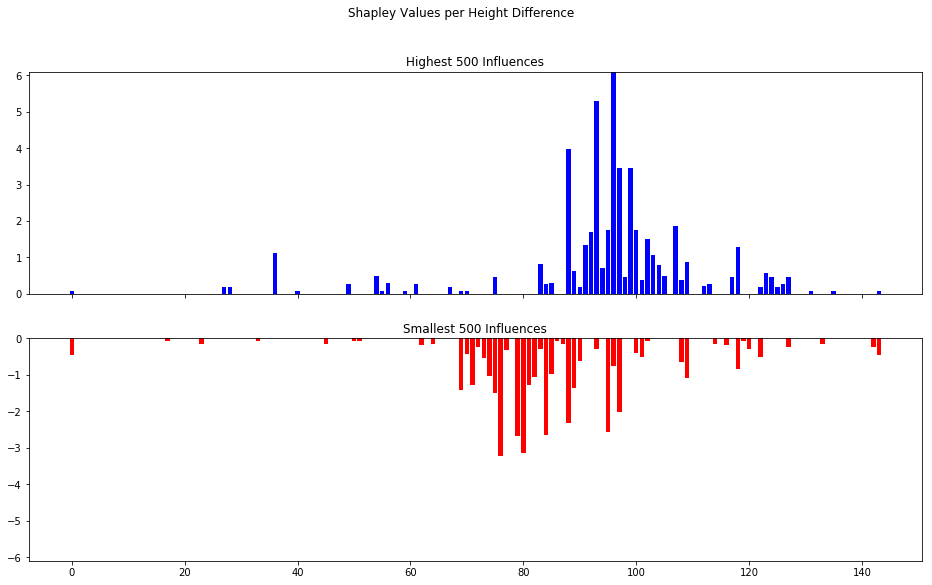

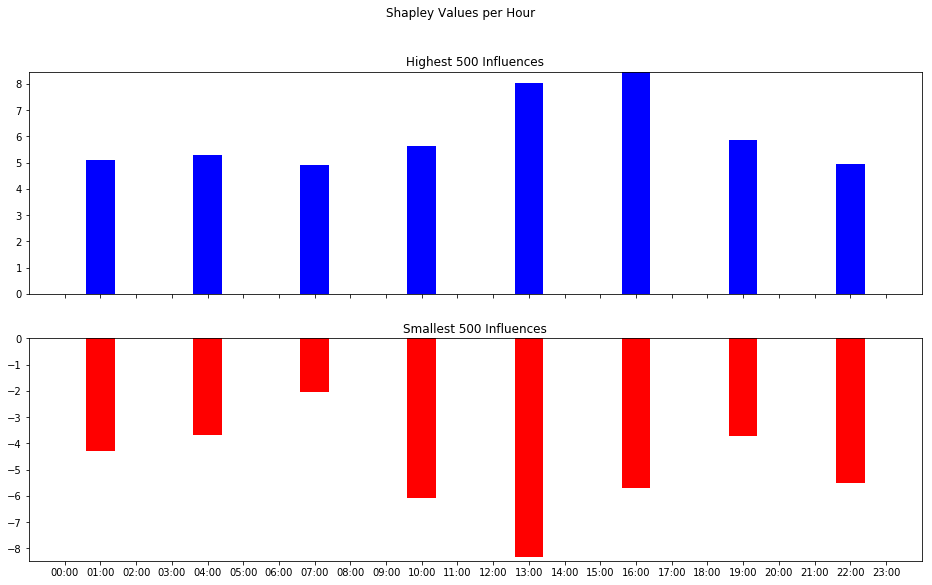

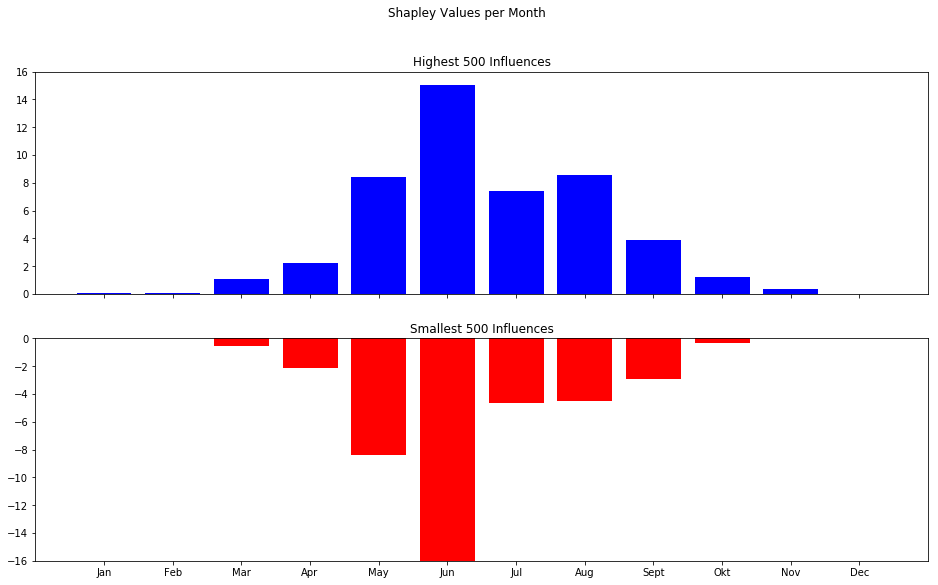

In [55]:
plotBestWorstShapleyResultsAllData(500, complete_shapley_sum)

### Plot shapley values against label

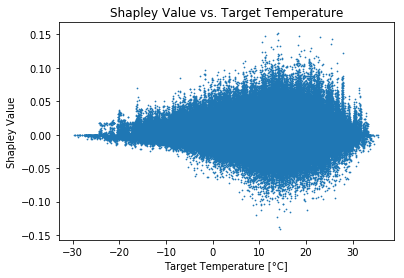

In [201]:
plt.scatter(Y_train_temp,complete_shapley_sum,s=0.5)
plt.xlabel('Target Temperature [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value vs. Target Temperature')
plt.show()

In [180]:
station_index_dict = {}
for s_idx, s in enumerate(absolute_model_error.station.data):
    station_index_dict[s] = s_idx

init_index_dict = {}
for i_idx, i in enumerate(absolute_model_error.init.data):
    init_index_dict[i] = i_idx

In [188]:
train_data_set_init_station = train_data_set[['Init', 'Station']]
absolute_model_error = np.absolute(prediction_error.run_0.sel(data = 'difference'))
model_error = np.zeros(train_data_set_init_station.shape[0])
for idx in train_data_set_init_station.index:
    init, station = train_data_set_init_station.iloc[idx]
    model_error[idx] = absolute_model_error.isel(init = init_index_dict[init], station = station_index_dict[station])
    if (idx + 1) % 1000 == 0:
        print("Samples processed: %s" % idx)

Samples processed: 999
Samples processed: 1999
Samples processed: 2999
Samples processed: 3999
Samples processed: 4999
Samples processed: 5999
Samples processed: 6999
Samples processed: 7999
Samples processed: 8999
Samples processed: 9999
Samples processed: 10999
Samples processed: 11999
Samples processed: 12999
Samples processed: 13999
Samples processed: 14999
Samples processed: 15999
Samples processed: 16999
Samples processed: 17999
Samples processed: 18999
Samples processed: 19999
Samples processed: 20999
Samples processed: 21999
Samples processed: 22999
Samples processed: 23999
Samples processed: 24999
Samples processed: 25999
Samples processed: 26999
Samples processed: 27999
Samples processed: 28999
Samples processed: 29999
Samples processed: 30999
Samples processed: 31999
Samples processed: 32999
Samples processed: 33999
Samples processed: 34999
Samples processed: 35999
Samples processed: 36999
Samples processed: 37999
Samples processed: 38999
Samples processed: 39999
Samples pro

Samples processed: 320999
Samples processed: 321999
Samples processed: 322999
Samples processed: 323999
Samples processed: 324999
Samples processed: 325999
Samples processed: 326999
Samples processed: 327999
Samples processed: 328999
Samples processed: 329999
Samples processed: 330999
Samples processed: 331999
Samples processed: 332999
Samples processed: 333999
Samples processed: 334999
Samples processed: 335999
Samples processed: 336999
Samples processed: 337999
Samples processed: 338999
Samples processed: 339999
Samples processed: 340999
Samples processed: 341999
Samples processed: 342999
Samples processed: 343999
Samples processed: 344999
Samples processed: 345999
Samples processed: 346999
Samples processed: 347999
Samples processed: 348999
Samples processed: 349999
Samples processed: 350999
Samples processed: 351999
Samples processed: 352999
Samples processed: 353999
Samples processed: 354999
Samples processed: 355999
Samples processed: 356999
Samples processed: 357999
Samples proc

Samples processed: 636999
Samples processed: 637999
Samples processed: 638999
Samples processed: 639999
Samples processed: 640999
Samples processed: 641999
Samples processed: 642999
Samples processed: 643999
Samples processed: 644999
Samples processed: 645999
Samples processed: 646999
Samples processed: 647999
Samples processed: 648999
Samples processed: 649999
Samples processed: 650999
Samples processed: 651999
Samples processed: 652999
Samples processed: 653999
Samples processed: 654999
Samples processed: 655999
Samples processed: 656999
Samples processed: 657999
Samples processed: 658999
Samples processed: 659999
Samples processed: 660999
Samples processed: 661999
Samples processed: 662999
Samples processed: 663999
Samples processed: 664999
Samples processed: 665999
Samples processed: 666999
Samples processed: 667999
Samples processed: 668999
Samples processed: 669999
Samples processed: 670999
Samples processed: 671999
Samples processed: 672999
Samples processed: 673999
Samples proc

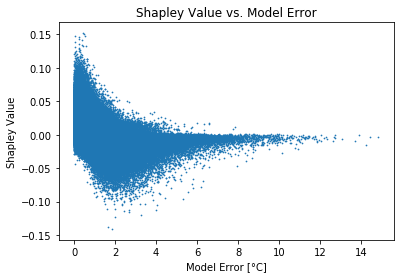

In [200]:
plt.scatter(model_error,complete_shapley_sum, s=0.5)
plt.xlabel('Model Error [°C]')
plt.ylabel('Shapley Value')
plt.title('Shapley Value vs. Model Error')
plt.show()

In [88]:
test_indices = [0, 102277, 51099, 81653, 22249, 23700, 97828, 68426]
actual_loss_diffs = {}
for test_index in test_indices:
    actual_loss_diffs[test_index] = run_knn([test_index], Y_train_temp, Y_test_temp)

Calculation of knn values for test idx=0 took 22.652302503585815
Calculation of knn values for test idx=102277 took 22.727498531341553
Calculation of knn values for test idx=51099 took 22.634960651397705
Calculation of knn values for test idx=81653 took 22.65362286567688
Calculation of knn values for test idx=22249 took 22.525287628173828
Calculation of knn values for test idx=23700 took 22.47892665863037
Calculation of knn values for test idx=97828 took 22.48391819000244
Calculation of knn values for test idx=68426 took 22.164478540420532


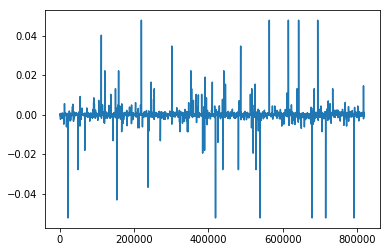

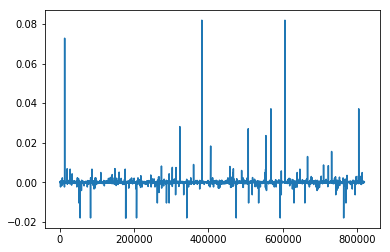

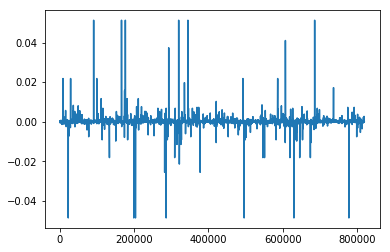

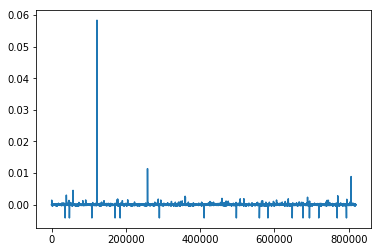

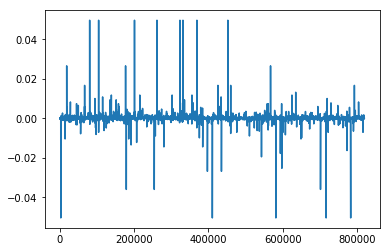

In [89]:
for key, value in actual_loss_diffs.items():
    plt.plot(value)
    plt.show()

In [ ]:
for key, value in actual_loss_diffs.items():
    init, station = test_data_set.iloc[key].as_matrix()[0:2]
    print(np.min(value), np.max(value))
    value = np.array(sorted(value))
    best_loss = np.argsort(value)
    fig = plt.figure(figsize=(16,9))
    
    # plot samples better than 0.005
    plt.plot(value[np.where(value >= 0.005)])
    plt.title('Test samples with Value >= 0.005 (best) for Station %s at Init %s' % (station , init))
    plt.show()
    plt.close()
    
    # plot samples worse thatn -0.005
    fig = plt.figure(figsize=(16,9))
    plt.plot(value[np.where(value <= -0.005)])
    plt.title('Test samples with Value <= -0.005 (worst) for Station %s at Init %s' % (station , init))
    plt.show()
    plt.close()

## Calculate Shapley Vales with different Bucket Sizes For July, 15:00, 2017 Data

In [12]:
july_15_15_00_indices = list(test_data_set.loc[(test_data_set['Init'].str.contains('1707..15'))].index)

In [50]:
test_data_set.loc[july_15_15_00_indices]

Init  Station         0    1    2         3    4         5  \
31      17070415       18  2.304683  0.0  0.0  0.000000  0.0  2.111537   
38      17070415      738  2.277055  0.0  0.0  0.000000  0.0  2.079044   
124     17070415      152  2.046664  0.0  0.0  0.000000  0.0  1.966487   
163     17070615       42  1.692284  0.0  0.0  0.000000  0.0  1.703321   
190     17070415       56  1.922184  0.0  0.0  0.000000  0.0  1.788197   
343     17070515     1024  2.467316  0.0  0.0  0.000000  0.0  2.270184   
385     17070615       85  2.839386  0.0  0.0  0.000000  0.0  2.638593   
492     17070515      139  0.923139  0.0  0.0  0.000000  0.0  0.896026   
565     17070615       58  2.745109  0.0  0.0  0.000000  0.0  2.542286   
951     17070615       11  2.557558  0.0  0.0  0.000000  0.0  2.360972   
1214    17070415      854  2.292260  0.0  0.0  0.000000  0.0  2.078609   
1277    17070415        8  1.900740  0.0  0.0  0.000000  0.0  1.804753   
1324    17070515       39  2.481644  0.0  0.0  0.000000  0.0  2.266097   
1368    17070515       91  1.332333  0.0  0.0  0.000000  0.0  1.380456   
1636    17070615      301  2.783582  0.0  0.0  0.000000  0.0  2.672561   
1781    17070515       56  2.293822  0.0  0.0  0.000000  0.0  2.180972   
1945    17070515       17  2.380708  0.0  0.0  0.000000  0.0  2.193850   
2295    17070515      842  2.447247  0.0  0.0  0.000000  0.0  2.355945   
2411    17070615       74  0.561342  0.0  0.0  0.000000  0.0  0.598026   
3056    17070615       72  1.774821  0.0  0.0  0.000000  0.0  1.697144   
3228    17070515      915  2.627367  0.0  0.0  0.000000  0.0  2.388432   
3523    17070515       27  2.578031  0.0  0.0  0.000000  0.0  2.386794   
3575    17070415       39  2.108826  0.0  0.0  0.000000  0.0  1.962122   
3842    17070615       13  2.268241  0.0  0.0  0.000000  0.0  2.150772   
3977    17070415       96  1.172078  0.0  0.0  0.000000  0.0  1.180325   
4613    17070615        7  2.544454  0.0  0.0  0.000000  0.0  2.414812   
4762    17070615       95  2.170748  0.0  0.0  0.000000  0.0  2.120779   
5807    17070615       27  2.667728  0.0  0.0  0.000000  0.0  2.505895   
6268    17070615      748  2.453122  0.0  0.0  0.000000  0.0  2.309866   
6638    17070415       17  2.079128  0.0  0.0  0.000000  0.0  1.970713   
...          ...      ...       ...  ...  ...       ...  ...       ...   
95955   17070615       41  2.051654  0.0  0.0  0.000000  0.0  1.950383   
96107   17070515       79  2.320648  0.0  0.0  0.000000  0.0  2.181972   
97267   17070615       45  2.130960  0.0  0.0  0.000000  0.0  2.111701   
97646   17070615      852  2.157003  0.0  0.0  0.000000  0.0  2.096859   
97667   17070415       71  2.238311  0.0  0.0  0.000000  0.0  2.064274   
97769   17070515      762  2.215254  0.0  0.0  0.000000  0.0  2.125176   
97884   17070515      409  1.559092  0.0  0.0  0.000000  0.0  1.539314   
97927   17070515      317  1.839146  0.0  0.0  0.000000  0.0  1.853781   
98169   17070615       50  2.699893  0.0  0.0  0.000000  0.0  2.411073   
98672   17070415       41  1.812762  0.0  0.0  0.000000  0.0  1.729780   
99299   17070415       53  2.244060  0.0  0.0  0.000000  0.0  2.039129   
99455   17070515      866  0.699688  0.0  0.0  0.008018  0.0  0.705343   
99647   17070515       32  2.544048  0.0  0.0  0.000000  0.0  2.413207   
99873   17070615      414  1.338039  0.0  0.0  0.000000  0.0  1.369712   
99968   17070415     1118  1.704842  0.0  0.0  0.000000  0.0  1.621839   
100099  17070415      861  1.444177  0.0  0.0  0.000000  0.0  1.369372   
100251  17070515       95  2.047066  0.0  0.0  0.000000  0.0  2.019222   
100260  17070515       87  1.560179  0.0  0.0  0.000000  0.0  1.509985   
100330  17070615      856  0.897319  0.0  0.0  0.000000  0.0  0.921721   
100400  17070415       85  2.404657  0.0  0.0  0.000000  0.0  2.236218   
100788  17070515       10  1.788552  0.0  0.0  0.000000  0.0  1.807375   
100821  17070415       62  1.024280  0.0  0.0  0.004390  0.0  1.067395   
101023  17070515

In [47]:
july_15_15_00_indices

[31,
 38,
 124,
 163,
 190,
 343,
 385,
 492,
 565,
 951,
 1214,
 1277,
 1324,
 1368,
 1636,
 1781,
 1945,
 2295,
 2411,
 3056,
 3228,
 3523,
 3575,
 3842,
 3977,
 4613,
 4762,
 5807,
 6268,
 6638,
 6931,
 7051,
 7412,
 7643,
 7693,
 7984,
 8226,
 8252,
 8352,
 8819,
 8847,
 8892,
 9904,
 10327,
 10374,
 10375,
 10461,
 10538,
 10805,
 11276,
 11828,
 12084,
 12898,
 14043,
 14090,
 14129,
 14160,
 14601,
 14770,
 14815,
 14826,
 14871,
 15028,
 15239,
 15806,
 15842,
 15922,
 16467,
 16469,
 16489,
 16840,
 16941,
 17009,
 17116,
 17255,
 17751,
 18549,
 18564,
 18595,
 18603,
 18694,
 19317,
 19654,
 19673,
 20452,
 20458,
 20465,
 20722,
 21049,
 21184,
 21187,
 21936,
 22180,
 22278,
 22437,
 22660,
 22772,
 22790,
 22908,
 22994,
 23462,
 23742,
 23753,
 24129,
 24159,
 24198,
 24393,
 24409,
 24518,
 24524,
 25013,
 25088,
 25111,
 25513,
 25858,
 25966,
 25985,
 26133,
 26394,
 26436,
 26530,
 26673,
 26677,
 26701,
 26776,
 26833,
 26855,
 27013,
 27143,
 27717,
 27735,
 28259,

### Calculate shapley values in parallel for different bucket sizes

In [35]:
shapley_results = []
with Pool(processes=6) as pool:
    process_results = []
    for b_size in [0.1, 0.3 ,0.5, 1, 2, 5]:
        process_results.append(pool.apply_async(get_knn_shapley_values, (Y_train_temp, Y_test_temp, july_15_15_00_indices, b_size)))
        
            # aggregate results from all processes
    for ps_idx, ps_result in enumerate(process_results):
        # sync processes
        x = ps_result.get()
        shapley_results += [x]
        print('[Process %s] Synchronized after calculating shapley values.' % ps_idx)

652
218
131
66
33
14
Calculation of knn values for test idx=31 took 13.981414079666138
Calculation of knn values for test idx=31 took 14.045355796813965
Calculation of knn values for test idx=31 took 14.066136598587036
Calculation of knn values for test idx=31 took 14.10547685623169
Calculation of knn values for test idx=31 took 14.092230081558228
Calculation of knn values for test idx=31 took 14.14746356010437
Calculation of knn values for test idx=38 took 13.90942645072937
Calculation of knn values for test idx=38 took 14.044825315475464
Calculation of knn values for test idx=38 took 13.930566787719727
Calculation of knn values for test idx=38 took 14.00996994972229
Calculation of knn values for test idx=38 took 13.879767179489136
Calculation of knn values for test idx=38 took 13.990448713302612
Calculation of knn values for test idx=124 took 13.909296035766602
Calculation of knn values for test idx=124 took 13.907620668411255
Calculation of knn values for test idx=124 took 13.969815

Calculation of knn values for test idx=3228 took 13.994871139526367
Calculation of knn values for test idx=3228 took 14.02783751487732
Calculation of knn values for test idx=3228 took 14.208324909210205
Calculation of knn values for test idx=3228 took 14.201080799102783
Calculation of knn values for test idx=3523 took 13.904261350631714
Calculation of knn values for test idx=3523 took 13.95070195198059
Calculation of knn values for test idx=3523 took 14.145534992218018
Calculation of knn values for test idx=3523 took 14.059216737747192
Calculation of knn values for test idx=3523 took 14.198912382125854
Calculation of knn values for test idx=3523 took 14.133382797241211
Calculation of knn values for test idx=3575 took 13.967112064361572
Calculation of knn values for test idx=3575 took 13.981976985931396
Calculation of knn values for test idx=3575 took 14.048356533050537
Calculation of knn values for test idx=3575 took 14.039143323898315
Calculation of knn values for test idx=3575 took 1

Calculation of knn values for test idx=8847 took 14.087199449539185
Calculation of knn values for test idx=8847 took 14.284892797470093
Calculation of knn values for test idx=8847 took 14.369713306427002
Calculation of knn values for test idx=8892 took 13.865864038467407
Calculation of knn values for test idx=8892 took 13.928966760635376
Calculation of knn values for test idx=8892 took 14.020714282989502
Calculation of knn values for test idx=8892 took 14.0542151927948
Calculation of knn values for test idx=8892 took 14.108044624328613
Calculation of knn values for test idx=8892 took 14.259035110473633
Calculation of knn values for test idx=9904 took 14.185237169265747
Calculation of knn values for test idx=9904 took 14.054656267166138
Calculation of knn values for test idx=9904 took 14.189588069915771
Calculation of knn values for test idx=9904 took 14.098163366317749
Calculation of knn values for test idx=9904 took 14.375105857849121
Calculation of knn values for test idx=9904 took 1

Calculation of knn values for test idx=14826 took 14.016820669174194
Calculation of knn values for test idx=14826 took 14.174134016036987
Calculation of knn values for test idx=14871 took 13.872391700744629
Calculation of knn values for test idx=14871 took 14.061853647232056
Calculation of knn values for test idx=14826 took 14.191171407699585
Calculation of knn values for test idx=14871 took 13.929647207260132
Calculation of knn values for test idx=14871 took 13.979967832565308
Calculation of knn values for test idx=14871 took 14.061436176300049
Calculation of knn values for test idx=15028 took 13.997895002365112
Calculation of knn values for test idx=15028 took 13.93201494216919
Calculation of knn values for test idx=14871 took 14.20447039604187
Calculation of knn values for test idx=15028 took 13.917829751968384
Calculation of knn values for test idx=15028 took 13.95125436782837
Calculation of knn values for test idx=15028 took 14.092067003250122
Calculation of knn values for test id

Calculation of knn values for test idx=18694 took 14.231355428695679
Calculation of knn values for test idx=19317 took 13.812077760696411
Calculation of knn values for test idx=18694 took 13.96105170249939
Calculation of knn values for test idx=19317 took 13.981223821640015
Calculation of knn values for test idx=18694 took 14.342029333114624
Calculation of knn values for test idx=19317 took 13.905273675918579
Calculation of knn values for test idx=19317 took 14.139461755752563
Calculation of knn values for test idx=19654 took 13.870035648345947
Calculation of knn values for test idx=19317 took 14.034963846206665
Calculation of knn values for test idx=19654 took 14.002539873123169
Calculation of knn values for test idx=19317 took 14.057538509368896
Calculation of knn values for test idx=19654 took 14.066528081893921
Calculation of knn values for test idx=19654 took 14.156248807907104
Calculation of knn values for test idx=19673 took 13.91830563545227
Calculation of knn values for test i

Calculation of knn values for test idx=23462 took 14.17307162284851
Calculation of knn values for test idx=23742 took 13.793415307998657
Calculation of knn values for test idx=23742 took 13.942115068435669
Calculation of knn values for test idx=23462 took 14.102632999420166
Calculation of knn values for test idx=23742 took 13.979531049728394
Calculation of knn values for test idx=23462 took 14.218510866165161
Calculation of knn values for test idx=23742 took 14.031561613082886
Calculation of knn values for test idx=23753 took 13.902258157730103
Calculation of knn values for test idx=23753 took 14.053365707397461
Calculation of knn values for test idx=23742 took 14.105712175369263
Calculation of knn values for test idx=23753 took 14.007735013961792
Calculation of knn values for test idx=23742 took 14.218128681182861
Calculation of knn values for test idx=23753 took 14.152866840362549
Calculation of knn values for test idx=24129 took 13.915332078933716
Calculation of knn values for test 

Calculation of knn values for test idx=26673 took 13.926354169845581
Calculation of knn values for test idx=26436 took 14.113143682479858
Calculation of knn values for test idx=26530 took 14.313814640045166
Calculation of knn values for test idx=26673 took 13.867821455001831
Calculation of knn values for test idx=26530 took 14.07595443725586
Calculation of knn values for test idx=26673 took 14.022254943847656
Calculation of knn values for test idx=26677 took 13.905446290969849
Calculation of knn values for test idx=26530 took 14.169543981552124
Calculation of knn values for test idx=26673 took 14.134637355804443
Calculation of knn values for test idx=26677 took 13.98011040687561
Calculation of knn values for test idx=26673 took 14.138262510299683
Calculation of knn values for test idx=26677 took 14.005600929260254
Calculation of knn values for test idx=26701 took 13.874114274978638
Calculation of knn values for test idx=26673 took 14.182539463043213
Calculation of knn values for test i

Calculation of knn values for test idx=30660 took 13.927821397781372
Calculation of knn values for test idx=30636 took 14.167584419250488
Calculation of knn values for test idx=30660 took 14.12020993232727
Calculation of knn values for test idx=30603 took 14.254243850708008
Calculation of knn values for test idx=30636 took 14.347129106521606
Calculation of knn values for test idx=30636 took 14.270747661590576
Calculation of knn values for test idx=31583 took 13.955782890319824
Calculation of knn values for test idx=30660 took 13.994874715805054
Calculation of knn values for test idx=31583 took 14.203281879425049
Calculation of knn values for test idx=30636 took 14.348106861114502
Calculation of knn values for test idx=30660 took 14.143627643585205
Calculation of knn values for test idx=30660 took 14.222946405410767
Calculation of knn values for test idx=31798 took 13.834959506988525
Calculation of knn values for test idx=31583 took 14.101842403411865
Calculation of knn values for test 

Calculation of knn values for test idx=34789 took 14.177186965942383
Calculation of knn values for test idx=35083 took 13.984638690948486
Calculation of knn values for test idx=35130 took 13.973324060440063
Calculation of knn values for test idx=35193 took 13.992884159088135
Calculation of knn values for test idx=35083 took 14.166645288467407
Calculation of knn values for test idx=34789 took 14.201488494873047
Calculation of knn values for test idx=35083 took 14.094075679779053
Calculation of knn values for test idx=35130 took 13.957898616790771
Calculation of knn values for test idx=35193 took 14.08987545967102
Calculation of knn values for test idx=35509 took 13.970937967300415
Calculation of knn values for test idx=35130 took 14.273603677749634
Calculation of knn values for test idx=35083 took 14.201371431350708
Calculation of knn values for test idx=35130 took 14.174405574798584
Calculation of knn values for test idx=35193 took 14.151089429855347
Calculation of knn values for test 

Calculation of knn values for test idx=39837 took 14.20229983329773
Calculation of knn values for test idx=40442 took 14.085368871688843
Calculation of knn values for test idx=41017 took 14.040774822235107
Calculation of knn values for test idx=41258 took 13.860467195510864
Calculation of knn values for test idx=41017 took 13.89157485961914
Calculation of knn values for test idx=40442 took 14.185219049453735
Calculation of knn values for test idx=39846 took 14.068472623825073
Calculation of knn values for test idx=40442 took 14.107861518859863
Calculation of knn values for test idx=41258 took 13.930189371109009
Calculation of knn values for test idx=41447 took 13.958913564682007
Calculation of knn values for test idx=41258 took 14.001713514328003
Calculation of knn values for test idx=41017 took 13.974030017852783
Calculation of knn values for test idx=41017 took 14.04217004776001
Calculation of knn values for test idx=40442 took 14.417787075042725
Calculation of knn values for test id

Calculation of knn values for test idx=46552 took 14.096711158752441
Calculation of knn values for test idx=46145 took 14.171004295349121
Calculation of knn values for test idx=46781 took 13.935086965560913
Calculation of knn values for test idx=46801 took 13.943005561828613
Calculation of knn values for test idx=46781 took 14.163726329803467
Calculation of knn values for test idx=46664 took 14.185818433761597
Calculation of knn values for test idx=46664 took 14.191923141479492
Calculation of knn values for test idx=46552 took 14.14510202407837
Calculation of knn values for test idx=46801 took 13.913091659545898
Calculation of knn values for test idx=46814 took 14.071167945861816
Calculation of knn values for test idx=46801 took 14.078937768936157
Calculation of knn values for test idx=46781 took 14.202224254608154
Calculation of knn values for test idx=46781 took 14.233271360397339
Calculation of knn values for test idx=46664 took 14.222271203994751
Calculation of knn values for test 

Calculation of knn values for test idx=49653 took 13.855733156204224
Calculation of knn values for test idx=49161 took 14.09725546836853
Calculation of knn values for test idx=49161 took 14.219212532043457
Calculation of knn values for test idx=49148 took 14.203725337982178
Calculation of knn values for test idx=49396 took 13.959152460098267
Calculation of knn values for test idx=49653 took 13.901348114013672
Calculation of knn values for test idx=49673 took 13.965317249298096
Calculation of knn values for test idx=49345 took 14.193376064300537
Calculation of knn values for test idx=49345 took 14.126476049423218
Calculation of knn values for test idx=49161 took 14.184252500534058
Calculation of knn values for test idx=49653 took 13.9921293258667
Calculation of knn values for test idx=49673 took 13.952749729156494
Calculation of knn values for test idx=49844 took 13.940366268157959
Calculation of knn values for test idx=49396 took 14.031649589538574
Calculation of knn values for test id

Calculation of knn values for test idx=52868 took 14.155664443969727
Calculation of knn values for test idx=52848 took 14.114547729492188
Calculation of knn values for test idx=52570 took 14.164678812026978
Calculation of knn values for test idx=52570 took 14.382735967636108
Calculation of knn values for test idx=52139 took 14.141699314117432
Calculation of knn values for test idx=52848 took 14.113330602645874
Calculation of knn values for test idx=53170 took 14.015695095062256
Calculation of knn values for test idx=52868 took 14.184578895568848
Calculation of knn values for test idx=52776 took 14.15435266494751
Calculation of knn values for test idx=52776 took 14.128430843353271
Calculation of knn values for test idx=52570 took 14.203439474105835
Calculation of knn values for test idx=52868 took 14.173017978668213
Calculation of knn values for test idx=53397 took 13.998210668563843
Calculation of knn values for test idx=53170 took 13.909724950790405
Calculation of knn values for test 

Calculation of knn values for test idx=57569 took 13.955200433731079
Calculation of knn values for test idx=57171 took 14.200057744979858
Calculation of knn values for test idx=56833 took 14.35561990737915
Calculation of knn values for test idx=56833 took 14.306735277175903
Calculation of knn values for test idx=56730 took 14.376658201217651
Calculation of knn values for test idx=57171 took 14.103048324584961
Calculation of knn values for test idx=57898 took 13.950543642044067
Calculation of knn values for test idx=57569 took 14.043386220932007
Calculation of knn values for test idx=57023 took 14.264458894729614
Calculation of knn values for test idx=57023 took 14.160983800888062
Calculation of knn values for test idx=56833 took 14.305267572402954
Calculation of knn values for test idx=57569 took 13.99946665763855
Calculation of knn values for test idx=57966 took 13.953253269195557
Calculation of knn values for test idx=57898 took 14.011327743530273
Calculation of knn values for test i

Calculation of knn values for test idx=59935 took 14.174070835113525
Calculation of knn values for test idx=60594 took 13.997350692749023
Calculation of knn values for test idx=60008 took 14.020656824111938
Calculation of knn values for test idx=60008 took 14.060126543045044
Calculation of knn values for test idx=60757 took 13.957168102264404
Calculation of knn values for test idx=60594 took 14.070631265640259
Calculation of knn values for test idx=59996 took 14.183012247085571
Calculation of knn values for test idx=60652 took 14.086775779724121
Calculation of knn values for test idx=60252 took 14.13455867767334
Calculation of knn values for test idx=60252 took 14.125495195388794
Calculation of knn values for test idx=60799 took 13.934169292449951
Calculation of knn values for test idx=60652 took 14.09520697593689
Calculation of knn values for test idx=60008 took 14.219977378845215
Calculation of knn values for test idx=60757 took 14.012168645858765
Calculation of knn values for test i

Calculation of knn values for test idx=64185 took 13.971418857574463
Calculation of knn values for test idx=63623 took 14.120918989181519
Calculation of knn values for test idx=64130 took 14.017231941223145
Calculation of knn values for test idx=64130 took 14.156764268875122
Calculation of knn values for test idx=64710 took 13.85461688041687
Calculation of knn values for test idx=64185 took 14.08912205696106
Calculation of knn values for test idx=64334 took 13.86111855506897
Calculation of knn values for test idx=64060 took 14.151580810546875
Calculation of knn values for test idx=64148 took 14.173924684524536
Calculation of knn values for test idx=64148 took 14.148632287979126
Calculation of knn values for test idx=64993 took 14.131269216537476
Calculation of knn values for test idx=64334 took 14.067212581634521
Calculation of knn values for test idx=64710 took 13.92288088798523
Calculation of knn values for test idx=64130 took 14.121369361877441
Calculation of knn values for test idx

Calculation of knn values for test idx=70034 took 14.193193912506104
Calculation of knn values for test idx=69212 took 14.12802267074585
Calculation of knn values for test idx=70197 took 14.027758121490479
Calculation of knn values for test idx=70034 took 14.098767280578613
Calculation of knn values for test idx=69445 took 13.970536231994629
Calculation of knn values for test idx=69445 took 14.032868146896362
Calculation of knn values for test idx=70053 took 14.127717733383179
Calculation of knn values for test idx=69416 took 14.244647026062012
Calculation of knn values for test idx=70366 took 13.915585279464722
Calculation of knn values for test idx=69498 took 14.080015659332275
Calculation of knn values for test idx=70053 took 14.126909255981445
Calculation of knn values for test idx=69498 took 14.149389743804932
Calculation of knn values for test idx=70197 took 14.023674249649048
Calculation of knn values for test idx=69445 took 14.223079681396484
Calculation of knn values for test 

Calculation of knn values for test idx=77745 took 14.181309223175049
Calculation of knn values for test idx=77745 took 14.070488929748535
Calculation of knn values for test idx=79355 took 13.868810176849365
Calculation of knn values for test idx=77208 took 14.127840280532837
Calculation of knn values for test idx=78140 took 14.049024105072021
Calculation of knn values for test idx=78921 took 14.081074953079224
Calculation of knn values for test idx=77768 took 14.231054544448853
Calculation of knn values for test idx=77768 took 14.185341835021973
Calculation of knn values for test idx=79594 took 13.927908182144165
Calculation of knn values for test idx=77745 took 14.184157848358154
Calculation of knn values for test idx=79355 took 13.837308883666992
Calculation of knn values for test idx=78921 took 14.10050892829895
Calculation of knn values for test idx=77813 took 14.199437856674194
Calculation of knn values for test idx=77813 took 14.189485549926758
Calculation of knn values for test 

Calculation of knn values for test idx=83736 took 14.130474090576172
Calculation of knn values for test idx=83736 took 14.082549810409546
Calculation of knn values for test idx=84622 took 13.876376867294312
Calculation of knn values for test idx=84560 took 13.99024486541748
Calculation of knn values for test idx=84536 took 14.000058650970459
Calculation of knn values for test idx=83611 took 14.03362774848938
Calculation of knn values for test idx=83840 took 14.046716928482056
Calculation of knn values for test idx=83840 took 14.050714492797852
Calculation of knn values for test idx=85350 took 13.959270000457764
Calculation of knn values for test idx=84622 took 13.9867684841156
Calculation of knn values for test idx=84560 took 13.95762825012207
Calculation of knn values for test idx=83736 took 14.124207496643066
Calculation of knn values for test idx=84168 took 14.088778018951416
Calculation of knn values for test idx=84168 took 14.035252571105957
Calculation of knn values for test idx=

Calculation of knn values for test idx=89192 took 14.317070484161377
Calculation of knn values for test idx=89192 took 14.121250629425049
Calculation of knn values for test idx=90909 took 14.05582332611084
Calculation of knn values for test idx=90685 took 14.032534837722778
Calculation of knn values for test idx=90411 took 13.997517347335815
Calculation of knn values for test idx=89181 took 14.201815843582153
Calculation of knn values for test idx=89752 took 14.126618385314941
Calculation of knn values for test idx=89752 took 14.15358829498291
Calculation of knn values for test idx=91224 took 14.037030458450317
Calculation of knn values for test idx=90909 took 13.905249834060669
Calculation of knn values for test idx=90685 took 14.069595575332642
Calculation of knn values for test idx=89192 took 14.21161437034607
Calculation of knn values for test idx=90102 took 14.194852352142334
Calculation of knn values for test idx=90102 took 14.155025005340576
Calculation of knn values for test id

Calculation of knn values for test idx=97667 took 13.85387659072876
Calculation of knn values for test idx=95669 took 14.343503713607788
Calculation of knn values for test idx=95669 took 14.270027160644531
Calculation of knn values for test idx=95336 took 14.358415603637695
Calculation of knn values for test idx=97646 took 14.115313053131104
Calculation of knn values for test idx=97267 took 13.896397113800049
Calculation of knn values for test idx=97769 took 13.981299877166748
Calculation of knn values for test idx=95955 took 14.25223159790039
Calculation of knn values for test idx=95955 took 14.234887838363647
Calculation of knn values for test idx=95455 took 14.294239044189453
Calculation of knn values for test idx=97667 took 14.06854510307312
Calculation of knn values for test idx=97646 took 14.031575918197632
Calculation of knn values for test idx=97884 took 13.931118249893188
Calculation of knn values for test idx=96107 took 14.191009998321533
Calculation of knn values for test id

Calculation of knn values for test idx=100251 took 14.14320683479309
Calculation of knn values for test idx=101980 took 13.840908527374268
Calculation of knn values for test idx=100400 took 14.218291759490967
Calculation of knn values for test idx=100400 took 14.189717769622803
Calculation of knn values for test idx=101072 took 13.908370018005371
Calculation of knn values for test idx=101023 took 13.895794153213501
Calculation of knn values for test idx=100260 took 14.389333486557007
Calculation of knn values for test idx=101982 took 14.02851128578186
Calculation of knn values for test idx=100788 took 14.060115098953247
Calculation of knn values for test idx=100788 took 14.1356201171875
Calculation of knn values for test idx=101980 took 13.935867547988892
Calculation of knn values for test idx=101072 took 13.983401775360107
Calculation of knn values for test idx=100330 took 14.24559211730957
Calculation of knn values for test idx=102647 took 13.979838371276855
Calculation of knn values

In [54]:
shapley_results[0][1].shape

(819522,)

Bucket size:  0.1


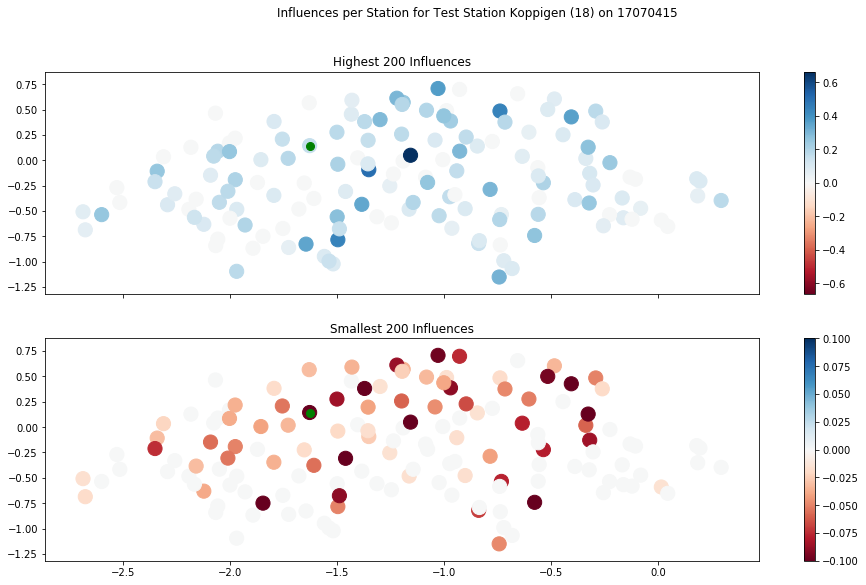

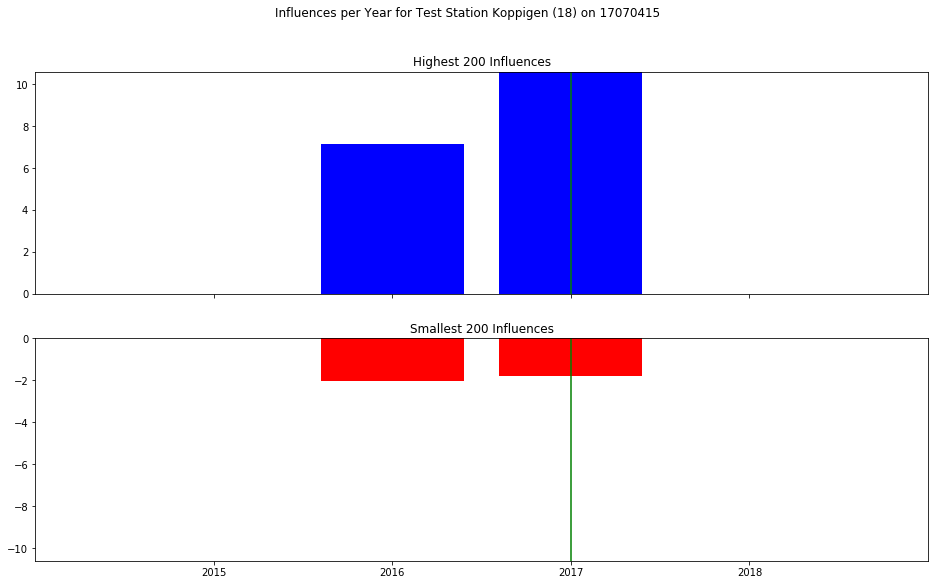

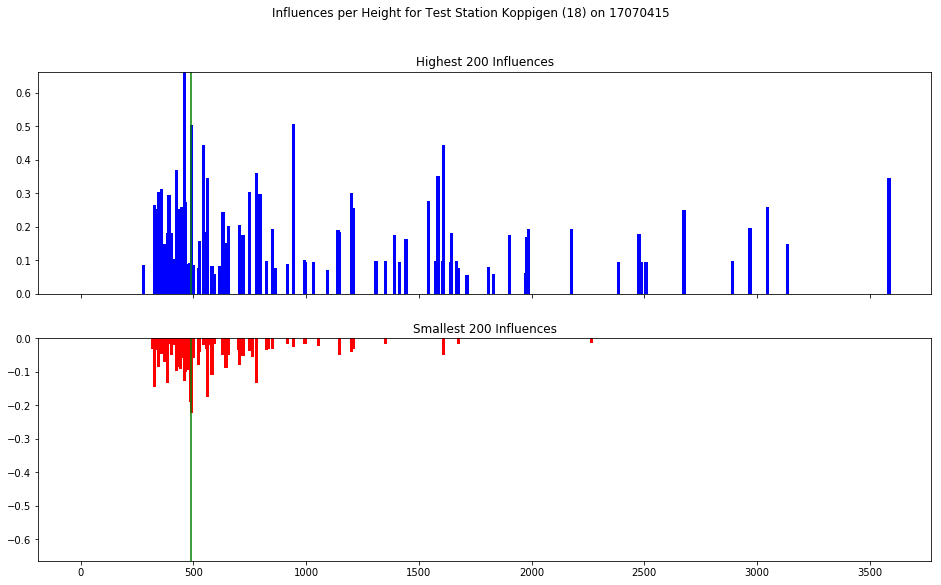

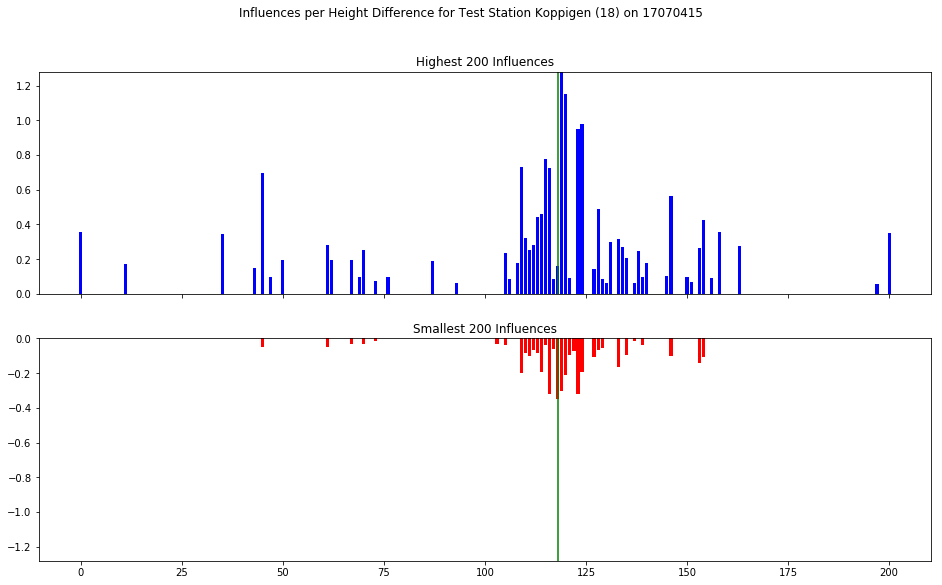

Bucket size:  0.3


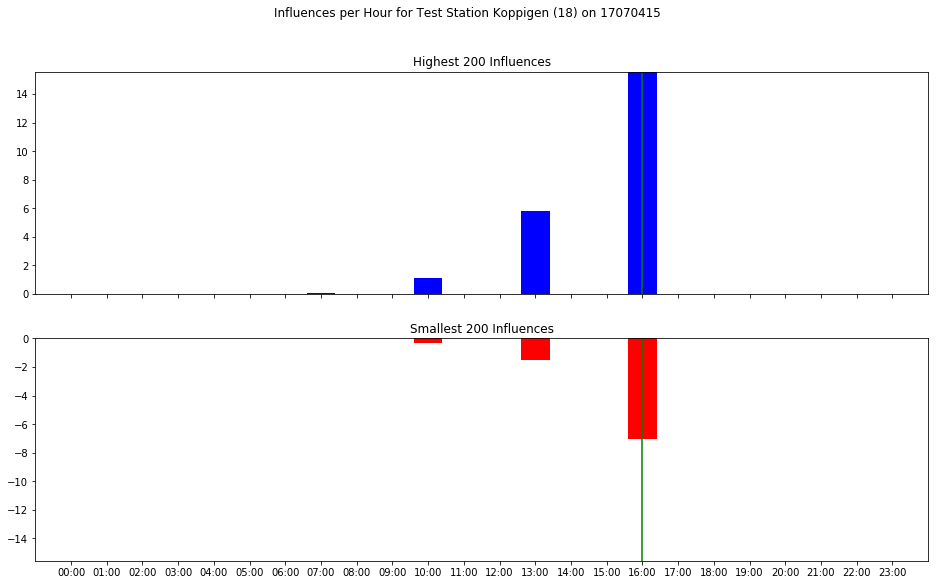

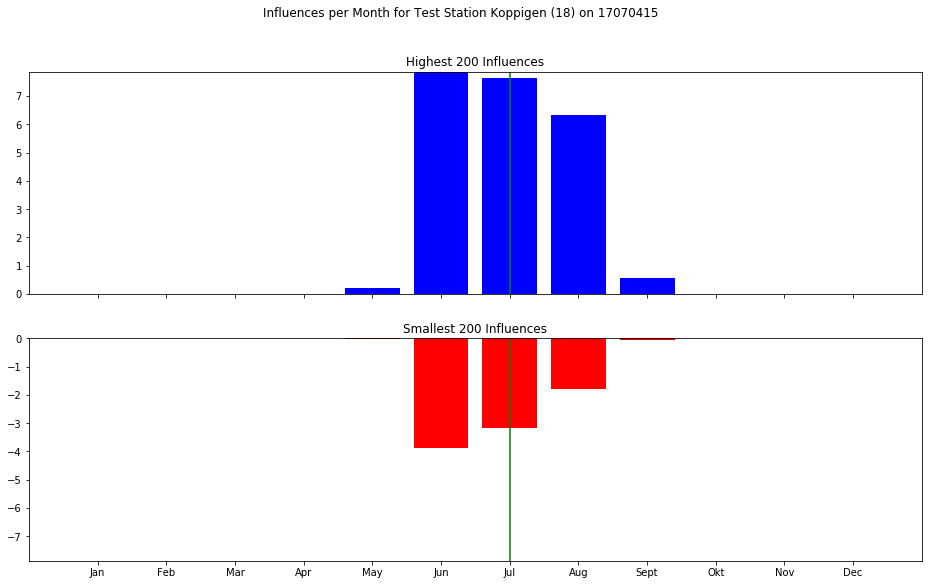

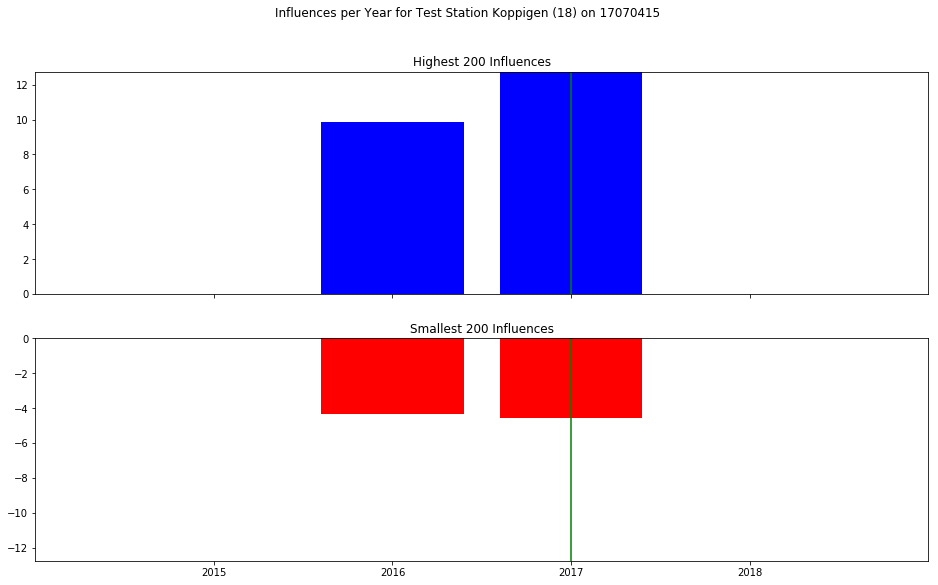

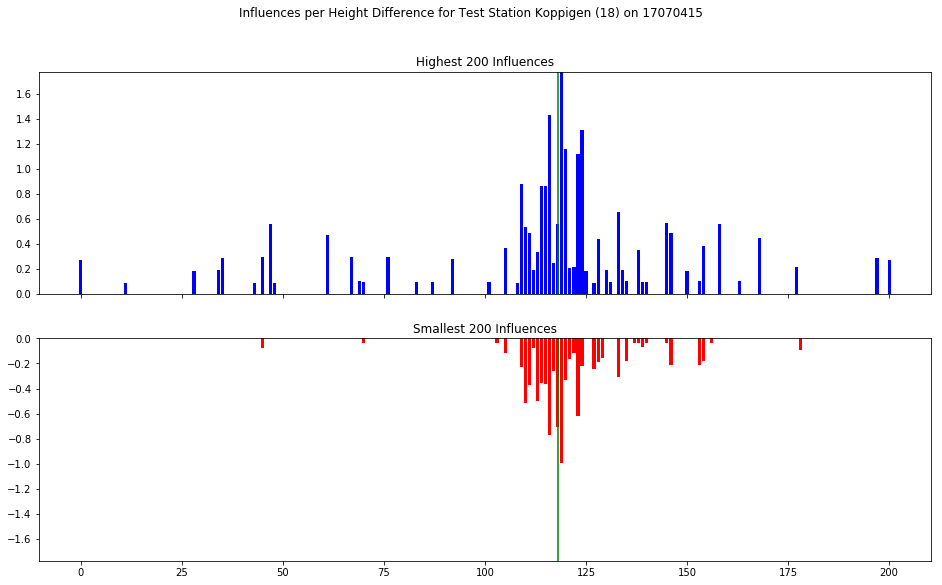

Bucket size:  0.5


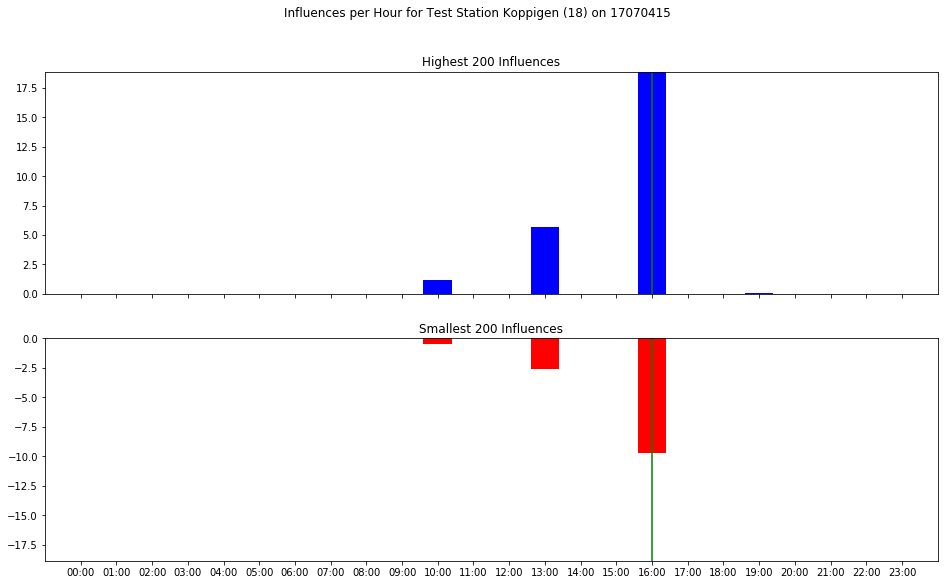

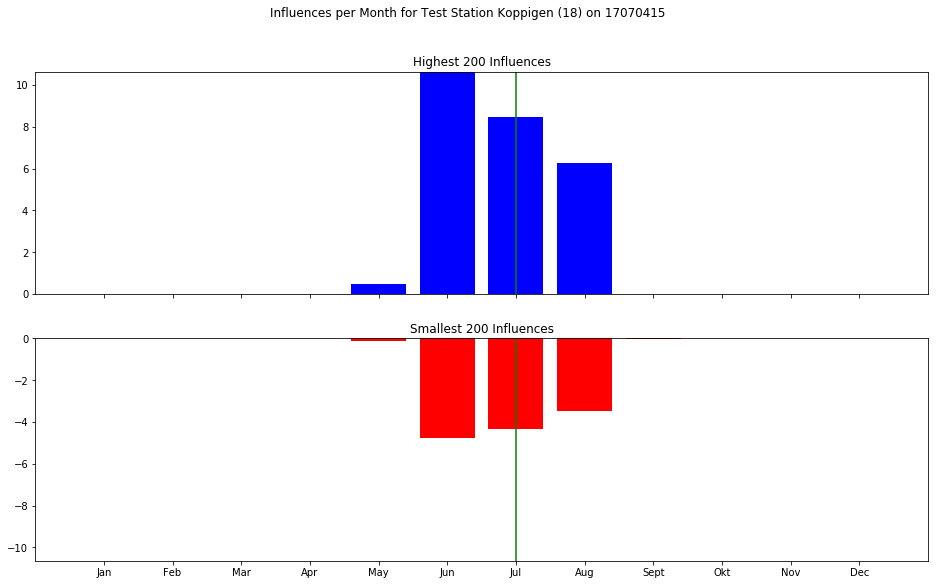

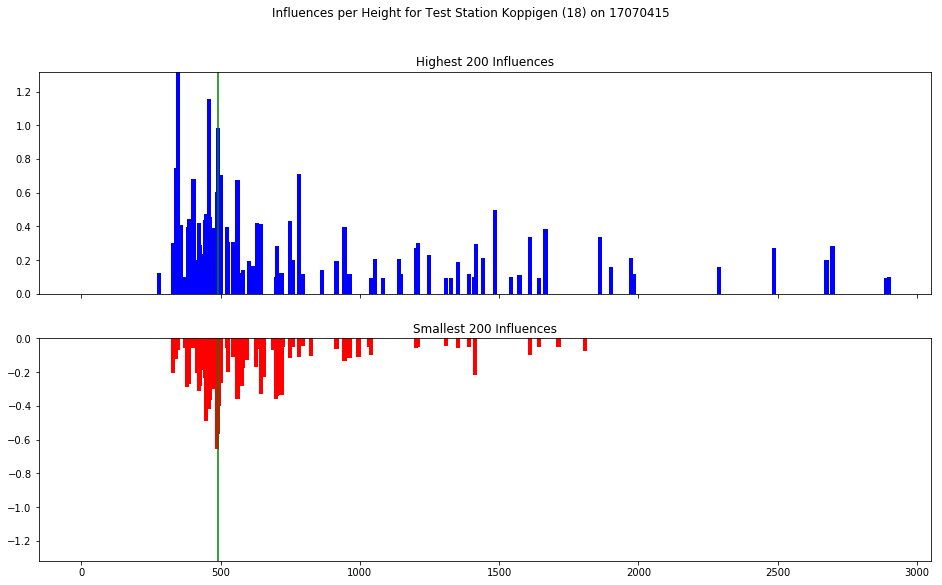

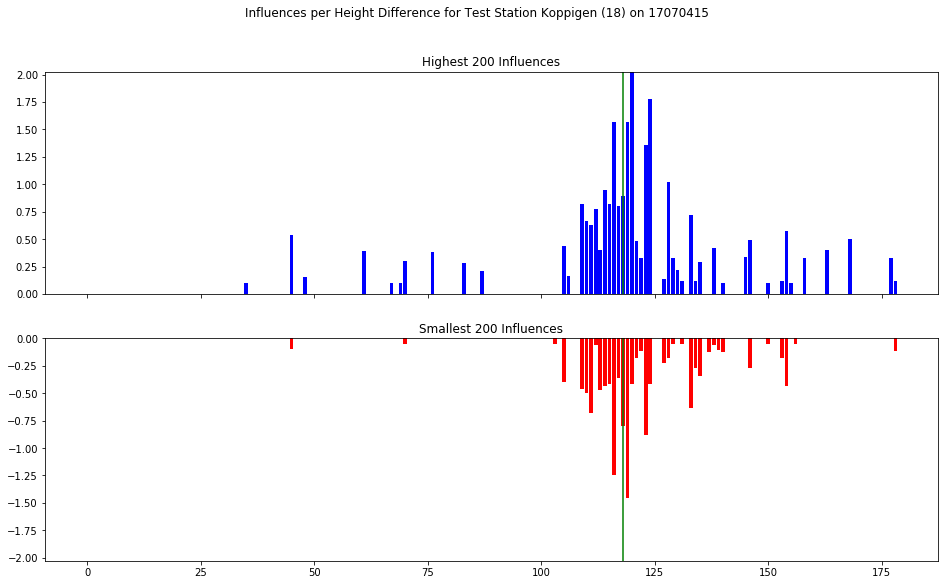

Bucket size:  1


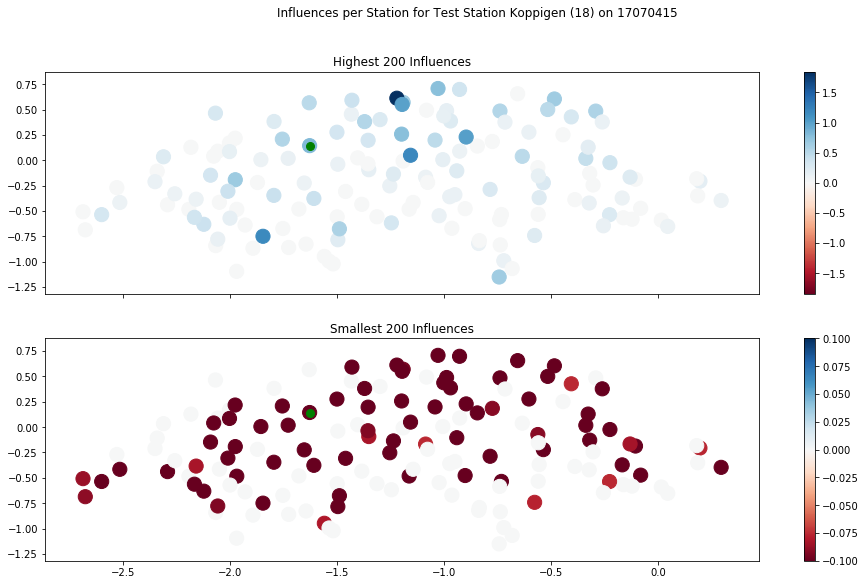

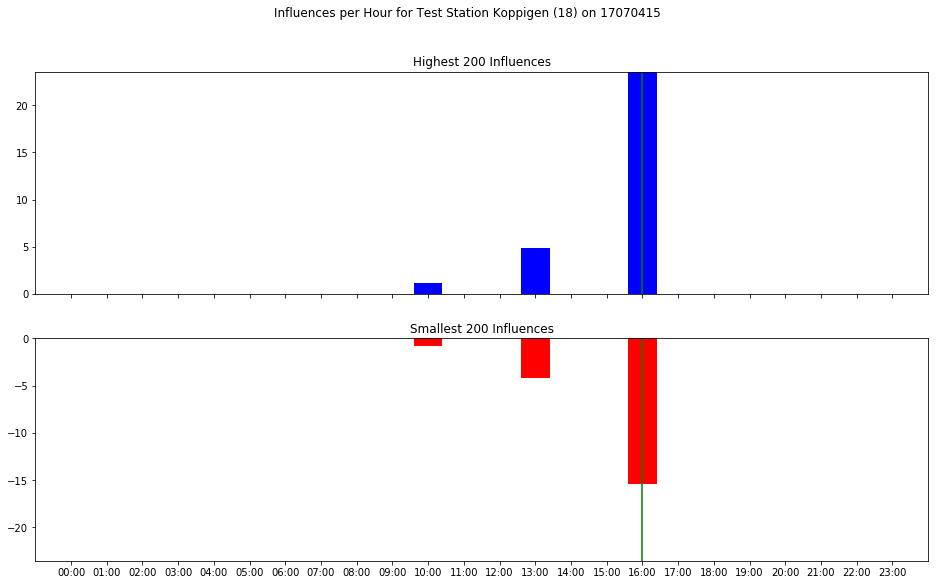

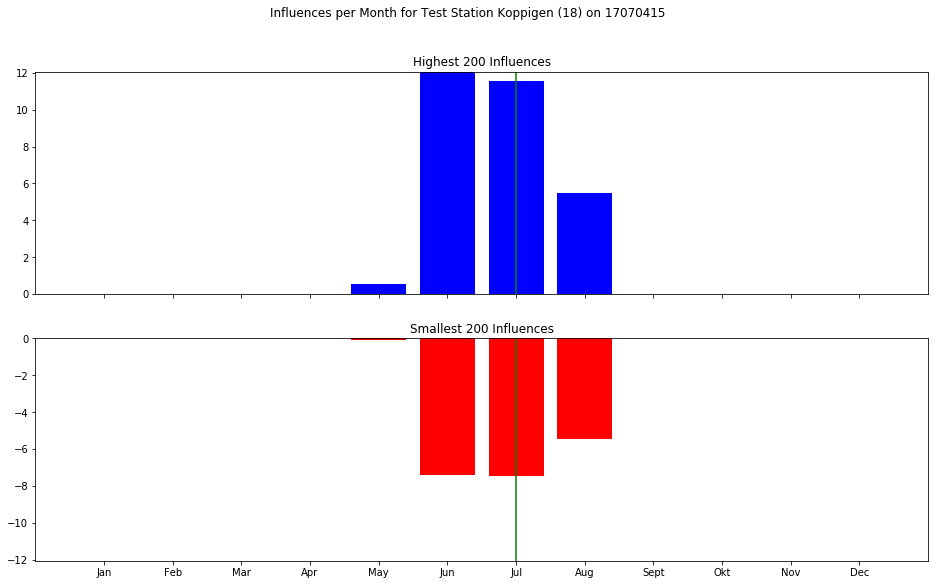

Bucket size:  2


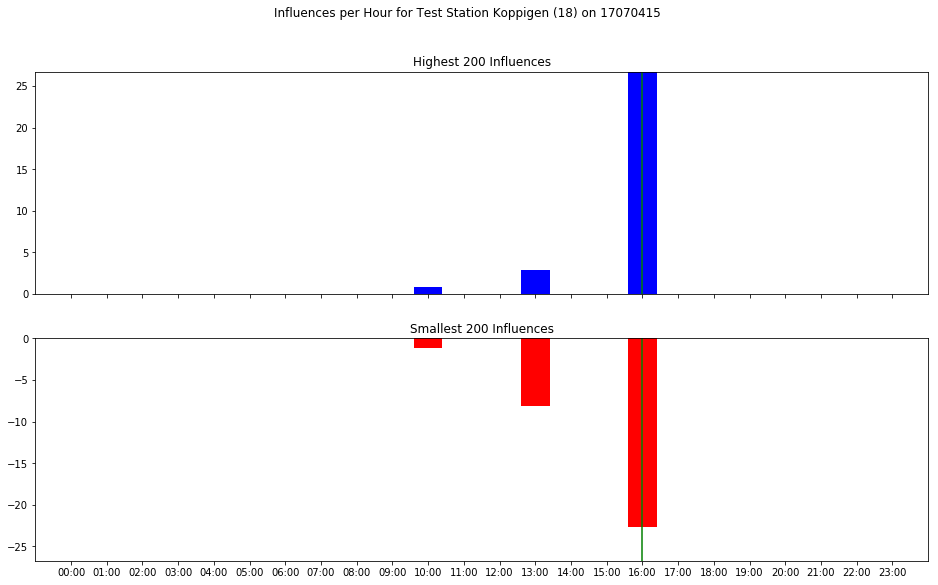

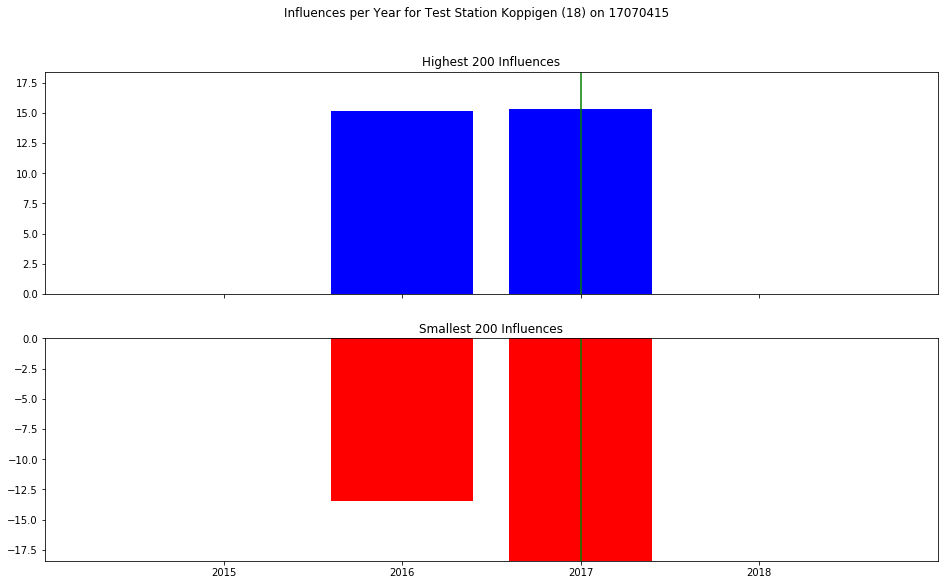

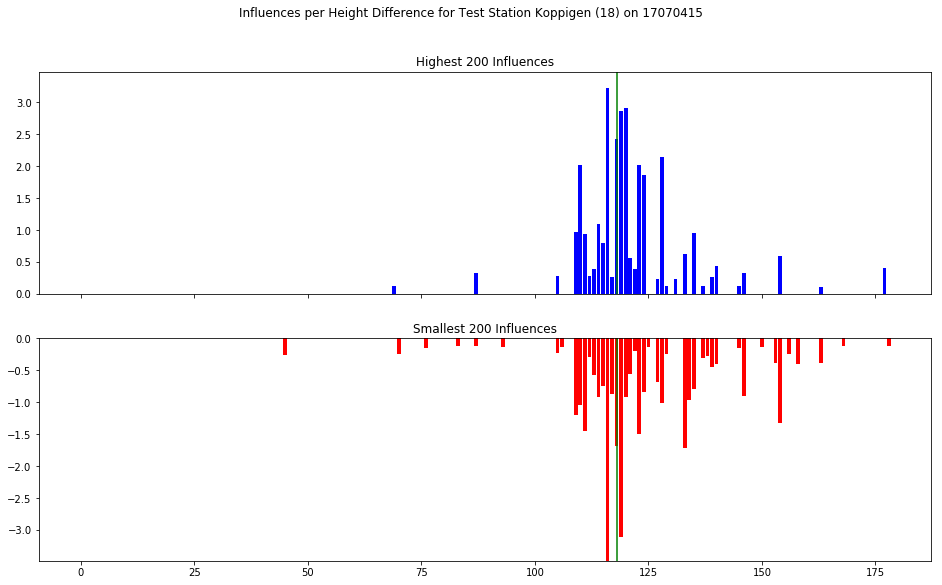

Bucket size:  5


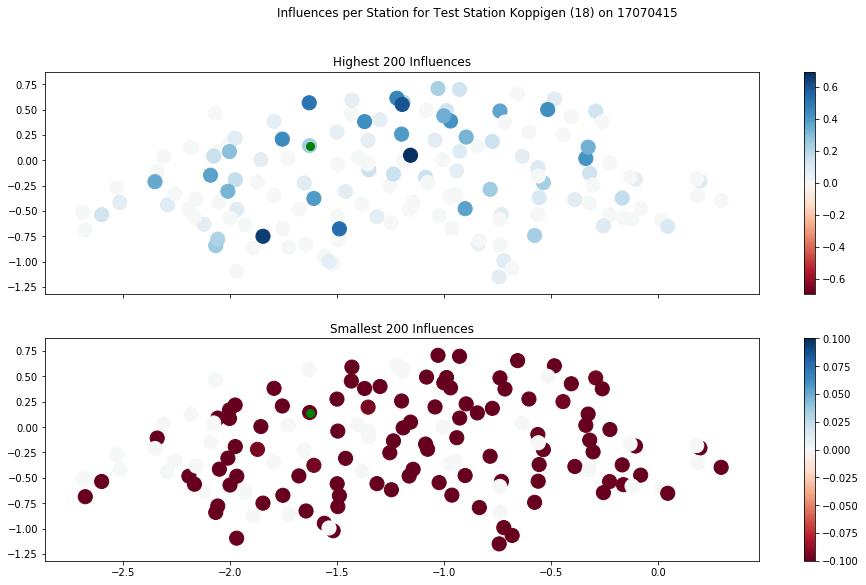

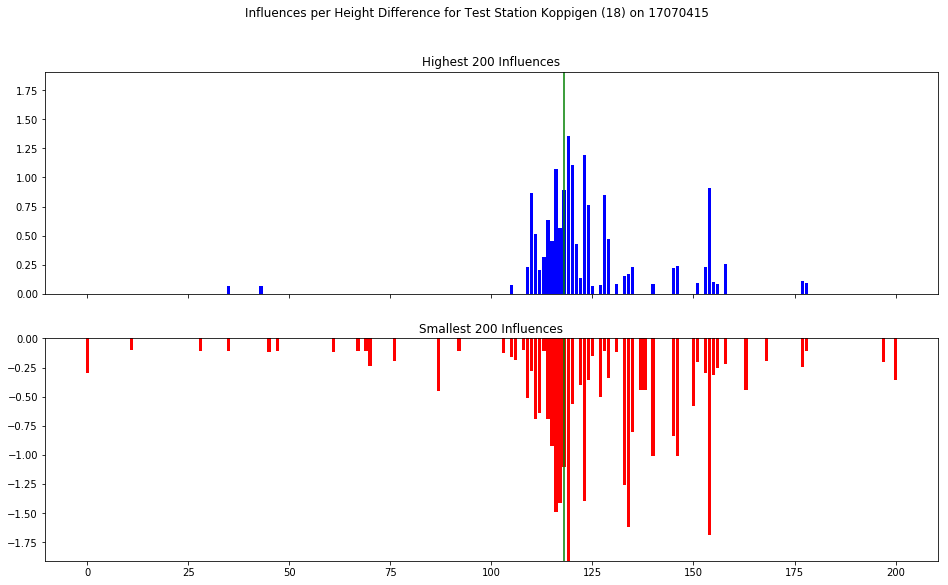

In [39]:
for idx, item in enumerate(shapley_results):
    print("Bucket size: ", item[0])
    plotTestIdxResultsWithWeightedInfluences(july_15_15_00_indices[0], item[1])

#### Bin size 0.1

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.1))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_shapley_values_0_1 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

652
Calculation of knn values for test idx=31 took 22.7454674243927
Calculation of knn values for test idx=38 took 22.943422555923462
Calculation of knn values for test idx=124 took 22.682751417160034
Calculation of knn values for test idx=163 took 22.652179718017578
Calculation of knn values for test idx=190 took 22.362391710281372
Calculation of knn values for test idx=343 took 22.543004989624023
Calculation of knn values for test idx=385 took 22.525355339050293
Calculation of knn values for test idx=492 took 22.489601135253906
Calculation of knn values for test idx=565 took 22.534048318862915
Calculation of knn values for test idx=951 took 22.44474959373474
Calculation of knn values for test idx=1214 took 22.53060531616211
Calculation of knn values for test idx=1277 took 22.533114433288574
Calculation of knn values for test idx=1324 took 22.438478469848633
Calculation of knn values for test idx=1368 took 22.597315073013306
Calculation of knn values for test idx=1636 took 22.73341488

#### Bin size 0.3

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.3))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_0_3 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

#### Bin size 0.5

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.5))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_0_5 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

#### Bin size 1

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/1))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_1_0 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

#### Bin size 2

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/2))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_2_0 = run_knn(july_15_15_00_indices, Y_train_temp, Y_test_temp)

#### Bin size 5

In [ ]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/5))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

july_15_15_00_5_0 = run_knn([july_15_15_00_indices], Y_train_temp, Y_test_temp)

## Calculate Shapley Vales with different Bucket Sizes For Best Station & Init

#### Best forecast skill over inits and stations in test set
Best Init.: 13.08.2016 09:00, Station: Vaduz, Forecast Skill = 100.00%<br>
Model absolute Error = 2.479553e-05, COSMO-1 absolute Error: 1.225244
Init. Idx = 330, Station Idx = 30, Station Id = 36

In [92]:
best_forecast_test_idx = test_data_set.loc[(test_data_set['Init'] == '16081309') & (test_data_set['Station'] == 30)].index[0]

#### Bin size 0.1

652
Calculation of knn values for test idx=98189 took 23.493239164352417


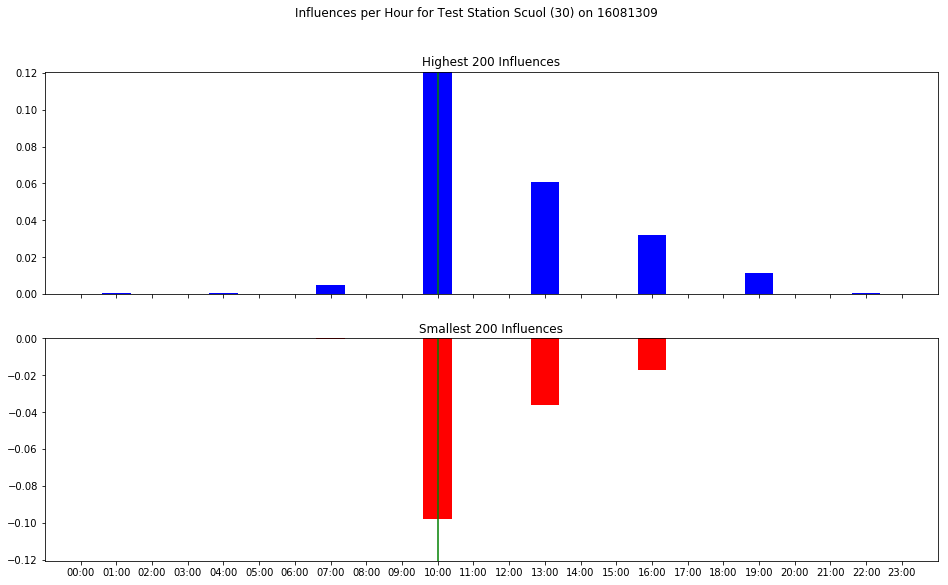

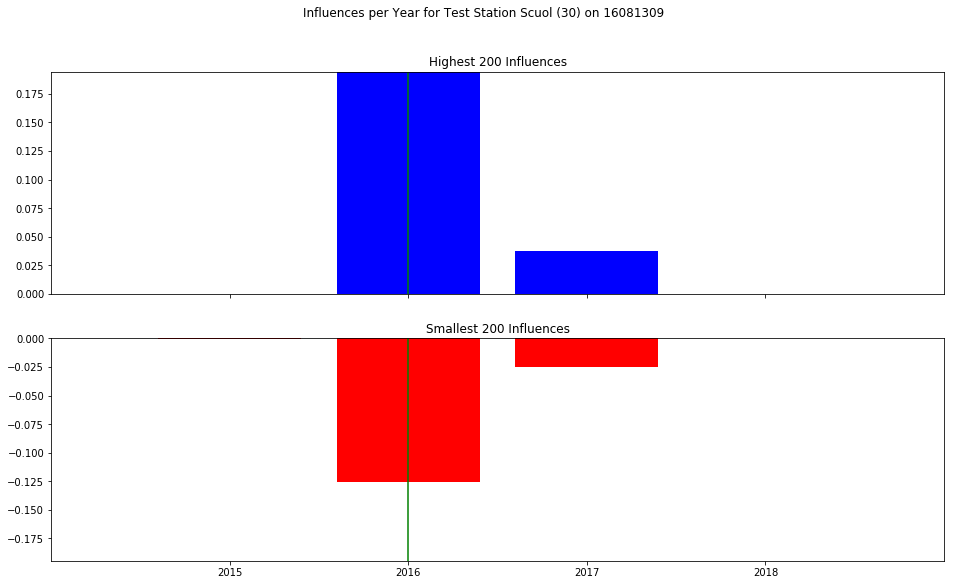

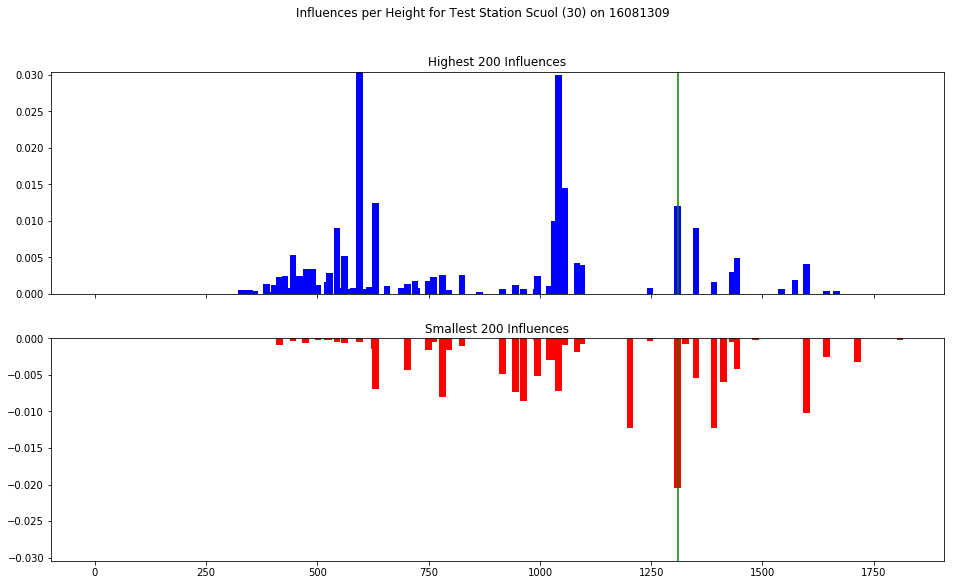

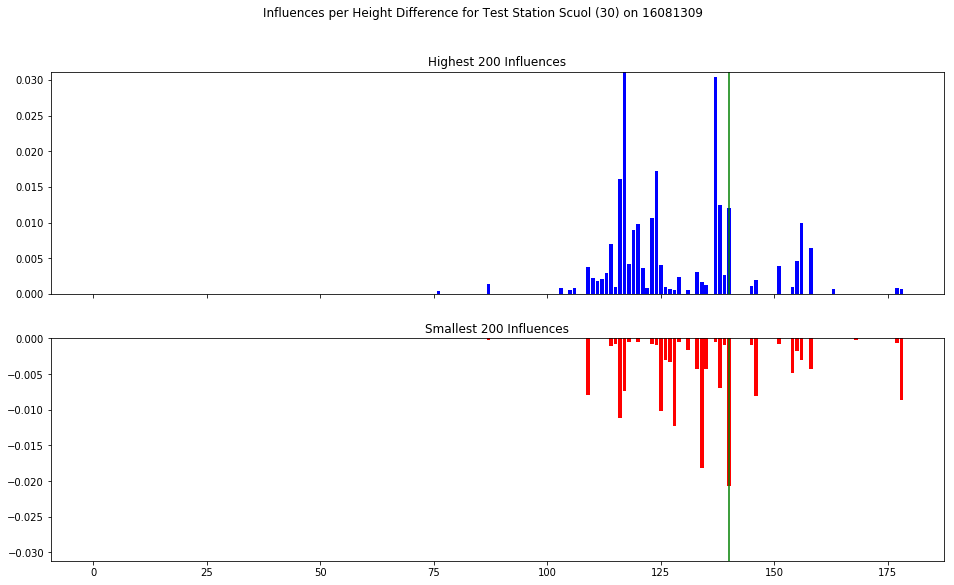

In [93]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.1))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_0_1 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_0_1)

#### Bin size 0.3

218
Calculation of knn values for test idx=98189 took 23.423980951309204


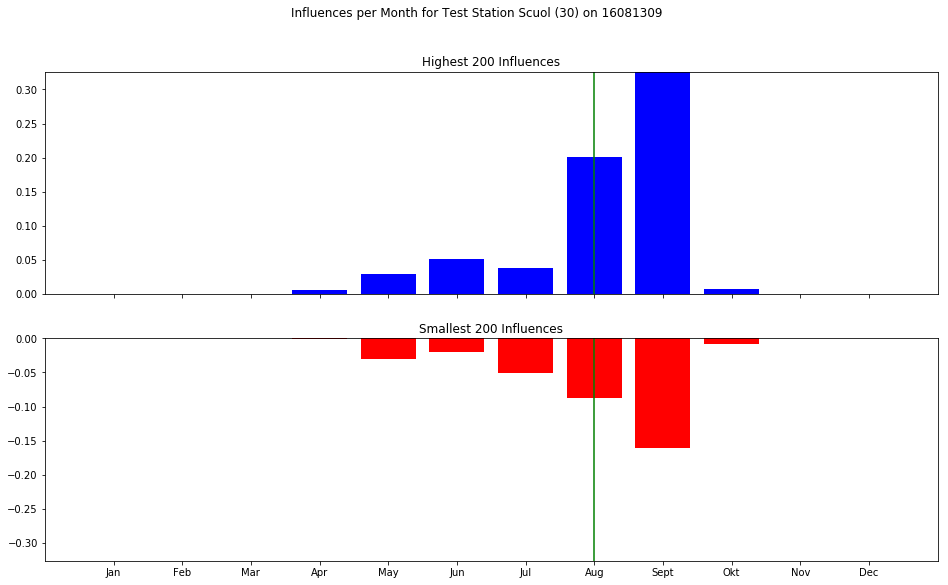

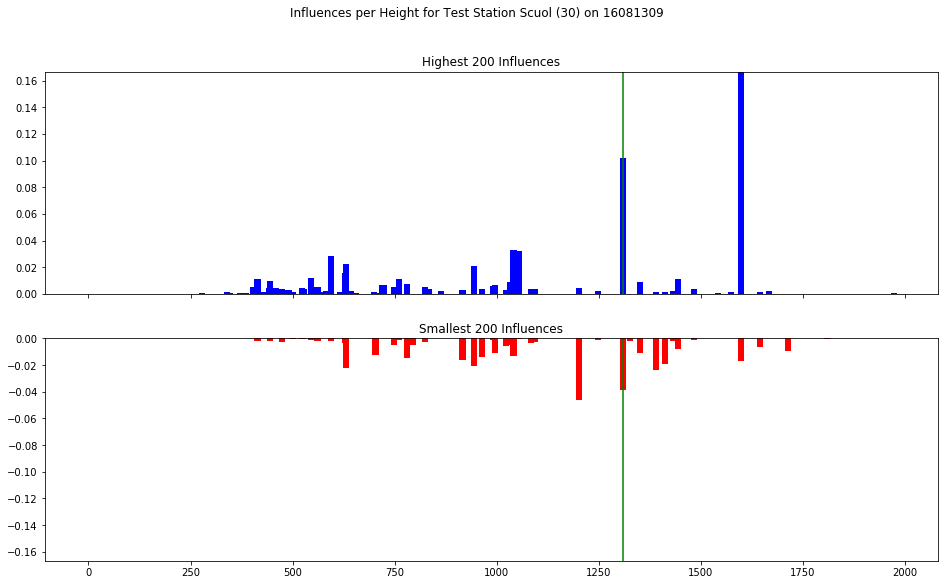

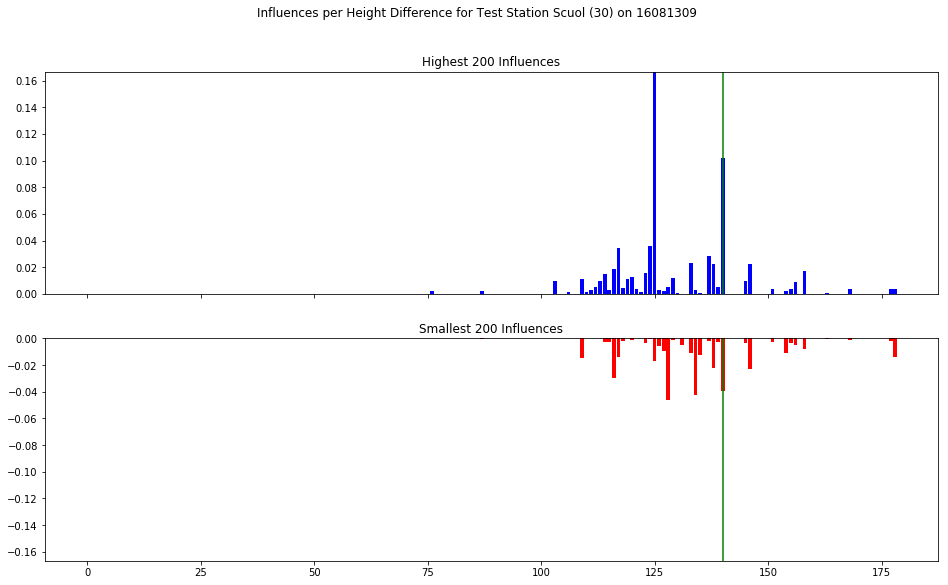

In [94]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.3))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_0_3 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_0_3)

#### Bin size 0.5

131
Calculation of knn values for test idx=98189 took 22.848592042922974


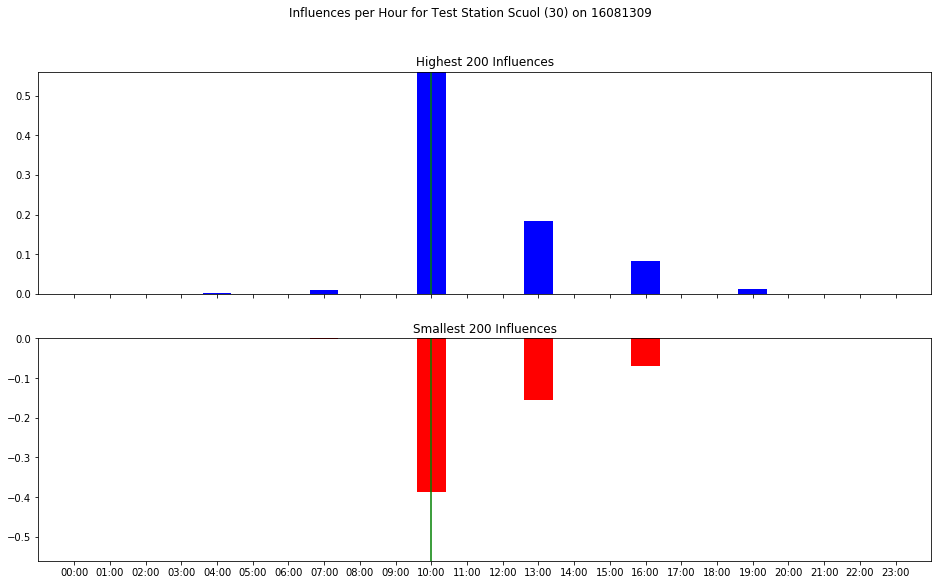

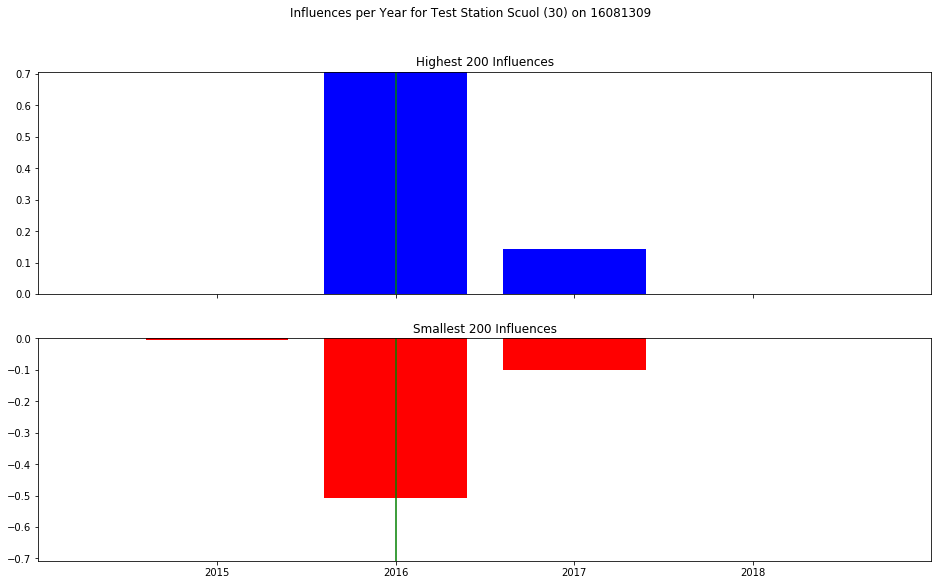

In [95]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/0.5))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_0_5 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_0_5)

#### Bin size 1

66
Calculation of knn values for test idx=98189 took 22.80648922920227


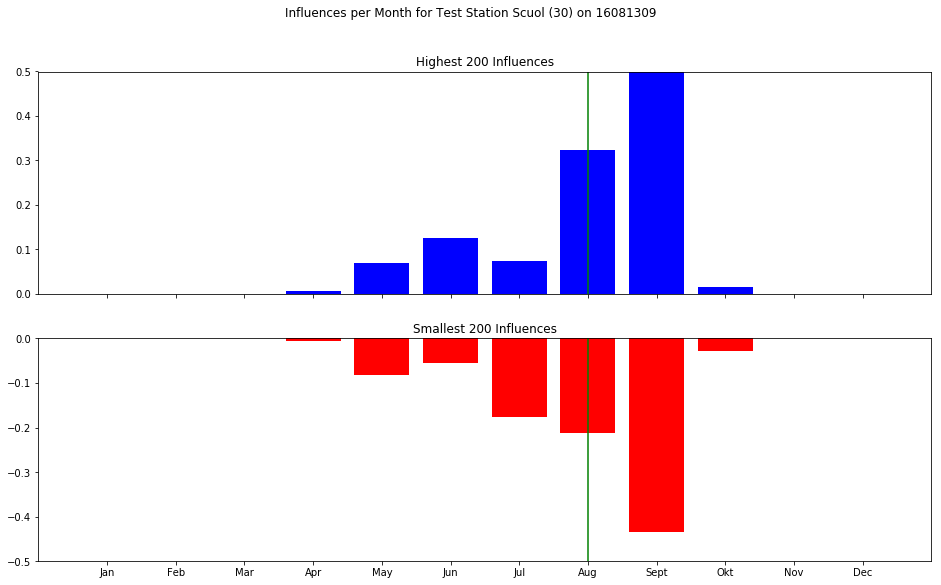

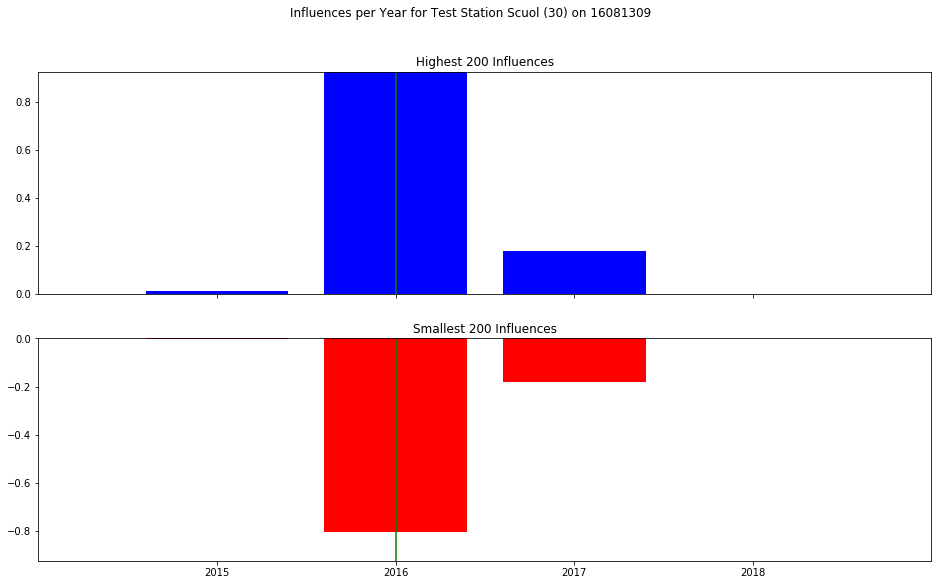

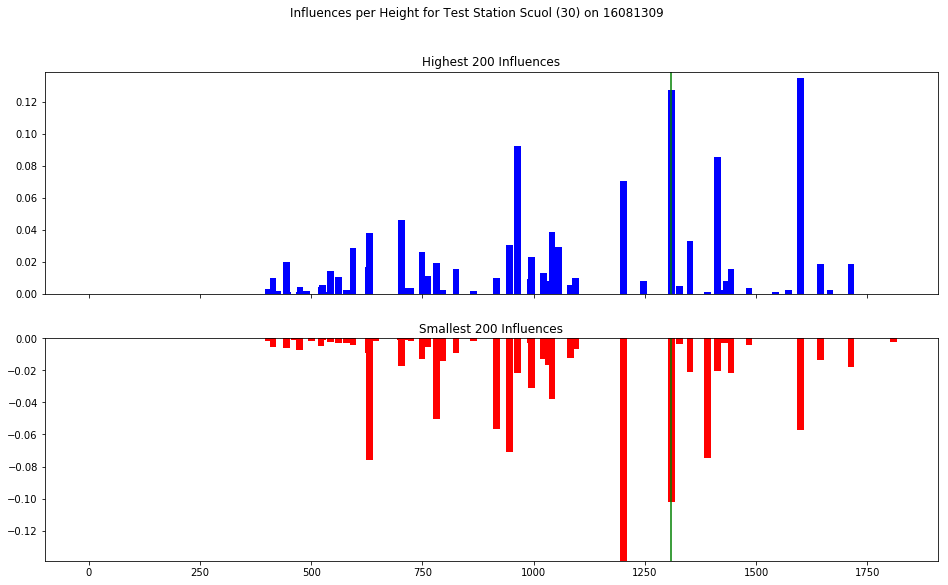

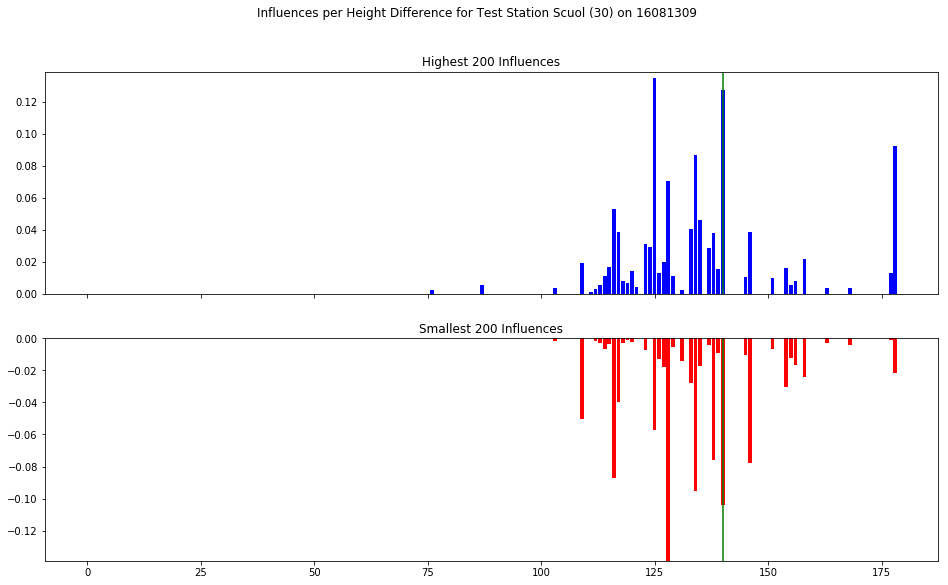

In [96]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/1))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_1_0 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_1_0)

#### Bin size 2

33
Calculation of knn values for test idx=98189 took 22.989945650100708


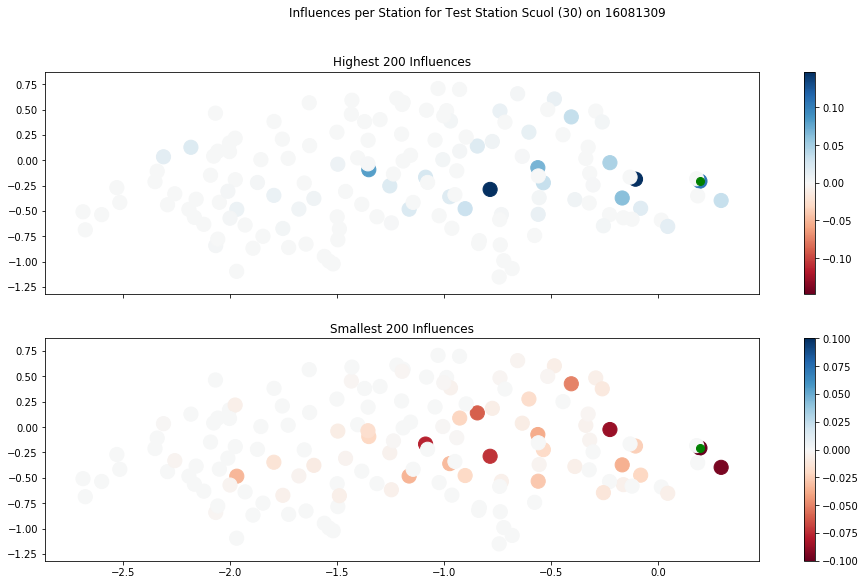

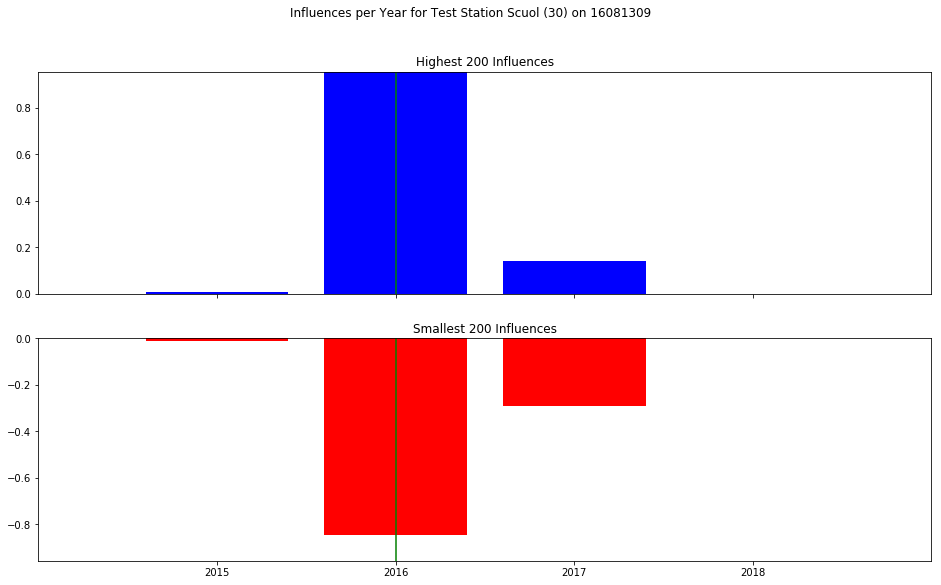

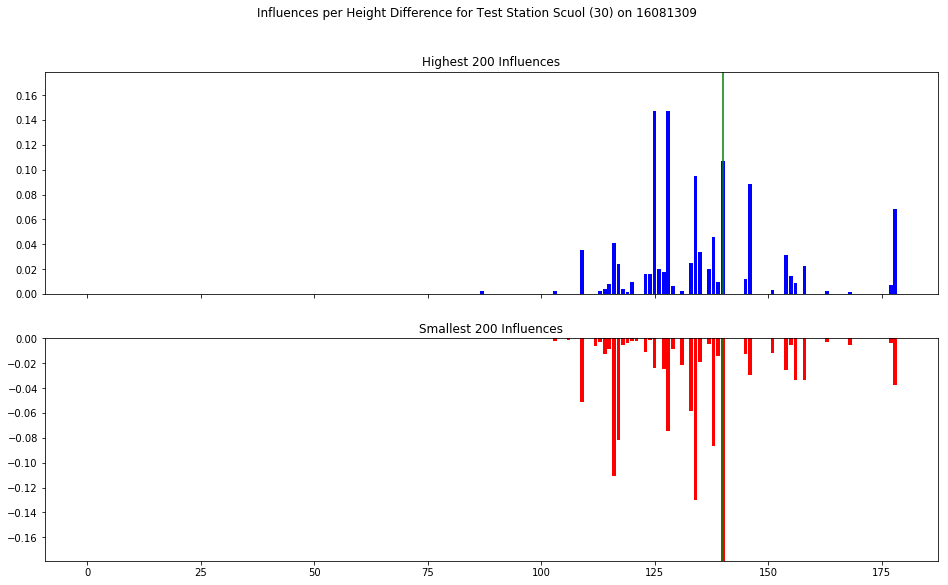

In [97]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/2))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_2_0 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_2_0)

#### Bin size 5

14
Calculation of knn values for test idx=98189 took 23.12551498413086


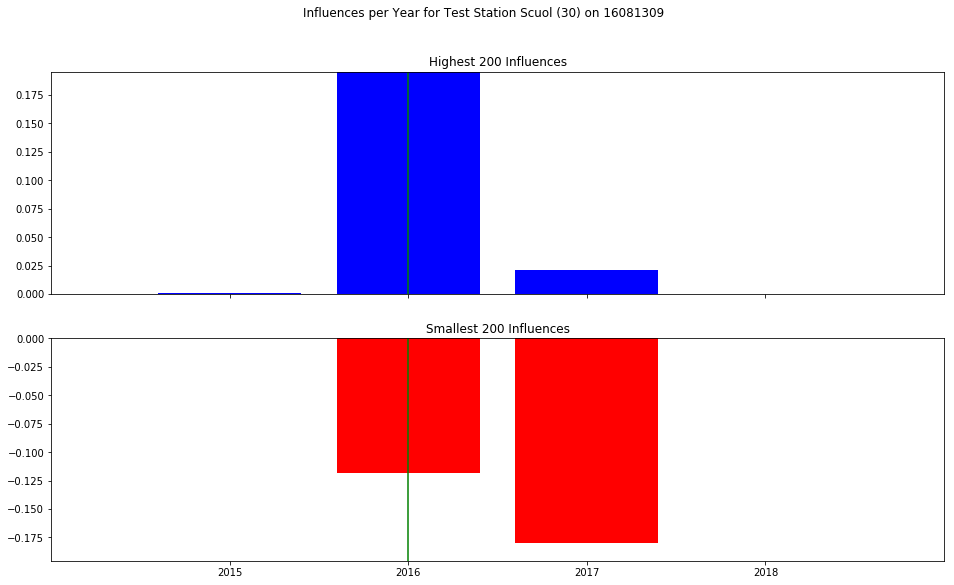

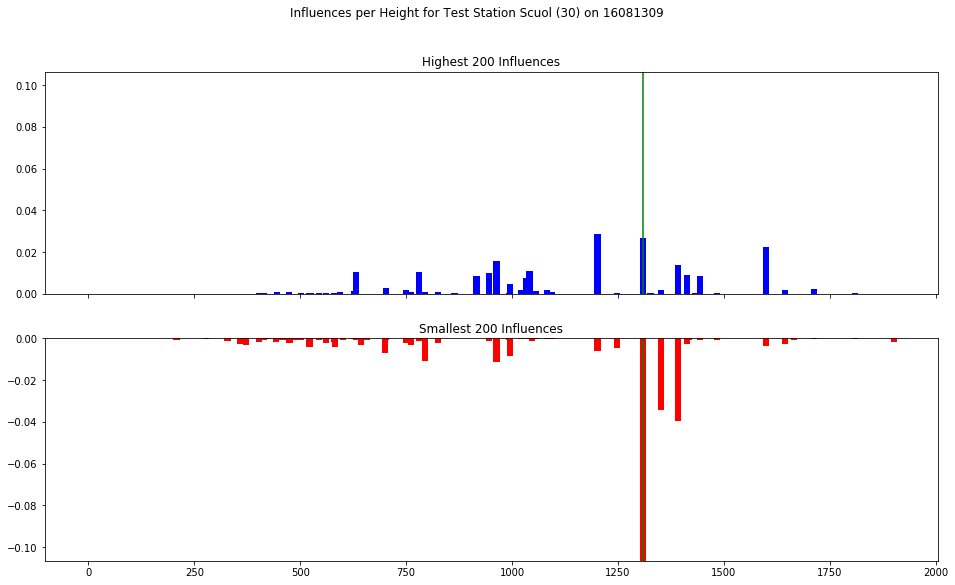

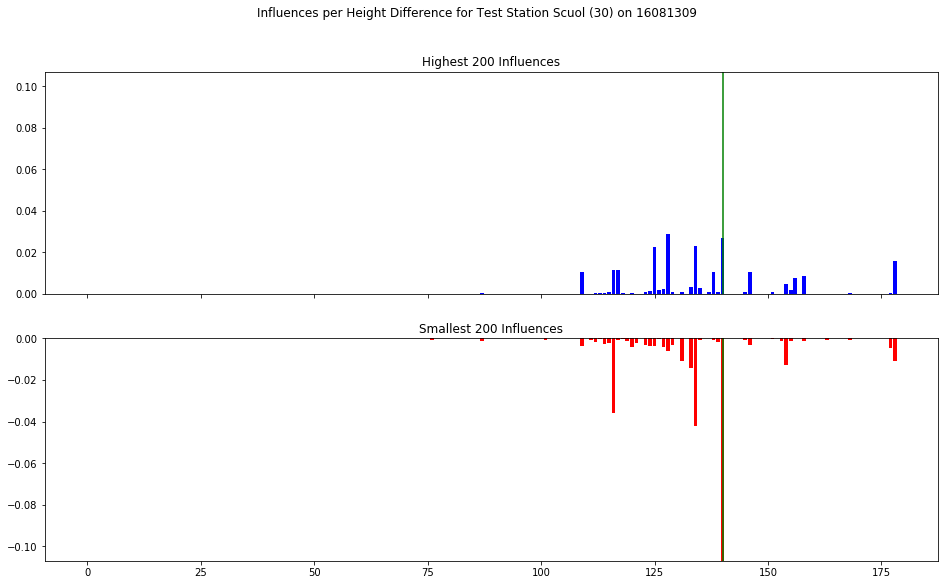

In [98]:
# adapt the labels to classes
min_label, max_label = np.minimum(np.min(Y_train_temp),np.min(Y_test_temp)), np.maximum(np.max(Y_train_temp),np.max(Y_test_temp))
n_classes = int(np.ceil((max_label - min_label)/5))
print(n_classes)

# the size of each bucket
size_of_bucket = (max_label - min_label)/n_classes

# we add two buckets that all sampels stay in the range on the left or right side, even if we shift the edges
bucket_edges = np.linspace(min_label-size_of_bucket,max_label+size_of_bucket,n_classes+3)

cetralize_function = lambda y: centralize_buckets_around_test_point(size_of_bucket, bucket_edges, False, y)

shapley_values_5_0 = run_knn([best_forecast_test_idx], Y_train_temp, Y_test_temp)
plotTestIdxResultsWithWeightedInfluences(best_forecast_test_idx, shapley_values_5_0)

In [ ]:
test_label_set

In [ ]:
for value in [shapley_values_0_1, shapley_values_0_3, shapley_values_0_5, shapley_values_1_0, shapley_values_2_0, shapley_values_5_0]:
    plt.plot(value)
    plt.show()

#### Order training points by similarity (2-norm) and plot the predicted class

In [ ]:
difference = X_train - X_test[best_forecast_test_idx]
norms = np.linalg.norm(np.float64(difference), axis=1)
sorted_norms = np.argsort(norms)
sorted_labels = Y_train[sorted_norms]
plt.plot(sorted_labels,marker='.', linestyle='None')
plt.hlines(Y_test[best_forecast_test_idx],0,len(sorted_labels), color='red')
plt.show()

#### Plotted the test labes and the corresponding bin ditribution

In [ ]:
ordered_test_labels = np.argsort(Y_test_temp)
Y_test_temp_shiftet = Y_test_temp[ordered_test_labels] + np.abs(np.min(Y_test_temp))
plt.figure(figsize=(16,9))
plt.plot(Y_test_temp_shiftet)
plt.plot(Y_test[ordered_test_labels])
plt.hlines(Y_test_temp_shiftet[best_forecast_test_idx],0,len(ordered_test_labels), color='red')
plt.show()

In [ ]:
#### Plotted fo each point the distance of the real prediction to the lower bin border

In [ ]:
plt.plot(Y_test_temp_shiftet - Y_test[ordered_test_labels])
plt.show()

In [ ]:
#### Distibution of test bins and train bins

In [ ]:
plt.hist(Y_train, bins=100)
plt.hist(Y_test, bins=100, color='red')
plt.show()

In [ ]:
month_dict={0:'Jan', 1:'Feb', 2:'Mar', 3:'Apr', 4:'May', 5:'Jun', 6:'Jul', 7:'Aug', 8:'Sept', 9:'Okt', 10:'Nov', 11:'Dec'}

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx
    
def plotTestIdxResultsWithInfluences(test_idx, influences):
    # get init, station, rlat, rlon, height and height difference for test idx
    test_init, test_station = test_data_set.iloc[test_idx].as_matrix()[0:2]
    test_station_rlat, test_station_rlon, test_station_height = station_positions.sel(station = test_station).data
    test_station_hh_diff = station_heigh_diff.sel(station = test_station).data
    # index in array representation of stations
    test_station_idx = stations.data.tolist().index(test_station)
    # get formatted station name
    test_station_name = station_names[test_station_idx].item()
    
    # define number of influences to be plotted
    k_largest_influences = 200
    k_smallest_influences = 200

    #hour_filterd_influence = filter_influence_by_hour(influences, train_data_set, test_init)
    #month_filtered_influence = filter_influence_by_month(influences, train_data_set, test_init)
    #init_filtered_influences = filter_influence_by_init(influences, train_data_set, test_init)

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, station_hh_diff)]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    station_init_by_largest_influence_as_list = list(zip(*station_init_by_largest_influence))

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, station_hh_diff)]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    station_init_by_smallest_influence_as_list = list(zip(*station_init_by_smallest_influence))

    # plot influence by station
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
    # plot stations with largest effect
    h, x_edges, y_edges, im = axes[0].hist2d(station_init_by_largest_influence_as_list[4],
                                             station_init_by_largest_influence_as_list[3],
                                             bins=10, range=np.array([(np.min(station_positions.data[:,1]),
                                                                      np.max(station_positions.data[:,1])),
                                                                      (np.min(station_positions.data[:,0]),
                                                                      np.max(station_positions.data[:,0]))]))
    axes[0].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=15)
    fig.colorbar(im, ax=axes[0])
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    h, x_edges, y_edges, im = axes[1].hist2d(station_init_by_smallest_influence_as_list[4],
                                             station_init_by_smallest_influence_as_list[3],
                                             bins=10, range=np.array([(np.min(station_positions.data[:,1]),
                                                                      np.max(station_positions.data[:,1])),
                                                                      (np.min(station_positions.data[:,0]),
                                                                      np.max(station_positions.data[:,0]))]))
    axes[1].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=15)
    axes[1].set_ylim(np.min(station_positions.data[:,0]), np.max(station_positions.data[:,0]))
    axes[1].set_xlim(np.min(station_positions.data[:,1]), np.max(station_positions.data[:,1]))
    fig.colorbar(im, ax=axes[1])
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Station for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence by hour
    print("All hours: %s" % set([int(m[6:8]) for m in station_init_by_largest_influence_as_list[1]]))
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    # plot stations with largest effect
    n, bins, patches = axes[0].hist([int(m[6:8]) for m in station_init_by_largest_influence_as_list[1]],
                                    bins=np.arange(25)-0.5)
    axes[0].axvline(x=int(test_init[6:8]), color='green')
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].hist([int(m[6:8]) for m in station_init_by_smallest_influence_as_list[1]], bins=bins)
    axes[1].axvline(x=int(test_init[6:8]),color='green')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Hour for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    plt.show()
    plt.close()

    # plot influence by month
    print("All months: %s" % set([int(m[2:4]) for m in station_init_by_largest_influence_as_list[1]]))
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    # plot stations with largest effect
    n, bins, patches = axes[0].hist([int(m[2:4]) for m in station_init_by_largest_influence_as_list[1]],
                                    bins=np.arange(14)-0.5)
    axes[0].axvline(x=int(test_init[2:4]),color='green')
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].hist([int(m[2:4]) for m in station_init_by_smallest_influence_as_list[1]], bins=bins)
    axes[1].axvline(x=int(test_init[2:4]),color='green')
    axes[0].set_xlim(0,14,1)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Month for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    #plt.setp(axes, xticks=range(1), xticklabels=[month_dict[m] for m in range(12)])
    plt.show()
    plt.close()

    # plot influence against height
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    # plot stations with largest effect
    n, bins, patches = axes[0].hist(station_init_by_largest_influence_as_list[5], bins=100)
    axes[0].axvline(x=test_station_height,color='green')
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with smallest effect
    axes[1].hist(station_init_by_smallest_influence_as_list[5], bins=bins)
    axes[1].axvline(x=test_station_height,color='green')
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence against height difference
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    # plot stations with largest effect
    n, bins, patches = axes[0].hist(station_init_by_largest_influence_as_list[6], bins=50)
    axes[0].axvline(x=test_station_hh_diff,color='green')
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].hist(station_init_by_smallest_influence_as_list[6], bins=bins)
    axes[1].axvline(x=test_station_hh_diff,color='green')
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height Difference for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

In [ ]:
for key, value in actual_loss_diffs.items():
    plotTestIdxResultsWithWeightedInfluences(key, value)

In [ ]:
actual_loss_diffs.keys()

## Run a KNN-Regression

In [9]:
prediction_error.sel(data = 'difference')

<xarray.DataArray 'run_0' (init: 7055, station: 144)>
array([[ 5.397666,  0.1299  , -0.671551, ...,  0.670012,  0.457785,  1.882113],
       [ 5.931406,  0.546072,  0.270625, ...,  0.035626,  1.56253 ,  2.296078],
       [-0.513701, -0.289843,  0.138345, ...,  0.616054,  1.146203,  2.319295],
       ...,
       [ 0.970244, -0.179661,  0.549865, ..., -1.755389,  0.380414, -0.325752],
       [-3.173494, -0.487645, -0.912433, ..., -1.519075,  1.371859, -1.608418],
       [-0.780266, -1.517487, -0.875726, ..., -0.662136,  0.65589 , -2.700554]])
Coordinates:
  * init     (init) <U8 '15100103' '15100106' '15100109' '15100112' ...
  * station  (station) int32 2 3 4 6 7 8 9 10 11 13 14 15 17 18 19 20 22 23 ...
    data     <U10 'difference'
Attributes:
    init_type_mapping:  [('15100103', 'test'), ('15100106', 'test'), ('151001...

In [21]:
trained_knn_regressors = {}
for K in [25,30,35,40,45]:
    # take start time
    start = time()
    
    # define, fit and predict KNN-regressor
    knn = neighbors.KNeighborsRegressor(K, weights='distance', n_jobs=16).fit(X_train, Y_train_temp)
    
    # store trained KNN-Regressor
    trained_knn_regressors[K] = knn
    
    y_ = knn.predict(X_test)
    
    # calc. RMSE
    rmse = np.sqrt(np.mean(np.square(y_ - Y_test_temp)))
    
    # print results
    print("%sNN-Regression took %ss with an RMSE = %2.5f" % (K, str(time()-start), rmse))

25NN-Regression took 84.0446617603302s with an RMSE = 1.29272
30NN-Regression took 88.67303514480591s with an RMSE = 1.28970
35NN-Regression took 59.69937777519226s with an RMSE = 1.28727
40NN-Regression took 96.10076475143433s with an RMSE = 1.28609
45NN-Regression took 88.23351192474365s with an RMSE = 1.28501


### Results of KNN-Regression
1NN-Regression took 41.93775963783264s with an RMSE = 1.72212<br>
3NN-Regression took 49.68207025527954s with an RMSE = 1.43375<br>
5NN-Regression took 40.227123975753784s with an RMSE = 1.37092<br>
10NN-Regression took 51.34733963012695s with an RMSE = 1.32108<br>
20NN-Regression took 52.76699757575989s with an RMSE = 1.29733<br>
25NN-Regression took 84.0446617603302s with an RMSE = 1.29272<br>
30NN-Regression took 88.67303514480591s with an RMSE = 1.28970<br>
35NN-Regression took 59.69937777519226s with an RMSE = 1.28727<br>
40NN-Regression took 96.10076475143433s with an RMSE = 1.28609<br>
45NN-Regression took 88.23351192474365s with an RMSE = 1.28501<br>
50NN-Regression took 66.15110540390015s with an RMSE = 1.28431<br>
100NN-Regression took 77.81166553497314s with an RMSE = 1.28147<br>
200NN-Regression took 86.16524505615234s with an RMSE = 1.28154<br>
500NN-Regression took 109.13341331481934s with an RMSE = 1.28332<br>
1000NN-Regression took 141.19124364852905s with an RMSE = 1.28571

# Backup

In [ ]:
def plotTestIdxResultsWithWeightedInfluences(test_idx, influences):
    # get init, station, rlat, rlon, height and height difference for test idx
    test_init, test_station = test_data_set.iloc[test_idx].as_matrix()[0:2]
    test_station_rlat, test_station_rlon, test_station_height = station_positions.sel(station = test_station).data
    test_station_hh_diff = station_heigh_diff.sel(station = test_station).data
    
    # index in array representation of stations
    test_station_idx = stations.data.tolist().index(test_station)
    # get formatted station name
    test_station_name = station_names[test_station_idx].item()
    
    # define number of influences to be plotted
    k_largest_influences = 200
    k_smallest_influences = 200

    # get largest and smallest influences
    largest_influence_idx = np.argsort(influences)[-k_largest_influences:]
    smallest_influence_idx = np.argsort(influences)[:k_smallest_influences]

    # get array of ('Station','Init') ordered by training sample indices
    init_station_train_data = train_data_set.loc[:,'Init':'Station'].as_matrix()
    
    # get station & init samples with the largest influence
    station_init_by_largest_influence = []
    for train_sample_idx in largest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_largest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_largest_influence = sorted(station_init_by_largest_influence, key=itemgetter(2))
    largest_influence_data = np.array(list(zip(*station_init_by_largest_influence)), dtype='float64')

    # get station & init samples with the smallest influence
    station_init_by_smallest_influence = []
    for train_sample_idx in smallest_influence_idx:
        init, station = init_station_train_data[train_sample_idx]
        station_rlat, station_rlon, station_height = station_positions.isel(station = station_idx_mapping[station]).data
        station_hh_diff = station_heigh_diff.isel(station = station_idx_mapping[station]).data.item()
        station_init_by_smallest_influence += [(station, init, influences[train_sample_idx], station_rlat, station_rlon, station_height, int(200*station_hh_diff))]
    station_init_by_smallest_influence = sorted(station_init_by_smallest_influence, key=itemgetter(2))
    smallest_influence_data = np.array(list(zip(*station_init_by_smallest_influence)), dtype='float64')

    # plot influence by station
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True, figsize=(16,9))
    
    # sum influence of most influential points per station
    sum_largest_influences_per_station = np.bincount(largest_influence_data[0].astype(int),largest_influence_data[2],
                                                     np.max(stations.data)+1)[stations]
    sum_smallest_influences_per_station = np.bincount(smallest_influence_data[0].astype(int),smallest_influence_data[2],
                                                      np.max(stations.data)+1)[stations]
    
    # plot stations with largest effect
    cax = axes[0].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=sum_largest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-np.max(sum_largest_influences_per_station),
                                           vmax=np.max(sum_largest_influences_per_station)))
    axes[0].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[0])
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    cax = axes[1].scatter(station_positions.sel(positinal_attribute = 'rlon'),
                 station_positions.sel(positinal_attribute = 'rlat'),
                 c=sum_smallest_influences_per_station, s=200, cmap='RdBu',
                 norm=mpl.colors.Normalize(vmin=-np.max(sum_smallest_influences_per_station),
                                           vmax=np.max(sum_smallest_influences_per_station)))
    axes[1].plot(test_station_rlon, test_station_rlat, marker='o', color='green', markersize=8)
    fig.colorbar(cax, ax=axes[1])
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)

    plt.suptitle('Influences per Station for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence by hour
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per hour
    sum_largest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 24)
    sum_smallest_influences_per_hour = np.bincount([(int(str(m)[6:8]) + 1) % 24 for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 24)
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_hour)),
                                        np.max(np.absolute(sum_smallest_influences_per_hour)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(0,24), sum_largest_influences_per_hour, color='blue')
    axes[0].axvline(x=int(test_init[6:8])+1, color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with largest effect
    axes[1].bar(np.arange(0,24), sum_smallest_influences_per_hour, color='red')
    axes[1].axvline(x=int(test_init[6:8])+1,color='green')
    axes[1].set_xlim(-1,24,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Hour for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes, xticks=range(24), xticklabels=["%02d:00" % h for h in range(24)])
    plt.show()
    plt.close()

    # plot influence by month
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per month
    sum_largest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 13)[1:]
    sum_smallest_influences_per_month = np.bincount([int(str(m)[2:4]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 13)[1:]
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_month)),
                                        np.max(np.absolute(sum_smallest_influences_per_month)))
        
    # plot stations with largest effect
    axes[0].bar(np.arange(1,13), sum_largest_influences_per_month, color='blue')
    axes[0].axvline(x=int(test_init[2:4]),color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(1,13), sum_smallest_influences_per_month, color='red')
    axes[1].axvline(x=int(test_init[2:4]),color='green')
    axes[1].set_xlim(0,13,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Month for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes[1], xticks=np.arange(1,13), xticklabels=[month_dict[m] for m in range(12)])
    plt.show()
    plt.close()
    
    
    # plot influence by year
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per year
    sum_largest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in largest_influence_data[1]],
                                                  largest_influence_data[2], 19), (15,16,17,18))
    sum_smallest_influences_per_year = np.take(np.bincount([int(str(m)[:2]) for m in smallest_influence_data[1]],
                                                    smallest_influence_data[2], 19), (15,16,17,18))
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_year)),
                                        np.max(np.absolute(sum_smallest_influences_per_year)))
    
    # plot stations with largest effect
    axes[0].bar(np.arange(15,19), sum_largest_influences_per_year, color='blue')
    axes[0].axvline(x=int(test_init[:2]),color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(np.arange(15,19), sum_smallest_influences_per_year, color='red')
    axes[1].axvline(x=int(test_init[:2]),color='green')
    axes[1].set_xlim(14,19,1)
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    plt.suptitle('Influences per Year for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.setp(axes[1], xticks=np.arange(15,19), xticklabels=['2015', '2016', '2017', '2018'])
    plt.show()
    plt.close()
    
    # plot influence against height
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per height
    sum_largest_influences_per_height = np.bincount(largest_influence_data[5].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height = np.bincount(smallest_influence_data[5].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_height)),
                                        np.max(np.absolute(sum_smallest_influences_per_height)))
    
    # plot stations with largest effect
    axes[0].bar(range(len(sum_largest_influences_per_height)), sum_largest_influences_per_height, color='blue', width=15)
    axes[0].axvline(x=test_station_height,color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)
    
    # plot stations with smallest effect
    axes[1].bar(range(len(sum_smallest_influences_per_height)), sum_smallest_influences_per_height, color='red', width=15)
    axes[1].axvline(x=test_station_height,color='green')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()

    # plot influence against height difference
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(16,9))
    
    # sum influence of most influential points per height difference
    sum_largest_influences_per_height_difference = np.bincount(largest_influence_data[6].astype(int), largest_influence_data[2])
    sum_smallest_influences_per_height_difference = np.bincount(smallest_influence_data[6].astype(int), smallest_influence_data[2])
    
    max_absolute_influence = np.maximum(np.max(np.absolute(sum_largest_influences_per_height_difference)),
                                        np.max(np.absolute(sum_smallest_influences_per_height_difference)))
    
    # plot stations with largest effect
    axes[0].bar(range(len(sum_largest_influences_per_height_difference)), sum_largest_influences_per_height_difference, color='blue')
    axes[0].axvline(x=int(test_station_hh_diff*200),color='green')
    axes[0].set_ylim(0, max_absolute_influence)
    axes[0].set_title('Highest %s Influences' % k_largest_influences)

    # plot stations with smallest effect
    axes[1].bar(range(len(sum_smallest_influences_per_height_difference)), sum_smallest_influences_per_height_difference, color='red')
    axes[1].axvline(x=int(test_station_hh_diff*200),color='green')
    axes[1].set_ylim(-max_absolute_influence, 0)
    axes[1].set_title('Smallest %s Influences' % k_smallest_influences)
    
    plt.suptitle('Influences per Height Difference for Test Station %s (%s) on %s' % (test_station_name,
                                                                         test_station, test_init))
    plt.show()
    plt.close()